TED Talks transcripts
https://www.kaggle.com/rounakbanik/ted-talks?select=transcripts.csv#

In [74]:
import pandas as pd
import spacy
import numpy as np
import pickle
import re
from sklearn import svm
from scipy.stats import entropy

from sklearn.metrics import *
from matplotlib import pyplot as plt 
from collections import OrderedDict
import random
import requests
from collections import OrderedDict

In [153]:
def load_phonetic_embedding():
    lookup = None
    # read phonetic embedding pickle file
    path = "../data/"
    with open(path+'phonetic_embd.pickle', 'rb') as handle:
        lookup = pickle.load(handle)
    print("Phonetic embedding loaded !")
    return lookup

lookup = load_phonetic_embedding()

len(list(lookup.keys()))

Phonetic embedding loaded !


116514

In [76]:
"$" in list(lookup.keys())

False

In [77]:
"NY" in lookup

False

In [78]:
"alaska" in lookup

False

In [79]:
df = pd.read_csv("../data/TED_transcripts.csv")
df = df["transcript"]
df.head()

0    Good morning. How are you?(Laughter)It's been ...
1    Thank you so much, Chris. And it's truly a gre...
2    (Music: "The Sound of Silence," Simon & Garfun...
3    If you're here today — and I'm very happy that...
4    About 10 years ago, I took on the task to teac...
Name: transcript, dtype: object

In [80]:
df.shape

(2467,)

In [81]:
# Tokenize all documents
nlp = spacy.load("en_core_web_sm")

tokens = []
for talk in df:
    doc = nlp(talk)
    words = []
    for w in doc:
        if w.text.isalpha():
            words.append(w.text.lower())
    #words = list(set(words))  -- this way to remove duplicates changes order so we use alternative
    words = list(OrderedDict.fromkeys(words))
    tokens.append(words)
print(len(tokens))

2467


In [82]:
# save TED transcript unique tokens to file
with open('TED_transcript_tokens.npy', 'wb') as f:
    np.save(f, np.array(tokens, dtype=object))

In [154]:
# load saved file
tokens = np.load('TED_transcript_tokens.npy', allow_pickle=True)

In [155]:
# set of unique words among all of the test set
test_words = []
for l in tokens:
    test_words.extend(l)
test_words = list(OrderedDict.fromkeys(test_words))
len(test_words)

56989

In [167]:
# returns 1 if word is difficult to say 0 otherwise
# here, we have simulated 5 different users so output will be different for each user
def oracle(word, user):
    if user==0:   # starting with a consonant and then followed by the r sound
        pattern = "^([b-df-hj-np-tv-z])r.*"
    elif user==1:  # starting with st or fl
        pattern = "^(st|fl).*"
    elif user==2:  # r or l letter at second place
        pattern = ".{1}[r|l].*"
    elif user==3:  # anywhere in the word - ch or sc
        pattern = ".*(ch|sc).*" 
    elif user==4:  # starting with B,P,D,M,N, and F 
        pattern = "^[bpdmnf].*"
    elif user==5:   # user0 + user4
        pattern = "^([b-df-hj-np-tv-z])r.*" + "|" + "^[bpdmnf].*"
    elif user==6:  # user1 + user3
        pattern = "^(st|fl).*" + "|" + ".*(ch|sc).*"
    elif user==7:  # user2 + user4
        pattern = ".{1}[r|l].*" + "|" + "^[bpdmnf].*"
    elif user==8:  # user0 + user3 + user4
        pattern = "^([b-df-hj-np-tv-z])r.*" +"|"+ ".*(ch|sc).*" + "|" + "^[bpdmnf].*"
    elif user==9:  # user1 + user2 + user3 
        pattern = "^(st|fl).*" + "|" + ".{1}[r|l].*" + "|" + ".*(ch|sc).*"
    m = re.match(pattern, word)
    if m:
        start, stop = m.span()
        if stop-start == len(word):
            return 1
    return 0

In [260]:
oracle("great", 0)

1

In [169]:
oracle("florida", 1)

1

In [170]:
def random_sampling(X_unlab, seed):
    random.seed(seed)
    return random.choice(X_unlab)

In [270]:
# returns the next most uncertain word by entropy
# @input: clf - classifier, X_unlab - list of words
def uncertainity_sampling(clf, X_unlab):
    X_unlab = [w for w in X_unlab if w.upper() in lookup]
    X = [lookup[w.upper()] for w in X_unlab]
    prob = clf.predict_proba(X)
    ent = entropy(prob.T)
    sorted_ind = (-ent).argsort()[0]
    return X_unlab[sorted_ind]

def clf_predict(clf, words):
    pred = []
    for w in words:
        w = w.upper()
        if w not in lookup:
            pred.append(0)
        else:
            pred.append(clf.predict([lookup[w]])[0])
    return pred

# fit function because not all words are available in lookup
def clf_fit(words, label):
    X, y = [], []
    for w,l in zip(words, label):
        w = w.upper()
        if w in lookup:
            X.append(lookup[w])
            y.append(l)
    clf = svm.SVC(probability=True, random_state=0, class_weight='balanced')   
    clf.fit(X, y)
    return clf

In [271]:
# for a given trained classifier - computes different metrics on the test set
def evaluate(clf, X_test, y_test):
    y_pred = clf_predict(clf, X_test)
    pre = precision_score(y_test, y_pred, zero_division=0)*100
    acc = accuracy_score(y_test, y_pred)*100
    f1 = f1_score(y_test, y_pred)*100
    recall = recall_score(y_test, y_pred)*100
    #print(round(f1,2), "   ",round(acc,2), "    ",round(pre,2))
    return {"precision":pre, "accuracy":acc, "f1":f1, "recall":recall}

In [272]:
def initial_split(i):
    easy, diff = [], []
    #easy = ['a', 'an', 'he', 'she', 'be', 'the', 'cat', 'dog', 'bat', 'mat', 'rat']
    if i==0:   # r sound at second place
        #print("consonant followed by r sound")
        easy = ['clock', 'regular', 'water', 'made', 'computer']
        diff = ['graph', 'group', 'green', 'grand', 'grapes']
    elif i==1: # st or fl sound to begin
        #print("st or fl sound to begin")
        easy = ['the', 'cat', 'owl', 'bat', 'kite']
        diff = ['street', 'florida', 'straight', 'stutter', 'flexible']
    elif i==2:     # r or l letter at second place
        #print("r or l letter at second place")
        easy = ['about', 'people', 'day', 'other', 'kiwi']
        diff = ['crisp', 'crumble', 'alaska', 'close', 'brisk']
    elif i==3:   # ch or sc sound anywhere in the word
        #print("sc or ch sound anywhere in the word")
        easy = ['book', 'table', 'cat', 'shirt', 'window']
        diff = ['scold', 'chair', 'beach', 'chase', 'fiscal']
    elif i==4:  # words starting with B,P,D,M,N, and F
        #print("words starting with B,P,D,M,N, and F")
        easy = ['horse', 'house', 'group', 'actor', 'echo']
        diff = ['packet', 'more', 'nostalgia', 'fish', 'boat']
    elif i==5:   # user0 + user4
        #print("consonant followed by r sound +  words starting with B,P,D,M,N, and F")
        easy = ['racket', 'choice', 'egg', 'active', 'card']
        diff = ['crime', 'provost', 'post', 'dragon', 'basket']
    elif i==6: # user1 + user3
        #print("st or fl sound to begin +  sc or ch sound anywhere in the word")
        easy = ['packet', 'more', 'nostalgia', 'fish', 'mouse']
        diff = ['flood', 'scandal', 'stay', 'choke', 'discard']
    elif i==7:     # user2 + user4
        #print("r or l letter at second place  +  words starting with B,P,D,M,N, and F")
        easy = ['cook', 'table', 'cat', 'she', 'jacket']
        diff = ['graph', 'alcohol', 'ball','market', 'fancy']
    elif i==8:   # user0 + user3 + user4
        #print("consonant followed by r sound + sc or ch sound anywhere + starting with B,P,D,M,N, and F")
        easy = ['rational', 'recommend', 'circle', 'gang', 'tie']
        diff = ['scam', 'grand', 'match', 'cheese', 'nose']
    elif i==9:  # user1 + user2 + user3 
        #print("st or fl sound to begin + r or l letter at second place + sc or ch sound anywhere in the word")
        easy = ['beauty', 'pen', 'dish', 'govern', 'wire']
        diff = ['match', 'scam', 'alcohol', 'scold', 'strict']
    #diff = ['graph', 'group', 'trivedi', 'green', 'grand', 'provost', 'crisp', 'grey', 'grill', 'crumble']

    X_lab = easy + diff
    y_lab = [0]*len(easy) + [1]*len(diff)


    X_rem = [z for z in test_words if z not in X_lab]
    #X_rem = list(set(test_words) - set(X_lab)) -- remove duplicates but changes order

    test_size = int(len(X_rem)*0.25)
    
    X_test = X_rem[len(X_rem)-test_size:]
    y_test = [oracle(w, i) for w in X_test]
    
    X_unlab = X_rem[:len(X_rem)-test_size]
    X_train = X_lab + X_unlab

    #print(len(X_lab), len(X_unlab), len(X_train), len(X_test))
    
    return X_lab, y_lab, X_unlab, X_test, y_test

In [273]:
X_l, y_l, _, X_t, y_t = initial_split(0)
X_l.append('chair')
y_l.append(0)
c = clf_fit(X_l, y_l)
X_num = [lookup[b.upper()] for b in X_l]
c.predict_proba(X_num)[:,1], c.predict(X_num)

(array([0.02205897, 0.01999022, 0.01998185, 0.02000947, 0.01999982,
        0.98308444, 0.97715718, 0.98304394, 0.9830869 , 0.97494665,
        0.02370411]),
 array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]))

In [274]:
X_l

['clock',
 'regular',
 'water',
 'made',
 'computer',
 'graph',
 'group',
 'green',
 'grand',
 'grapes',
 'chair']

In [275]:
# check if all seed words exist in phonetic dictionary
# and they are assigned correct labels
for i in range(10):
    print(i)
    word, y_label = initial_split(i)[0], initial_split(i)[1]
    for w in word:
        if w.upper() not in lookup:
            print(w + " NOT PRESENT")
    
    if y_label != [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]:
        print("Label not matching for user: ",i)
        
    ora_labels = [oracle(w,i) for w in word]
    if ora_labels != [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]:
        print("Oracle Labels not matching for user: ",i)

0
1
2
3
4
5
6
7
8
9


In [276]:
# get most suitable alterantive for word which user can speak
def get_alternative(word, user_id):
    try:
        response = requests.get("https://api.datamuse.com/words?ml="+word)
    except JSONDecodeError as e:
        print("Exception")
    else:
        for l in response.json():
            s = l["word"] 
            if s.upper() in lookup and oracle(s, user_id)==0:
                return s
    return ""

In [277]:
get_alternative("GREAT", 0)

'good'

In [278]:
get_alternative("THREE", 1)

'trio'

In [362]:
res2 = {"imp":[], "exp":[], "ran":[]} 

number_of_queries = 500
rounds = 10
thresh_imp = 0.1

for r in range(rounds):
    print("\n\nRound ", r)
    imp_saturation = 0
    for strategy in ["imp","exp","ran"]:  # 
    #for strategy in ["imp"]:  # 
        X_lab, y_lab, X_unlab, X_test, y_test = initial_split(r)
        model = clf_fit(X_lab, y_lab)
        #res[strategy][r] = []
        res2[strategy].append(evaluate(model, X_test, y_test))
        print("******    "+strategy+"    ********")

        for i in range(number_of_queries):
                q = []
                if strategy=="imp":
                    # finding the next word which is highlighted in the interface
                    # print("Len X_unlab:  ",len(X_unlab))
                    for j, w in enumerate(X_unlab):
                        if imp_saturation == 1:
                            break
                    
                        w = w.upper()
                        #if w in lookup:
                        #    print(i,w, round(model.predict_proba([lookup[w]])[0][1], 2))
                        if w in lookup and model.predict_proba([lookup[w]])[0][1]>thresh_imp:
                            #pred = model.predict([lookup[w]])[0]
                            #prob = model.predict_proba([lookup[w]])[0][1]
                            #print(w, prob, pred, oracle(w.lower(), r))
                            q.append(w.lower())
                            # if the word is really hard, add its alternative
                            if oracle(w.lower(), r) == 1:
                                alter = get_alternative(w, r)
                                #print("Alternative: ", alter)
                                if len(alter)>0:
                                    q.append(alter)
                            break
                        
                        # if no word was found
                        if j==len(X_unlab)-1:
                            print(" ********   SATURATION ********")
                            imp_saturation = 1
                    
                elif strategy=="exp":
                    q.append(uncertainity_sampling(model, X_unlab))
                elif strategy=="ran":
                    q.append(random_sampling(X_unlab, r*i))
                
                X_lab.extend(q)
                # for each word in q, append its label
                for t in q:  
                    y_lab.append(oracle(t, r))
                
                #X_unlab = list(set(X_unlab)-set(q))
                X_unlab = [z for z in X_unlab if z not in q]
                model = clf_fit(X_lab, y_lab)
                #print("Query: ", i+1, " word: ", q[0], "  label: ",oracle(q[0], r), "len X_lab: ", len(X_lab))
                print("Round: ", r, " query: ", i+1, " word ", q)
                res2[strategy].append(evaluate(model, X_test, y_test))    



Round  0
******    imp    ********
Round:  0  query:  1  word  ['good']
Round:  0  query:  2  word  ['morning']
Round:  0  query:  3  word  ['how']
Round:  0  query:  4  word  ['are']
Round:  0  query:  5  word  ['been']
Round:  0  query:  6  word  ['great', 'good']
Round:  0  query:  7  word  ['it']
Round:  0  query:  8  word  ['blown']
Round:  0  query:  9  word  ['by']
Round:  0  query:  10  word  ['which']
Round:  0  query:  11  word  ['relevant']
Round:  0  query:  12  word  ['to']
Round:  0  query:  13  word  ['extraordinary']
Round:  0  query:  14  word  ['creativity', 'inventiveness']
Round:  0  query:  15  word  ['here']
Round:  0  query:  16  word  ['idea']
Round:  0  query:  17  word  ['find']
Round:  0  query:  18  word  ['asked']
Round:  0  query:  19  word  ['curiously']
Round:  0  query:  20  word  ['but']
Round:  0  query:  21  word  ['can']
Round:  0  query:  22  word  ['face']
Round:  0  query:  23  word  ['deep']
Round:  0  query:  24  word  ['grasp', 'comprehend']

Round:  0  query:  185  word  ['frankincense', 'myrrh']
Round:  0  query:  186  word  ['confusing']
Round:  0  query:  187  word  ['fourth']
Round:  0  query:  188  word  ['frankly', 'honestly']
Round:  0  query:  189  word  ['dance']
Round:  0  query:  190  word  ['shared']
Round:  0  query:  191  word  ['inflation']
Round:  0  query:  192  word  ['airport']
Round:  0  query:  193  word  ['continuing']
Round:  0  query:  194  word  ['fresh', 'new']
Round:  0  query:  195  word  ['flourish']
Round:  0  query:  196  word  ['during']
Round:  0  query:  197  word  ['bunch']
Round:  0  query:  198  word  ['printed', 'paper']
Round:  0  query:  199  word  ['monterey']
Round:  0  query:  200  word  ['handwritten']
Round:  0  query:  201  word  ['friend', 'acquaintance']
Round:  0  query:  202  word  ['partner']
Round:  0  query:  203  word  ['congratulations']
Round:  0  query:  204  word  ['plan']
Round:  0  query:  205  word  ['crisis', 'turmoil']
Round:  0  query:  206  word  ['celebrate'

Round:  0  query:  361  word  ['striving']
Round:  0  query:  362  word  ['destroy']
Round:  0  query:  363  word  ['incredibly']
Round:  0  query:  364  word  ['graduate', 'alumnus']
Round:  0  query:  365  word  ['largest']
Round:  0  query:  366  word  ['traveled', 'cosmopolitan']
Round:  0  query:  367  word  ['places']
Round:  0  query:  368  word  ['imprisoned']
Round:  0  query:  369  word  ['brother', 'sister']
Round:  0  query:  370  word  ['crack', 'snap']
Round:  0  query:  371  word  ['porter']
Round:  0  query:  372  word  ['generic']
Round:  0  query:  373  word  ['dream', 'daydream']
Round:  0  query:  374  word  ['torch']
Round:  0  query:  375  word  ['prostitutes', 'whore']
Round:  0  query:  376  word  ['friends', 'acquaintance']
Round:  0  query:  377  word  ['landlords']
Round:  0  query:  378  word  ['degradation']
Round:  0  query:  379  word  ['construction']
Round:  0  query:  380  word  ['profits', 'earnings']
Round:  0  query:  381  word  ['greenway', 'parkwa

Round:  0  query:  36  word  ['prairie']
Round:  0  query:  37  word  ['dreamworks']
Round:  0  query:  38  word  ['greetings']
Round:  0  query:  39  word  ['dahlia']
Round:  0  query:  40  word  ['jerry']
Round:  0  query:  41  word  ['parish']
Round:  0  query:  42  word  ['brinker']
Round:  0  query:  43  word  ['crush']
Round:  0  query:  44  word  ['growing']
Round:  0  query:  45  word  ['trucked']
Round:  0  query:  46  word  ['brodsky']
Round:  0  query:  47  word  ['pros']
Round:  0  query:  48  word  ['tremble']
Round:  0  query:  49  word  ['bismarck']
Round:  0  query:  50  word  ['boeing']
Round:  0  query:  51  word  ['trees']
Round:  0  query:  52  word  ['bruises']
Round:  0  query:  53  word  ['prearranged']
Round:  0  query:  54  word  ['partners']
Round:  0  query:  55  word  ['airplanes']
Round:  0  query:  56  word  ['proverbs']
Round:  0  query:  57  word  ['gourmet']
Round:  0  query:  58  word  ['blubber']
Round:  0  query:  59  word  ['triples']
Round:  0  que

Round:  0  query:  228  word  ['clusters']
Round:  0  query:  229  word  ['geometries']
Round:  0  query:  230  word  ['precautionary']
Round:  0  query:  231  word  ['graphical']
Round:  0  query:  232  word  ['grier']
Round:  0  query:  233  word  ['distributions']
Round:  0  query:  234  word  ['paring']
Round:  0  query:  235  word  ['profiled']
Round:  0  query:  236  word  ['prussian']
Round:  0  query:  237  word  ['crowded']
Round:  0  query:  238  word  ['transforming']
Round:  0  query:  239  word  ['cubed']
Round:  0  query:  240  word  ['pliers']
Round:  0  query:  241  word  ['gravitating']
Round:  0  query:  242  word  ['proponent']
Round:  0  query:  243  word  ['productivity']
Round:  0  query:  244  word  ['prohibited']
Round:  0  query:  245  word  ['vibrator']
Round:  0  query:  246  word  ['deformed']
Round:  0  query:  247  word  ['geriatrician']
Round:  0  query:  248  word  ['incredible']
Round:  0  query:  249  word  ['proposes']
Round:  0  query:  250  word  ['

Round:  0  query:  417  word  ['disenfranchised']
Round:  0  query:  418  word  ['preconceived']
Round:  0  query:  419  word  ['stressors']
Round:  0  query:  420  word  ['cooperatives']
Round:  0  query:  421  word  ['distributed']
Round:  0  query:  422  word  ['prebiotic']
Round:  0  query:  423  word  ['brockman']
Round:  0  query:  424  word  ['betrayal']
Round:  0  query:  425  word  ['drawn']
Round:  0  query:  426  word  ['plagiarism']
Round:  0  query:  427  word  ['sharpening']
Round:  0  query:  428  word  ['crappy']
Round:  0  query:  429  word  ['critically']
Round:  0  query:  430  word  ['pierpont']
Round:  0  query:  431  word  ['gratification']
Round:  0  query:  432  word  ['pancreas']
Round:  0  query:  433  word  ['predictability']
Round:  0  query:  434  word  ['trilogy']
Round:  0  query:  435  word  ['purifiers']
Round:  0  query:  436  word  ['brunswick']
Round:  0  query:  437  word  ['prophet']
Round:  0  query:  438  word  ['proclamations']
Round:  0  query:

Round:  0  query:  109  word  ['demented']
Round:  0  query:  110  word  ['scrawny']
Round:  0  query:  111  word  ['yogi']
Round:  0  query:  112  word  ['charwoman']
Round:  0  query:  113  word  ['charnel']
Round:  0  query:  114  word  ['dictating']
Round:  0  query:  115  word  ['tomes']
Round:  0  query:  116  word  ['meditating']
Round:  0  query:  117  word  ['unfriendly']
Round:  0  query:  118  word  ['identifies']
Round:  0  query:  119  word  ['motherly']
Round:  0  query:  120  word  ['doings']
Round:  0  query:  121  word  ['mustache']
Round:  0  query:  122  word  ['sentimentality']
Round:  0  query:  123  word  ['unrealistic']
Round:  0  query:  124  word  ['highfalutin']
Round:  0  query:  125  word  ['furrowed']
Round:  0  query:  126  word  ['theistic']
Round:  0  query:  127  word  ['reborn']
Round:  0  query:  128  word  ['uncompassionate']
Round:  0  query:  129  word  ['callousness']
Round:  0  query:  130  word  ['supporter']
Round:  0  query:  131  word  ['fuzz

Round:  0  query:  298  word  ['locke']
Round:  0  query:  299  word  ['relational']
Round:  0  query:  300  word  ['relationalism']
Round:  0  query:  301  word  ['agendas']
Round:  0  query:  302  word  ['atrocity']
Round:  0  query:  303  word  ['extremist']
Round:  0  query:  304  word  ['newsworthy']
Round:  0  query:  305  word  ['congresswoman']
Round:  0  query:  306  word  ['patricia']
Round:  0  query:  307  word  ['schroeder']
Round:  0  query:  308  word  ['hearings']
Round:  0  query:  309  word  ['denunciations']
Round:  0  query:  310  word  ['politicization']
Round:  0  query:  311  word  ['operationalization']
Round:  0  query:  312  word  ['comprised']
Round:  0  query:  313  word  ['evangelicals']
Round:  0  query:  314  word  ['watchers']
Round:  0  query:  315  word  ['cacophonous']
Round:  0  query:  316  word  ['misleading']
Round:  0  query:  317  word  ['congealed']
Round:  0  query:  318  word  ['upstander']
Round:  0  query:  319  word  ['divestment']
Round: 

Round:  0  query:  489  word  ['piled']
Round:  0  query:  490  word  ['bookshop']
Round:  0  query:  491  word  ['incubator']
Round:  0  query:  492  word  ['spiraloid']
Round:  0  query:  493  word  ['intactable']
Round:  0  query:  494  word  ['giza']
Round:  0  query:  495  word  ['mesas']
Round:  0  query:  496  word  ['loneliest']
Round:  0  query:  497  word  ['mitch']
Round:  0  query:  498  word  ['kapor']
Round:  0  query:  499  word  ['escarpment']
Round:  0  query:  500  word  ['embarkation']


Round  1
******    imp    ********
Round:  1  query:  1  word  ['good']
Round:  1  query:  2  word  ['morning']
Round:  1  query:  3  word  ['how']
Round:  1  query:  4  word  ['are']
Round:  1  query:  5  word  ['been']
Round:  1  query:  6  word  ['great']
Round:  1  query:  7  word  ['thing']
Round:  1  query:  8  word  ['fact']
Round:  1  query:  9  word  ['away']
Round:  1  query:  10  word  ['three']
Round:  1  query:  11  word  ['running']
Round:  1  query:  12  word  ['has']


Round:  1  query:  179  word  ['understand']
Round:  1  query:  180  word  ['fading']
Round:  1  query:  181  word  ['stable', 'balanced']
Round:  1  query:  182  word  ['trips']
Round:  1  query:  183  word  ['louder']
Round:  1  query:  184  word  ['slave']
Round:  1  query:  185  word  ['notwithstanding']
Round:  1  query:  186  word  ['construction']
Round:  1  query:  187  word  ['state', 'commonwealth']
Round:  1  query:  188  word  ['spearheaded']
Round:  1  query:  189  word  ['landscape']
Round:  1  query:  190  word  ['constructed']
Round:  1  query:  191  word  ['stewardship', 'leadership']
Round:  1  query:  192  word  ['skills']
Round:  1  query:  193  word  ['stake', 'interest']
Round:  1  query:  194  word  ['stakeholders', 'representatives']
Round:  1  query:  195  word  ['habitats']
Round:  1  query:  196  word  ['taxpayers']
Round:  1  query:  197  word  ['recorders']
Round:  1  query:  198  word  ['stadium', 'arena']
Round:  1  query:  199  word  ['floor', 'deck']
Ro

Round:  1  query:  354  word  ['strongest', 'sharpest']
Round:  1  query:  355  word  ['scars']
Round:  1  query:  356  word  ['spike']
Round:  1  query:  357  word  ['flu', 'influenza']
Round:  1  query:  358  word  ['flown', 'airlifted']
Round:  1  query:  359  word  ['slowly']
Round:  1  query:  360  word  ['spills']
Round:  1  query:  361  word  ['stretch', 'extend']
Round:  1  query:  362  word  ['shorts']
Round:  1  query:  363  word  ['reports']
Round:  1  query:  364  word  ['stretching', 'wide']
Round:  1  query:  365  word  ['slaughtering']
Round:  1  query:  366  word  ['tasted']
Round:  1  query:  367  word  ['stroke', 'shot']
Round:  1  query:  368  word  ['sets']
Round:  1  query:  369  word  ['stepped', 'came']
Round:  1  query:  370  word  ['strategic', 'important']
Round:  1  query:  371  word  ['seeding']
Round:  1  query:  372  word  ['steadily', 'rapidly']
Round:  1  query:  373  word  ['stolen', 'purloined']
Round:  1  query:  374  word  ['strings', 'thread']
Round

Round:  1  query:  31  word  ['sailor']
Round:  1  query:  32  word  ['itself']
Round:  1  query:  33  word  ['rents']
Round:  1  query:  34  word  ['strong']
Round:  1  query:  35  word  ['frere']
Round:  1  query:  36  word  ['stringent']
Round:  1  query:  37  word  ['splattered']
Round:  1  query:  38  word  ['spreadsheets']
Round:  1  query:  39  word  ['slickest']
Round:  1  query:  40  word  ['stab']
Round:  1  query:  41  word  ['slights']
Round:  1  query:  42  word  ['sneaks']
Round:  1  query:  43  word  ['fractal']
Round:  1  query:  44  word  ['stewards']
Round:  1  query:  45  word  ['steaming']
Round:  1  query:  46  word  ['strips']
Round:  1  query:  47  word  ['skimming']
Round:  1  query:  48  word  ['floral']
Round:  1  query:  49  word  ['epstein']
Round:  1  query:  50  word  ['flat']
Round:  1  query:  51  word  ['sandstone']
Round:  1  query:  52  word  ['slabs']
Round:  1  query:  53  word  ['torsten']
Round:  1  query:  54  word  ['stashed']
Round:  1  query: 

Round:  1  query:  227  word  ['flake']
Round:  1  query:  228  word  ['sticker']
Round:  1  query:  229  word  ['frantz']
Round:  1  query:  230  word  ['lunchtime']
Round:  1  query:  231  word  ['stroud']
Round:  1  query:  232  word  ['flattered']
Round:  1  query:  233  word  ['stubbornness']
Round:  1  query:  234  word  ['instability']
Round:  1  query:  235  word  ['substituting']
Round:  1  query:  236  word  ['totes']
Round:  1  query:  237  word  ['tailspin']
Round:  1  query:  238  word  ['sticking']
Round:  1  query:  239  word  ['fraught']
Round:  1  query:  240  word  ['stacks']
Round:  1  query:  241  word  ['sliced']
Round:  1  query:  242  word  ['cigarettes']
Round:  1  query:  243  word  ['texting']
Round:  1  query:  244  word  ['scum']
Round:  1  query:  245  word  ['stamp']
Round:  1  query:  246  word  ['thrash']
Round:  1  query:  247  word  ['feedstock']
Round:  1  query:  248  word  ['stony']
Round:  1  query:  249  word  ['stucco']
Round:  1  query:  250  wo

Round:  1  query:  419  word  ['flunking']
Round:  1  query:  420  word  ['sled']
Round:  1  query:  421  word  ['feasting']
Round:  1  query:  422  word  ['stainless']
Round:  1  query:  423  word  ['strivings']
Round:  1  query:  424  word  ['stones']
Round:  1  query:  425  word  ['stages']
Round:  1  query:  426  word  ['strategic']
Round:  1  query:  427  word  ['snake']
Round:  1  query:  428  word  ['thunderstruck']
Round:  1  query:  429  word  ['destabilized']
Round:  1  query:  430  word  ['freaking']
Round:  1  query:  431  word  ['statics']
Round:  1  query:  432  word  ['transposed']
Round:  1  query:  433  word  ['trusted']
Round:  1  query:  434  word  ['slipping']
Round:  1  query:  435  word  ['sunflower']
Round:  1  query:  436  word  ['statutory']
Round:  1  query:  437  word  ['tablespoons']
Round:  1  query:  438  word  ['satellites']
Round:  1  query:  439  word  ['stigmatize']
Round:  1  query:  440  word  ['stemming']
Round:  1  query:  441  word  ['spiny']
Roun

Round:  1  query:  113  word  ['cliffsnotes']
Round:  1  query:  114  word  ['disinvestment']
Round:  1  query:  115  word  ['repetitis']
Round:  1  query:  116  word  ['lemon']
Round:  1  query:  117  word  ['platonist']
Round:  1  query:  118  word  ['gradient']
Round:  1  query:  119  word  ['circulates']
Round:  1  query:  120  word  ['seminary']
Round:  1  query:  121  word  ['iim']
Round:  1  query:  122  word  ['slight']
Round:  1  query:  123  word  ['pestered']
Round:  1  query:  124  word  ['lindbergh']
Round:  1  query:  125  word  ['suits']
Round:  1  query:  126  word  ['deduce']
Round:  1  query:  127  word  ['radiologists']
Round:  1  query:  128  word  ['bawling']
Round:  1  query:  129  word  ['lethal']
Round:  1  query:  130  word  ['limerence']
Round:  1  query:  131  word  ['babylonian']
Round:  1  query:  132  word  ['bucky']
Round:  1  query:  133  word  ['franken']
Round:  1  query:  134  word  ['skimmers']
Round:  1  query:  135  word  ['surname']
Round:  1  que

Round:  1  query:  306  word  ['chechen']
Round:  1  query:  307  word  ['emblematic']
Round:  1  query:  308  word  ['ransacked']
Round:  1  query:  309  word  ['helical']
Round:  1  query:  310  word  ['kwazulu']
Round:  1  query:  311  word  ['unicyclists']
Round:  1  query:  312  word  ['terraforming']
Round:  1  query:  313  word  ['las']
Round:  1  query:  314  word  ['brotherly']
Round:  1  query:  315  word  ['uninterrupted']
Round:  1  query:  316  word  ['handbasket']
Round:  1  query:  317  word  ['secret']
Round:  1  query:  318  word  ['darren']
Round:  1  query:  319  word  ['northwest']
Round:  1  query:  320  word  ['disorganized']
Round:  1  query:  321  word  ['prying']
Round:  1  query:  322  word  ['portugal']
Round:  1  query:  323  word  ['epsilon']
Round:  1  query:  324  word  ['campbell']
Round:  1  query:  325  word  ['foothills']
Round:  1  query:  326  word  ['veron']
Round:  1  query:  327  word  ['iguanodon']
Round:  1  query:  328  word  ['committed']
Rou

Round:  1  query:  498  word  ['petranek']
Round:  1  query:  499  word  ['bharat']
Round:  1  query:  500  word  ['gym']


Round  2
******    imp    ********
Round:  2  query:  1  word  ['good']
Round:  2  query:  2  word  ['morning']
Round:  2  query:  3  word  ['how']
Round:  2  query:  4  word  ['are', 'mars']
Round:  2  query:  5  word  ['been']
Round:  2  query:  6  word  ['great', 'good']
Round:  2  query:  7  word  ['has']
Round:  2  query:  8  word  ['it']
Round:  2  query:  9  word  ['i']
Round:  2  query:  10  word  ['blown', 'moving']
Round:  2  query:  11  word  ['away']
Round:  2  query:  12  word  ['by']
Round:  2  query:  13  word  ['whole']
Round:  2  query:  14  word  ['thing']
Round:  2  query:  15  word  ['in']
Round:  2  query:  16  word  ['fact']
Round:  2  query:  17  word  ['three']
Round:  2  query:  18  word  ['running']
Round:  2  query:  19  word  ['themes']
Round:  2  query:  20  word  ['conference']
Round:  2  query:  21  word  ['which']
Round:  2  query: 

Round:  2  query:  188  word  ['grounds', 'reason']
Round:  2  query:  189  word  ['profoundly', 'deeply']
Round:  2  query:  190  word  ['found']
Round:  2  query:  191  word  ['form']
Round:  2  query:  192  word  ['protracted', 'lengthy']
Round:  2  query:  193  word  ['steered']
Round:  2  query:  194  word  ['kid']
Round:  2  query:  195  word  ['process', 'operation']
Round:  2  query:  196  word  ['entrance']
Round:  2  query:  197  word  ['brilliant', 'superb']
Round:  2  query:  198  word  ['afford']
Round:  2  query:  199  word  ['more']
Round:  2  query:  200  word  ['designed']
Round:  2  query:  201  word  ['graduating', 'retiring']
Round:  2  query:  202  word  ['technology']
Round:  2  query:  203  word  ['transformation', 'shift']
Round:  2  query:  204  word  ['explosion']
Round:  2  query:  205  word  ['degrees']
Round:  2  query:  206  word  ['true', 'genuine']
Round:  2  query:  207  word  ['degree']
Round:  2  query:  208  word  ['playing', 'performing']
Round:  2 

Round:  2  query:  367  word  ['calculation']
Round:  2  query:  368  word  ['construct']
Round:  2  query:  369  word  ['friendly', 'cordial']
Round:  2  query:  370  word  ['precisely', 'exactly']
Round:  2  query:  371  word  ['calculate']
Round:  2  query:  372  word  ['click', 'tick']
Round:  2  query:  373  word  ['participant']
Round:  2  query:  374  word  ['integrate']
Round:  2  query:  375  word  ['harsh']
Round:  2  query:  376  word  ['architecture', 'structure']
Round:  2  query:  377  word  ['updated']
Round:  2  query:  378  word  ['complain']
Round:  2  query:  379  word  ['quarterly']
Round:  2  query:  380  word  ['train', 'caravan']
Round:  2  query:  381  word  ['approach']
Round:  2  query:  382  word  ['group', 'radical']
Round:  2  query:  383  word  ['short']
Round:  2  query:  384  word  ['country']
Round:  2  query:  385  word  ['tools']
Round:  2  query:  386  word  ['own']
Round:  2  query:  387  word  ['arm', 'weapon']
Round:  2  query:  388  word  ['democ

Round:  2  query:  48  word  ['bluey']
Round:  2  query:  49  word  ['fibrillation']
Round:  2  query:  50  word  ['describe']
Round:  2  query:  51  word  ['bullies']
Round:  2  query:  52  word  ['brunswick']
Round:  2  query:  53  word  ['bosnian']
Round:  2  query:  54  word  ['helplessly']
Round:  2  query:  55  word  ['bleeding']
Round:  2  query:  56  word  ['microfilm']
Round:  2  query:  57  word  ['claes']
Round:  2  query:  58  word  ['sprint']
Round:  2  query:  59  word  ['parker']
Round:  2  query:  60  word  ['legibility']
Round:  2  query:  61  word  ['drugged']
Round:  2  query:  62  word  ['plated']
Round:  2  query:  63  word  ['pro']
Round:  2  query:  64  word  ['procure']
Round:  2  query:  65  word  ['drunks']
Round:  2  query:  66  word  ['prosody']
Round:  2  query:  67  word  ['marxist']
Round:  2  query:  68  word  ['lovegrove']
Round:  2  query:  69  word  ['protectors']
Round:  2  query:  70  word  ['privatized']
Round:  2  query:  71  word  ['blackstone']


Round:  2  query:  240  word  ['geisel']
Round:  2  query:  241  word  ['tracing']
Round:  2  query:  242  word  ['freezers']
Round:  2  query:  243  word  ['plasmodium']
Round:  2  query:  244  word  ['prussia']
Round:  2  query:  245  word  ['flimsy']
Round:  2  query:  246  word  ['conscientious']
Round:  2  query:  247  word  ['cyrus']
Round:  2  query:  248  word  ['trust']
Round:  2  query:  249  word  ['buzzed']
Round:  2  query:  250  word  ['freezes']
Round:  2  query:  251  word  ['kim']
Round:  2  query:  252  word  ['clinicians']
Round:  2  query:  253  word  ['transponders']
Round:  2  query:  254  word  ['procuring']
Round:  2  query:  255  word  ['flushing']
Round:  2  query:  256  word  ['flick']
Round:  2  query:  257  word  ['observers']
Round:  2  query:  258  word  ['throne']
Round:  2  query:  259  word  ['trampled']
Round:  2  query:  260  word  ['clitoris']
Round:  2  query:  261  word  ['billing']
Round:  2  query:  262  word  ['birthrate']
Round:  2  query:  26

Round:  2  query:  432  word  ['trimmings']
Round:  2  query:  433  word  ['premises']
Round:  2  query:  434  word  ['bloomingdale']
Round:  2  query:  435  word  ['strife']
Round:  2  query:  436  word  ['trampoline']
Round:  2  query:  437  word  ['corp']
Round:  2  query:  438  word  ['proportionate']
Round:  2  query:  439  word  ['sprouting']
Round:  2  query:  440  word  ['crooks']
Round:  2  query:  441  word  ['barbed']
Round:  2  query:  442  word  ['strapping']
Round:  2  query:  443  word  ['inflates']
Round:  2  query:  444  word  ['prematurely']
Round:  2  query:  445  word  ['crocheting']
Round:  2  query:  446  word  ['transposed']
Round:  2  query:  447  word  ['drudgery']
Round:  2  query:  448  word  ['treasured']
Round:  2  query:  449  word  ['sliding']
Round:  2  query:  450  word  ['dynamo']
Round:  2  query:  451  word  ['clause']
Round:  2  query:  452  word  ['tunisian']
Round:  2  query:  453  word  ['changers']
Round:  2  query:  454  word  ['poetry']
Round:

Round:  2  query:  125  word  ['phylogenetic']
Round:  2  query:  126  word  ['peyote']
Round:  2  query:  127  word  ['thalidomide']
Round:  2  query:  128  word  ['fables']
Round:  2  query:  129  word  ['woeful']
Round:  2  query:  130  word  ['founder']
Round:  2  query:  131  word  ['molting']
Round:  2  query:  132  word  ['personhood']
Round:  2  query:  133  word  ['pathologists']
Round:  2  query:  134  word  ['matched']
Round:  2  query:  135  word  ['hummed']
Round:  2  query:  136  word  ['ventures']
Round:  2  query:  137  word  ['tee']
Round:  2  query:  138  word  ['claims']
Round:  2  query:  139  word  ['sleepwalk']
Round:  2  query:  140  word  ['iago']
Round:  2  query:  141  word  ['expansive']
Round:  2  query:  142  word  ['venture']
Round:  2  query:  143  word  ['empty']
Round:  2  query:  144  word  ['englander']
Round:  2  query:  145  word  ['fluidized']
Round:  2  query:  146  word  ['commandos']
Round:  2  query:  147  word  ['leaning']
Round:  2  query:  1

Round:  2  query:  318  word  ['accountabilities']
Round:  2  query:  319  word  ['starbucks']
Round:  2  query:  320  word  ['gearshifts']
Round:  2  query:  321  word  ['persuasion']
Round:  2  query:  322  word  ['learnt']
Round:  2  query:  323  word  ['dunescape']
Round:  2  query:  324  word  ['spanx']
Round:  2  query:  325  word  ['dispassionate']
Round:  2  query:  326  word  ['foresaw']
Round:  2  query:  327  word  ['squads']
Round:  2  query:  328  word  ['fridges']
Round:  2  query:  329  word  ['ariely']
Round:  2  query:  330  word  ['bug']
Round:  2  query:  331  word  ['convened']
Round:  2  query:  332  word  ['tase']
Round:  2  query:  333  word  ['beachone']
Round:  2  query:  334  word  ['programmatic']
Round:  2  query:  335  word  ['rigging']
Round:  2  query:  336  word  ['olfaction']
Round:  2  query:  337  word  ['supposed']
Round:  2  query:  338  word  ['valets']
Round:  2  query:  339  word  ['nothing']
Round:  2  query:  340  word  ['equivalent']
Round:  2

Round:  3  query:  9  word  ['i']
Round:  3  query:  10  word  ['blown']
Round:  3  query:  11  word  ['away']
Round:  3  query:  12  word  ['by']
Round:  3  query:  13  word  ['the']
Round:  3  query:  14  word  ['whole']
Round:  3  query:  15  word  ['thing']
Round:  3  query:  16  word  ['in']
Round:  3  query:  17  word  ['fact']
Round:  3  query:  18  word  ['have']
Round:  3  query:  19  word  ['three']
Round:  3  query:  20  word  ['themes']
Round:  3  query:  21  word  ['running']
Round:  3  query:  22  word  ['conference']
Round:  3  query:  23  word  ['which', 'borrowed']
Round:  3  query:  24  word  ['relevant']
Round:  3  query:  25  word  ['to']
Round:  3  query:  26  word  ['what']
Round:  3  query:  27  word  ['want']
Round:  3  query:  28  word  ['through']
Round:  3  query:  29  word  ['talk']
Round:  3  query:  30  word  ['about']
Round:  3  query:  31  word  ['one']
Round:  3  query:  32  word  ['is']
Round:  3  query:  33  word  ['extraordinary']
Round:  3  query:  

Round:  3  query:  249  word  []
Round:  3  query:  250  word  []
Round:  3  query:  251  word  []
Round:  3  query:  252  word  []
Round:  3  query:  253  word  []
Round:  3  query:  254  word  []
Round:  3  query:  255  word  []
Round:  3  query:  256  word  []
Round:  3  query:  257  word  []
Round:  3  query:  258  word  []
Round:  3  query:  259  word  []
Round:  3  query:  260  word  []
Round:  3  query:  261  word  []
Round:  3  query:  262  word  []
Round:  3  query:  263  word  []
Round:  3  query:  264  word  []
Round:  3  query:  265  word  []
Round:  3  query:  266  word  []
Round:  3  query:  267  word  []
Round:  3  query:  268  word  []
Round:  3  query:  269  word  []
Round:  3  query:  270  word  []
Round:  3  query:  271  word  []
Round:  3  query:  272  word  []
Round:  3  query:  273  word  []
Round:  3  query:  274  word  []
Round:  3  query:  275  word  []
Round:  3  query:  276  word  []
Round:  3  query:  277  word  []
Round:  3  query:  278  word  []
Round:  3 

Round:  3  query:  498  word  []
Round:  3  query:  499  word  []
Round:  3  query:  500  word  []
******    exp    ********
Round:  3  query:  1  word  ['stewart']
Round:  3  query:  2  word  ['europa']
Round:  3  query:  3  word  ['warmest']
Round:  3  query:  4  word  ['azerbaijan']
Round:  3  query:  5  word  ['audis']
Round:  3  query:  6  word  ['abiding']
Round:  3  query:  7  word  ['peat']
Round:  3  query:  8  word  ['cctv']
Round:  3  query:  9  word  ['antibody']
Round:  3  query:  10  word  ['woody']
Round:  3  query:  11  word  ['wooded']
Round:  3  query:  12  word  ['siskel']
Round:  3  query:  13  word  ['libido']
Round:  3  query:  14  word  ['widow']
Round:  3  query:  15  word  ['widowed']
Round:  3  query:  16  word  ['adobe']
Round:  3  query:  17  word  ['eroding']
Round:  3  query:  18  word  ['robotic']
Round:  3  query:  19  word  ['chess']
Round:  3  query:  20  word  ['face']
Round:  3  query:  21  word  ['says']
Round:  3  query:  22  word  ['tear']
Round: 

Round:  3  query:  198  word  ['tajikistan']
Round:  3  query:  199  word  ['sachin']
Round:  3  query:  200  word  ['chatted']
Round:  3  query:  201  word  ['sadness']
Round:  3  query:  202  word  ['chapel']
Round:  3  query:  203  word  ['thatcher']
Round:  3  query:  204  word  ['tacit']
Round:  3  query:  205  word  ['saskatchewan']
Round:  3  query:  206  word  ['chaplain']
Round:  3  query:  207  word  ['patton']
Round:  3  query:  208  word  ['channeled']
Round:  3  query:  209  word  ['ticketmaster']
Round:  3  query:  210  word  ['chants']
Round:  3  query:  211  word  ['thicken']
Round:  3  query:  212  word  ['chandler']
Round:  3  query:  213  word  ['child']
Round:  3  query:  214  word  ['sighting']
Round:  3  query:  215  word  ['sanding']
Round:  3  query:  216  word  ['sandor']
Round:  3  query:  217  word  ['chatty']
Round:  3  query:  218  word  ['titled']
Round:  3  query:  219  word  ['trespass']
Round:  3  query:  220  word  ['saturn']
Round:  3  query:  221  wo

Round:  3  query:  393  word  ['wristwatches']
Round:  3  query:  394  word  ['posse']
Round:  3  query:  395  word  ['watson']
Round:  3  query:  396  word  ['sarcastic']
Round:  3  query:  397  word  ['sock']
Round:  3  query:  398  word  ['chopped']
Round:  3  query:  399  word  ['disgruntled']
Round:  3  query:  400  word  ['chalk']
Round:  3  query:  401  word  ['retards']
Round:  3  query:  402  word  ['jackpot']
Round:  3  query:  403  word  ['swath']
Round:  3  query:  404  word  ['saatchi']
Round:  3  query:  405  word  ['charting']
Round:  3  query:  406  word  ['sidelined']
Round:  3  query:  407  word  ['jot']
Round:  3  query:  408  word  ['chance']
Round:  3  query:  409  word  ['sparta']
Round:  3  query:  410  word  ['chime']
Round:  3  query:  411  word  ['tandem']
Round:  3  query:  412  word  ['surpassing']
Round:  3  query:  413  word  ['chai']
Round:  3  query:  414  word  ['thai']
Round:  3  query:  415  word  ['sandra']
Round:  3  query:  416  word  ['charney']
R

Round:  3  query:  89  word  ['lagged']
Round:  3  query:  90  word  ['geologic']
Round:  3  query:  91  word  ['regularly']
Round:  3  query:  92  word  ['reactors']
Round:  3  query:  93  word  ['followers']
Round:  3  query:  94  word  ['keyword']
Round:  3  query:  95  word  ['nonprofit']
Round:  3  query:  96  word  ['googled']
Round:  3  query:  97  word  ['octopus']
Round:  3  query:  98  word  ['hail']
Round:  3  query:  99  word  ['zipping']
Round:  3  query:  100  word  ['duflo']
Round:  3  query:  101  word  ['pigmentosa']
Round:  3  query:  102  word  ['regard']
Round:  3  query:  103  word  ['youthful']
Round:  3  query:  104  word  ['kenya']
Round:  3  query:  105  word  ['rescinded']
Round:  3  query:  106  word  ['symbolism']
Round:  3  query:  107  word  ['subscriptions']
Round:  3  query:  108  word  ['stercus']
Round:  3  query:  109  word  ['aurumque']
Round:  3  query:  110  word  ['reasoning']
Round:  3  query:  111  word  ['randomize']
Round:  3  query:  112  wor

Round:  3  query:  282  word  ['sinha']
Round:  3  query:  283  word  ['contains']
Round:  3  query:  284  word  ['thank']
Round:  3  query:  285  word  ['paraorchestra']
Round:  3  query:  286  word  ['euro']
Round:  3  query:  287  word  ['attribution']
Round:  3  query:  288  word  ['illogical']
Round:  3  query:  289  word  ['bunker']
Round:  3  query:  290  word  ['rammed']
Round:  3  query:  291  word  ['defaulting']
Round:  3  query:  292  word  ['malfunction']
Round:  3  query:  293  word  ['photoshop']
Round:  3  query:  294  word  ['lock']
Round:  3  query:  295  word  ['flourish']
Round:  3  query:  296  word  ['interim']
Round:  3  query:  297  word  ['restrict']
Round:  3  query:  298  word  ['neshat']
Round:  3  query:  299  word  ['sac']
Round:  3  query:  300  word  ['exactly']
Round:  3  query:  301  word  ['perishable']
Round:  3  query:  302  word  ['obvious']
Round:  3  query:  303  word  ['party']
Round:  3  query:  304  word  ['bipedal']
Round:  3  query:  305  wo

Round:  3  query:  474  word  ['uyghurs']
Round:  3  query:  475  word  ['protocols']
Round:  3  query:  476  word  ['swims']
Round:  3  query:  477  word  ['waring']
Round:  3  query:  478  word  ['condominiums']
Round:  3  query:  479  word  ['big']
Round:  3  query:  480  word  ['alyosha']
Round:  3  query:  481  word  ['coalition']
Round:  3  query:  482  word  ['profile']
Round:  3  query:  483  word  ['thumping']
Round:  3  query:  484  word  ['miami']
Round:  3  query:  485  word  ['slinky']
Round:  3  query:  486  word  ['chime']
Round:  3  query:  487  word  ['sympathy']
Round:  3  query:  488  word  ['function']
Round:  3  query:  489  word  ['convoluted']
Round:  3  query:  490  word  ['risking']
Round:  3  query:  491  word  ['castleton']
Round:  3  query:  492  word  ['antidepressants']
Round:  3  query:  493  word  ['cages']
Round:  3  query:  494  word  ['rooftops']
Round:  3  query:  495  word  ['commonly']
Round:  3  query:  496  word  ['pitts']
Round:  3  query:  497 

Round:  4  query:  163  word  ['lead']
Round:  4  query:  164  word  ['parts', 'component']
Round:  4  query:  165  word  ['full', 'complete']
Round:  4  query:  166  word  ['thrilled']
Round:  4  query:  167  word  ['t']
Round:  4  query:  168  word  ['shirts']
Round:  4  query:  169  word  ['laughter']
Round:  4  query:  170  word  ['bit', 'turn']
Round:  4  query:  171  word  ['bearing', 'heading']
Round:  4  query:  172  word  ['gifts']
Round:  4  query:  173  word  ['educating']
Round:  4  query:  174  word  ['myrrh', 'hyssop']
Round:  4  query:  175  word  ['boy', 'son']
Round:  4  query:  176  word  ['boys', 'son']
Round:  4  query:  177  word  ['boxes', 'corner']
Round:  4  query:  178  word  ['down', 'out']
Round:  4  query:  179  word  ['bring', 'add']
Round:  4  query:  180  word  ['frightened', 'terrified']
Round:  4  query:  181  word  ['prepared', 'ready']
Round:  4  query:  182  word  ['original']
Round:  4  query:  183  word  ['drawing', 'lottery']
Round:  4  query:  18

Round:  4  query:  337  word  ['beneath', 'underneath']
Round:  4  query:  338  word  ['feet', 'inches']
Round:  4  query:  339  word  ['radically']
Round:  4  query:  340  word  ['diverse', 'various']
Round:  4  query:  341  word  ['visually']
Round:  4  query:  342  word  ['sound']
Round:  4  query:  343  word  ['movement', 'effort']
Round:  4  query:  344  word  ['dynamic', 'kinetic']
Round:  4  query:  345  word  ['brain', 'genius']
Round:  4  query:  346  word  ['divided', 'split']
Round:  4  query:  347  word  ['define', 'specify']
Round:  4  query:  348  word  ['value']
Round:  4  query:  349  word  ['different', 'various']
Round:  4  query:  350  word  ['shaft']
Round:  4  query:  351  word  ['nerves', 'jitters']
Round:  4  query:  352  word  ['live']
Round:  4  query:  353  word  ['joins']
Round:  4  query:  354  word  ['thicker']
Round:  4  query:  355  word  ['following', 'chase']
Round:  4  query:  356  word  ['better', 'healthier']
Round:  4  query:  357  word  ['multi', '

Round:  4  query:  7  word  ['pounce']
Round:  4  query:  8  word  ['melts']
Round:  4  query:  9  word  ['nasdaq']
Round:  4  query:  10  word  ['simply']
Round:  4  query:  11  word  ['quantify']
Round:  4  query:  12  word  ['patients']
Round:  4  query:  13  word  ['fords']
Round:  4  query:  14  word  ['rangers']
Round:  4  query:  15  word  ['nutrition']
Round:  4  query:  16  word  ['telecommuting']
Round:  4  query:  17  word  ['fancied']
Round:  4  query:  18  word  ['theological']
Round:  4  query:  19  word  ['jew']
Round:  4  query:  20  word  ['feud']
Round:  4  query:  21  word  ['doughnuts']
Round:  4  query:  22  word  ['cameron']
Round:  4  query:  23  word  ['biomass']
Round:  4  query:  24  word  ['demagogues']
Round:  4  query:  25  word  ['stacking']
Round:  4  query:  26  word  ['disconnects']
Round:  4  query:  27  word  ['residue']
Round:  4  query:  28  word  ['loners']
Round:  4  query:  29  word  ['synchronization']
Round:  4  query:  30  word  ['jeffrey']
Ro

Round:  4  query:  203  word  ['pushes']
Round:  4  query:  204  word  ['dare']
Round:  4  query:  205  word  ['unlimited']
Round:  4  query:  206  word  ['possesses']
Round:  4  query:  207  word  ['stymied']
Round:  4  query:  208  word  ['vie']
Round:  4  query:  209  word  ['dies']
Round:  4  query:  210  word  ['exacerbate']
Round:  4  query:  211  word  ['neckties']
Round:  4  query:  212  word  ['unicef']
Round:  4  query:  213  word  ['vs']
Round:  4  query:  214  word  ['docs']
Round:  4  query:  215  word  ['diane']
Round:  4  query:  216  word  ['powerbook']
Round:  4  query:  217  word  ['guess']
Round:  4  query:  218  word  ['vistas']
Round:  4  query:  219  word  ['macrophages']
Round:  4  query:  220  word  ['geometric']
Round:  4  query:  221  word  ['chastised']
Round:  4  query:  222  word  ['proverbs']
Round:  4  query:  223  word  ['energize']
Round:  4  query:  224  word  ['perverting']
Round:  4  query:  225  word  ['kinshasa']
Round:  4  query:  226  word  ['dis

Round:  4  query:  394  word  ['nestling']
Round:  4  query:  395  word  ['savant']
Round:  4  query:  396  word  ['demographics']
Round:  4  query:  397  word  ['decree']
Round:  4  query:  398  word  ['selenite']
Round:  4  query:  399  word  ['dowry']
Round:  4  query:  400  word  ['firework']
Round:  4  query:  401  word  ['decides']
Round:  4  query:  402  word  ['genitals']
Round:  4  query:  403  word  ['distancing']
Round:  4  query:  404  word  ['vibrato']
Round:  4  query:  405  word  ['neuron']
Round:  4  query:  406  word  ['decibel']
Round:  4  query:  407  word  ['via']
Round:  4  query:  408  word  ['textile']
Round:  4  query:  409  word  ['aroma']
Round:  4  query:  410  word  ['graders']
Round:  4  query:  411  word  ['vectors']
Round:  4  query:  412  word  ['defused']
Round:  4  query:  413  word  ['globalized']
Round:  4  query:  414  word  ['workmanship']
Round:  4  query:  415  word  ['punctuation']
Round:  4  query:  416  word  ['pong']
Round:  4  query:  417  w

Round:  4  query:  87  word  ['snider']
Round:  4  query:  88  word  ['weary']
Round:  4  query:  89  word  ['selecting']
Round:  4  query:  90  word  ['darlin']
Round:  4  query:  91  word  ['ancestry']
Round:  4  query:  92  word  ['innovation']
Round:  4  query:  93  word  ['vevey']
Round:  4  query:  94  word  ['cd']
Round:  4  query:  95  word  ['oligonucleotides']
Round:  4  query:  96  word  ['sledges']
Round:  4  query:  97  word  ['yippee']
Round:  4  query:  98  word  ['genial']
Round:  4  query:  99  word  ['muteferrika']
Round:  4  query:  100  word  ['inexpensive']
Round:  4  query:  101  word  ['talmud']
Round:  4  query:  102  word  ['reporter']
Round:  4  query:  103  word  ['caress']
Round:  4  query:  104  word  ['atrophy']
Round:  4  query:  105  word  ['aretha']
Round:  4  query:  106  word  ['piss']
Round:  4  query:  107  word  ['parthenogenesis']
Round:  4  query:  108  word  ['camping']
Round:  4  query:  109  word  ['fibrosis']
Round:  4  query:  110  word  ['t

Round:  4  query:  280  word  ['kolmarden']
Round:  4  query:  281  word  ['parsipur']
Round:  4  query:  282  word  ['vulnerable']
Round:  4  query:  283  word  ['zooms']
Round:  4  query:  284  word  ['jor']
Round:  4  query:  285  word  ['concerned']
Round:  4  query:  286  word  ['crone']
Round:  4  query:  287  word  ['paged']
Round:  4  query:  288  word  ['bazaaries']
Round:  4  query:  289  word  ['unfit']
Round:  4  query:  290  word  ['tailpipe']
Round:  4  query:  291  word  ['retardation']
Round:  4  query:  292  word  ['overreact']
Round:  4  query:  293  word  ['ridgeway']
Round:  4  query:  294  word  ['viscosity']
Round:  4  query:  295  word  ['flagstaff']
Round:  4  query:  296  word  ['gelfond']
Round:  4  query:  297  word  ['biogenic']
Round:  4  query:  298  word  ['altos']
Round:  4  query:  299  word  ['nonlinear']
Round:  4  query:  300  word  ['lump']
Round:  4  query:  301  word  ['rub']
Round:  4  query:  302  word  ['montanans']
Round:  4  query:  303  word

Round:  4  query:  473  word  ['anarchism']
Round:  4  query:  474  word  ['mixtapes']
Round:  4  query:  475  word  ['stream']
Round:  4  query:  476  word  ['angry']
Round:  4  query:  477  word  ['kishore']
Round:  4  query:  478  word  ['glennie']
Round:  4  query:  479  word  ['chapter']
Round:  4  query:  480  word  ['missionaries']
Round:  4  query:  481  word  ['madras']
Round:  4  query:  482  word  ['istan']
Round:  4  query:  483  word  ['framed']
Round:  4  query:  484  word  ['dorado']
Round:  4  query:  485  word  ['docks']
Round:  4  query:  486  word  ['yugoslav']
Round:  4  query:  487  word  ['updating']
Round:  4  query:  488  word  ['floresiensis']
Round:  4  query:  489  word  ['currency']
Round:  4  query:  490  word  ['peeked']
Round:  4  query:  491  word  ['incur']
Round:  4  query:  492  word  ['shales']
Round:  4  query:  493  word  ['cracked']
Round:  4  query:  494  word  ['reactivating']
Round:  4  query:  495  word  ['mark']
Round:  4  query:  496  word  

Round:  5  query:  162  word  ['paid', 'compensated']
Round:  5  query:  163  word  ['did', 'wanted']
Round:  5  query:  164  word  ['little']
Round:  5  query:  165  word  ['fascinated', 'enchanted']
Round:  5  query:  166  word  ['over']
Round:  5  query:  167  word  ['picture', 'image']
Round:  5  query:  168  word  ['lesson']
Round:  5  query:  169  word  ['six']
Round:  5  query:  170  word  ['knows']
Round:  5  query:  171  word  ['being', 'existence']
Round:  5  query:  172  word  ['nativity', 'christmas']
Round:  5  query:  173  word  ['remember']
Round:  5  query:  174  word  ['mel', 'lem']
Round:  5  query:  175  word  ['gibson']
Round:  5  query:  176  word  ['sequel']
Round:  5  query:  177  word  ['james']
Round:  5  query:  178  word  ['got']
Round:  5  query:  179  word  ['joseph']
Round:  5  query:  180  word  ['thrilled']
Round:  5  query:  181  word  ['lead']
Round:  5  query:  182  word  ['parts', 'component']
Round:  5  query:  183  word  ['crammed', 'jammed']
Round

Round:  5  query:  336  word  ['afford']
Round:  5  query:  337  word  ['more', 'additional']
Round:  5  query:  338  word  ['graduating', 'retiring']
Round:  5  query:  339  word  ['beginning', 'start']
Round:  5  query:  340  word  ['combination']
Round:  5  query:  341  word  ['transformation', 'shift']
Round:  5  query:  342  word  ['demography', 'census']
Round:  5  query:  343  word  ['population', 'universe']
Round:  5  query:  344  word  ['degrees', 'level']
Round:  5  query:  345  word  ['degree', 'level']
Round:  5  query:  346  word  ['true', 'genuine']
Round:  5  query:  347  word  ['kind']
Round:  5  query:  348  word  ['playing', 'acting']
Round:  5  query:  349  word  ['video']
Round:  5  query:  350  word  ['need', 'want']
Round:  5  query:  351  word  ['ma', 'am']
Round:  5  query:  352  word  ['academics']
Round:  5  query:  353  word  ['previous', 'late']
Round:  5  query:  354  word  ['ba', 'ab']
Round:  5  query:  355  word  ['phd', 'thesis']
Round:  5  query:  356

Round:  5  query:  4  word  ['interdisciplinary']
Round:  5  query:  5  word  ['acetic']
Round:  5  query:  6  word  ['arithmetic']
Round:  5  query:  7  word  ['bucked']
Round:  5  query:  8  word  ['droughts']
Round:  5  query:  9  word  ['bowing']
Round:  5  query:  10  word  ['scholar']
Round:  5  query:  11  word  ['davey']
Round:  5  query:  12  word  ['savanna']
Round:  5  query:  13  word  ['dakotas']
Round:  5  query:  14  word  ['dyson']
Round:  5  query:  15  word  ['greeted']
Round:  5  query:  16  word  ['qualification']
Round:  5  query:  17  word  ['thumps']
Round:  5  query:  18  word  ['corny']
Round:  5  query:  19  word  ['bashing']
Round:  5  query:  20  word  ['sigh']
Round:  5  query:  21  word  ['highways']
Round:  5  query:  22  word  ['stardust']
Round:  5  query:  23  word  ['insides']
Round:  5  query:  24  word  ['bailing']
Round:  5  query:  25  word  ['decidedly']
Round:  5  query:  26  word  ['epochal']
Round:  5  query:  27  word  ['babes']
Round:  5  qu

Round:  5  query:  199  word  ['gloat']
Round:  5  query:  200  word  ['grumman']
Round:  5  query:  201  word  ['ermine']
Round:  5  query:  202  word  ['tantrum']
Round:  5  query:  203  word  ['acidified']
Round:  5  query:  204  word  ['quartets']
Round:  5  query:  205  word  ['parsimonious']
Round:  5  query:  206  word  ['dependable']
Round:  5  query:  207  word  ['fidgeting']
Round:  5  query:  208  word  ['powerfully']
Round:  5  query:  209  word  ['pakistanis']
Round:  5  query:  210  word  ['hesitates']
Round:  5  query:  211  word  ['genome']
Round:  5  query:  212  word  ['kinda']
Round:  5  query:  213  word  ['moon']
Round:  5  query:  214  word  ['parenthood']
Round:  5  query:  215  word  ['capabilities']
Round:  5  query:  216  word  ['debugging']
Round:  5  query:  217  word  ['navigate']
Round:  5  query:  218  word  ['aroma']
Round:  5  query:  219  word  ['governors']
Round:  5  query:  220  word  ['democrat']
Round:  5  query:  221  word  ['dearly']
Round:  5  

Round:  5  query:  390  word  ['operates']
Round:  5  query:  391  word  ['cameo']
Round:  5  query:  392  word  ['departments']
Round:  5  query:  393  word  ['journey']
Round:  5  query:  394  word  ['computerized']
Round:  5  query:  395  word  ['laminate']
Round:  5  query:  396  word  ['libby']
Round:  5  query:  397  word  ['ghettos']
Round:  5  query:  398  word  ['largely']
Round:  5  query:  399  word  ['poppa']
Round:  5  query:  400  word  ['pac']
Round:  5  query:  401  word  ['abnormality']
Round:  5  query:  402  word  ['gershwin']
Round:  5  query:  403  word  ['divergence']
Round:  5  query:  404  word  ['negligent']
Round:  5  query:  405  word  ['neurological']
Round:  5  query:  406  word  ['john']
Round:  5  query:  407  word  ['humanity']
Round:  5  query:  408  word  ['launches']
Round:  5  query:  409  word  ['clusters']
Round:  5  query:  410  word  ['carport']
Round:  5  query:  411  word  ['gushing']
Round:  5  query:  412  word  ['zeppelin']
Round:  5  query:

Round:  5  query:  82  word  ['genius']
Round:  5  query:  83  word  ['remarkably']
Round:  5  query:  84  word  ['recess']
Round:  5  query:  85  word  ['conversely']
Round:  5  query:  86  word  ['munari']
Round:  5  query:  87  word  ['hindi']
Round:  5  query:  88  word  ['wings']
Round:  5  query:  89  word  ['concluded']
Round:  5  query:  90  word  ['lewin']
Round:  5  query:  91  word  ['eighth']
Round:  5  query:  92  word  ['cupertino']
Round:  5  query:  93  word  ['princess']
Round:  5  query:  94  word  ['distiller']
Round:  5  query:  95  word  ['mindset']
Round:  5  query:  96  word  ['structures']
Round:  5  query:  97  word  ['acocella']
Round:  5  query:  98  word  ['clavicle']
Round:  5  query:  99  word  ['azungu']
Round:  5  query:  100  word  ['workshop']
Round:  5  query:  101  word  ['uva']
Round:  5  query:  102  word  ['kingdoms']
Round:  5  query:  103  word  ['telugu']
Round:  5  query:  104  word  ['physique']
Round:  5  query:  105  word  ['remembered']
Ro

Round:  5  query:  275  word  ['aerodynamicists']
Round:  5  query:  276  word  ['fiber']
Round:  5  query:  277  word  ['marathoners']
Round:  5  query:  278  word  ['squatters']
Round:  5  query:  279  word  ['contentious']
Round:  5  query:  280  word  ['rees']
Round:  5  query:  281  word  ['encases']
Round:  5  query:  282  word  ['commuters']
Round:  5  query:  283  word  ['charlotte']
Round:  5  query:  284  word  ['kuril']
Round:  5  query:  285  word  ['axolotl']
Round:  5  query:  286  word  ['unnaturally']
Round:  5  query:  287  word  ['zalanga']
Round:  5  query:  288  word  ['hawing']
Round:  5  query:  289  word  ['paralyzed']
Round:  5  query:  290  word  ['devolution']
Round:  5  query:  291  word  ['lockerbie']
Round:  5  query:  292  word  ['patiently']
Round:  5  query:  293  word  ['attire']
Round:  5  query:  294  word  ['intestine']
Round:  5  query:  295  word  ['endemic']
Round:  5  query:  296  word  ['breakthrough']
Round:  5  query:  297  word  ['yearbooks']

Round:  5  query:  467  word  ['applets']
Round:  5  query:  468  word  ['jessi']
Round:  5  query:  469  word  ['impresses']
Round:  5  query:  470  word  ['ldl']
Round:  5  query:  471  word  ['gamely']
Round:  5  query:  472  word  ['guild']
Round:  5  query:  473  word  ['weightlifters']
Round:  5  query:  474  word  ['dehydrating']
Round:  5  query:  475  word  ['ohlenhusen']
Round:  5  query:  476  word  ['intertwined']
Round:  5  query:  477  word  ['draggers']
Round:  5  query:  478  word  ['sisyphus']
Round:  5  query:  479  word  ['doubting']
Round:  5  query:  480  word  ['disheartening']
Round:  5  query:  481  word  ['tent']
Round:  5  query:  482  word  ['autobiography']
Round:  5  query:  483  word  ['goats']
Round:  5  query:  484  word  ['condo']
Round:  5  query:  485  word  ['autocracies']
Round:  5  query:  486  word  ['georg']
Round:  5  query:  487  word  ['varieties']
Round:  5  query:  488  word  ['crocodile']
Round:  5  query:  489  word  ['bernanke']
Round:  5

Round:  6  query:  194  word  []
Round:  6  query:  195  word  []
Round:  6  query:  196  word  []
Round:  6  query:  197  word  []
Round:  6  query:  198  word  []
Round:  6  query:  199  word  []
Round:  6  query:  200  word  []
Round:  6  query:  201  word  []
Round:  6  query:  202  word  []
Round:  6  query:  203  word  []
Round:  6  query:  204  word  []
Round:  6  query:  205  word  []
Round:  6  query:  206  word  []
Round:  6  query:  207  word  []
Round:  6  query:  208  word  []
Round:  6  query:  209  word  []
Round:  6  query:  210  word  []
Round:  6  query:  211  word  []
Round:  6  query:  212  word  []
Round:  6  query:  213  word  []
Round:  6  query:  214  word  []
Round:  6  query:  215  word  []
Round:  6  query:  216  word  []
Round:  6  query:  217  word  []
Round:  6  query:  218  word  []
Round:  6  query:  219  word  []
Round:  6  query:  220  word  []
Round:  6  query:  221  word  []
Round:  6  query:  222  word  []
Round:  6  query:  223  word  []
Round:  6 

Round:  6  query:  443  word  []
Round:  6  query:  444  word  []
Round:  6  query:  445  word  []
Round:  6  query:  446  word  []
Round:  6  query:  447  word  []
Round:  6  query:  448  word  []
Round:  6  query:  449  word  []
Round:  6  query:  450  word  []
Round:  6  query:  451  word  []
Round:  6  query:  452  word  []
Round:  6  query:  453  word  []
Round:  6  query:  454  word  []
Round:  6  query:  455  word  []
Round:  6  query:  456  word  []
Round:  6  query:  457  word  []
Round:  6  query:  458  word  []
Round:  6  query:  459  word  []
Round:  6  query:  460  word  []
Round:  6  query:  461  word  []
Round:  6  query:  462  word  []
Round:  6  query:  463  word  []
Round:  6  query:  464  word  []
Round:  6  query:  465  word  []
Round:  6  query:  466  word  []
Round:  6  query:  467  word  []
Round:  6  query:  468  word  []
Round:  6  query:  469  word  []
Round:  6  query:  470  word  []
Round:  6  query:  471  word  []
Round:  6  query:  472  word  []
Round:  6 

Round:  6  query:  150  word  ['spears']
Round:  6  query:  151  word  ['retracting']
Round:  6  query:  152  word  ['sentenced']
Round:  6  query:  153  word  ['skyrockets']
Round:  6  query:  154  word  ['shortest']
Round:  6  query:  155  word  ['trott']
Round:  6  query:  156  word  ['stake']
Round:  6  query:  157  word  ['statoil']
Round:  6  query:  158  word  ['statisticians']
Round:  6  query:  159  word  ['scouting']
Round:  6  query:  160  word  ['spawning']
Round:  6  query:  161  word  ['chatting']
Round:  6  query:  162  word  ['tannen']
Round:  6  query:  163  word  ['spigot']
Round:  6  query:  164  word  ['satirist']
Round:  6  query:  165  word  ['locates']
Round:  6  query:  166  word  ['reinstated']
Round:  6  query:  167  word  ['specialists']
Round:  6  query:  168  word  ['structured']
Round:  6  query:  169  word  ['challenging']
Round:  6  query:  170  word  ['stoking']
Round:  6  query:  171  word  ['slogan']
Round:  6  query:  172  word  ['stumbles']
Round:  

Round:  6  query:  342  word  ['stupidity']
Round:  6  query:  343  word  ['squabbles']
Round:  6  query:  344  word  ['finest']
Round:  6  query:  345  word  ['stupor']
Round:  6  query:  346  word  ['stylistic']
Round:  6  query:  347  word  ['squatting']
Round:  6  query:  348  word  ['taxed']
Round:  6  query:  349  word  ['discharge']
Round:  6  query:  350  word  ['sifting']
Round:  6  query:  351  word  ['sediments']
Round:  6  query:  352  word  ['scratchy']
Round:  6  query:  353  word  ['steeped']
Round:  6  query:  354  word  ['scaring']
Round:  6  query:  355  word  ['throats']
Round:  6  query:  356  word  ['costed']
Round:  6  query:  357  word  ['stylist']
Round:  6  query:  358  word  ['speeded']
Round:  6  query:  359  word  ['lifeboats']
Round:  6  query:  360  word  ['ski']
Round:  6  query:  361  word  ['stirring']
Round:  6  query:  362  word  ['stanford']
Round:  6  query:  363  word  ['livestock']
Round:  6  query:  364  word  ['sparked']
Round:  6  query:  365  

Round:  6  query:  33  word  ['authorized']
Round:  6  query:  34  word  ['similar']
Round:  6  query:  35  word  ['gaya']
Round:  6  query:  36  word  ['reevaluate']
Round:  6  query:  37  word  ['vocalizations']
Round:  6  query:  38  word  ['steady']
Round:  6  query:  39  word  ['suspension']
Round:  6  query:  40  word  ['coney']
Round:  6  query:  41  word  ['aiden']
Round:  6  query:  42  word  ['watching']
Round:  6  query:  43  word  ['blackmail']
Round:  6  query:  44  word  ['likes']
Round:  6  query:  45  word  ['centcom']
Round:  6  query:  46  word  ['infectious']
Round:  6  query:  47  word  ['installment']
Round:  6  query:  48  word  ['publicly']
Round:  6  query:  49  word  ['forefathers']
Round:  6  query:  50  word  ['outgrew']
Round:  6  query:  51  word  ['gigapixel']
Round:  6  query:  52  word  ['mechanic']
Round:  6  query:  53  word  ['ewa']
Round:  6  query:  54  word  ['adventist']
Round:  6  query:  55  word  ['mossad']
Round:  6  query:  56  word  ['invent

Round:  6  query:  227  word  ['siva']
Round:  6  query:  228  word  ['repertory']
Round:  6  query:  229  word  ['verse']
Round:  6  query:  230  word  ['sounds']
Round:  6  query:  231  word  ['csa']
Round:  6  query:  232  word  ['rudolph']
Round:  6  query:  233  word  ['heilshorn']
Round:  6  query:  234  word  ['radiates']
Round:  6  query:  235  word  ['ghastly']
Round:  6  query:  236  word  ['bartok']
Round:  6  query:  237  word  ['scared']
Round:  6  query:  238  word  ['antimony']
Round:  6  query:  239  word  ['luferase']
Round:  6  query:  240  word  ['big']
Round:  6  query:  241  word  ['ramps']
Round:  6  query:  242  word  ['alienating']
Round:  6  query:  243  word  ['hardball']
Round:  6  query:  244  word  ['financed']
Round:  6  query:  245  word  ['harcourt']
Round:  6  query:  246  word  ['phylogeny']
Round:  6  query:  247  word  ['connectome']
Round:  6  query:  248  word  ['extract']
Round:  6  query:  249  word  ['despard']
Round:  6  query:  250  word  ['ac

Round:  6  query:  421  word  ['embarrassingly']
Round:  6  query:  422  word  ['entropy']
Round:  6  query:  423  word  ['nicole']
Round:  6  query:  424  word  ['plata']
Round:  6  query:  425  word  ['ridley']
Round:  6  query:  426  word  ['compromised']
Round:  6  query:  427  word  ['goings']
Round:  6  query:  428  word  ['addict']
Round:  6  query:  429  word  ['ludotruck']
Round:  6  query:  430  word  ['universal']
Round:  6  query:  431  word  ['catalyzed']
Round:  6  query:  432  word  ['bergman']
Round:  6  query:  433  word  ['prestero']
Round:  6  query:  434  word  ['actuary']
Round:  6  query:  435  word  ['conclude']
Round:  6  query:  436  word  ['bloodcell']
Round:  6  query:  437  word  ['hallucinates']
Round:  6  query:  438  word  ['implicated']
Round:  6  query:  439  word  ['remembers']
Round:  6  query:  440  word  ['homaro']
Round:  6  query:  441  word  ['syria']
Round:  6  query:  442  word  ['spot']
Round:  6  query:  443  word  ['donna']
Round:  6  query:

Round:  7  query:  114  word  ['despite', 'spite']
Round:  7  query:  115  word  ['retiring']
Round:  7  query:  116  word  ['expertise']
Round:  7  query:  117  word  ['on']
Round:  7  query:  118  word  ['parade', 'exhibit']
Round:  7  query:  119  word  ['for', 'give']
Round:  7  query:  120  word  ['work']
Round:  7  query:  121  word  ['past', 'recent']
Round:  7  query:  122  word  ['four', 'quartet']
Round:  7  query:  123  word  ['days', 'years']
Round:  7  query:  124  word  ['world']
Round:  7  query:  125  word  ['five', 'quintuplet']
Round:  7  query:  126  word  ['they']
Round:  7  query:  127  word  ['time']
Round:  7  query:  128  word  ['yet']
Round:  7  query:  129  word  ['them']
Round:  7  query:  130  word  ['unpredictability']
Round:  7  query:  131  word  ['look']
Round:  7  query:  132  word  ['third']
Round:  7  query:  133  word  ['part', 'component']
Round:  7  query:  134  word  ['agreed']
Round:  7  query:  135  word  ['nonetheless', 'however']
Round:  7  qu

Round:  7  query:  293  word  ['art', 'gallery']
Round:  7  query:  294  word  ['music', 'euphony']
Round:  7  query:  295  word  ['given']
Round:  7  query:  296  word  ['than']
Round:  7  query:  297  word  ['drama', 'comedy']
Round:  7  query:  298  word  ['dance', 'tango']
Round:  7  query:  299  word  ['planet', 'satellite']
Round:  7  query:  300  word  ['teaches']
Round:  7  query:  301  word  ['teach']
Round:  7  query:  302  word  ['math', 'calculus']
Round:  7  query:  303  word  ['bodies', 'corpses']
Round:  7  query:  304  word  ['robinson']
Round:  7  query:  305  word  ['miss', 'lose']
Round:  7  query:  306  word  ['start']
Round:  7  query:  307  word  ['progressively', 'increasingly']
Round:  7  query:  308  word  ['focus', 'concentrate']
Round:  7  query:  309  word  ['visit']
Round:  7  query:  310  word  ['public', 'community']
Round:  7  query:  311  word  ['conclude']
Round:  7  query:  312  word  ['gets']
Round:  7  query:  313  word  ['brownie', 'imp']
Round:  7

Round:  7  query:  462  word  ['moving', 'shifting']
Round:  7  query:  463  word  ['jazz']
Round:  7  query:  464  word  ['modern', 'contemporary']
Round:  7  query:  465  word  ['auditioned']
Round:  7  query:  466  word  ['became', 'was']
Round:  7  query:  467  word  ['career']
Round:  7  query:  468  word  ['graduated', 'regressive']
Round:  7  query:  469  word  ['founded', 'supported']
Round:  7  query:  470  word  ['met', 'visited']
Round:  7  query:  471  word  ['musical', 'singing']
Round:  7  query:  472  word  ['theater']
Round:  7  query:  473  word  ['productions', 'theatre']
Round:  7  query:  474  word  ['pleasure', 'joy']
Round:  7  query:  475  word  ['millions', 'zillions']
Round:  7  query:  476  word  ['millionaire', 'have']
Round:  7  query:  477  word  ['might', 'could']
Round:  7  query:  478  word  ['medication', 'therapy']
Round:  7  query:  479  word  ['mined', 'excavated']
Round:  7  query:  480  word  ['minds', 'idea']
Round:  7  query:  481  word  ['strip'

Round:  7  query:  151  word  ['zebras']
Round:  7  query:  152  word  ['mcewan']
Round:  7  query:  153  word  ['quotation']
Round:  7  query:  154  word  ['underestimate']
Round:  7  query:  155  word  ['casks']
Round:  7  query:  156  word  ['muddied']
Round:  7  query:  157  word  ['profits']
Round:  7  query:  158  word  ['grubs']
Round:  7  query:  159  word  ['kidnappings']
Round:  7  query:  160  word  ['graceful']
Round:  7  query:  161  word  ['carrie']
Round:  7  query:  162  word  ['gigabytes']
Round:  7  query:  163  word  ['perennial']
Round:  7  query:  164  word  ['crazier']
Round:  7  query:  165  word  ['followed']
Round:  7  query:  166  word  ['futile']
Round:  7  query:  167  word  ['bag']
Round:  7  query:  168  word  ['folksy']
Round:  7  query:  169  word  ['easier']
Round:  7  query:  170  word  ['fractional']
Round:  7  query:  171  word  ['communists']
Round:  7  query:  172  word  ['gradient']
Round:  7  query:  173  word  ['preoccupy']
Round:  7  query:  17

Round:  7  query:  343  word  ['museums']
Round:  7  query:  344  word  ['flocks']
Round:  7  query:  345  word  ['slap']
Round:  7  query:  346  word  ['toasted']
Round:  7  query:  347  word  ['discharging']
Round:  7  query:  348  word  ['normalizes']
Round:  7  query:  349  word  ['salinity']
Round:  7  query:  350  word  ['type']
Round:  7  query:  351  word  ['drank']
Round:  7  query:  352  word  ['fulbright']
Round:  7  query:  353  word  ['emmaus']
Round:  7  query:  354  word  ['napster']
Round:  7  query:  355  word  ['feminist']
Round:  7  query:  356  word  ['sarcastic']
Round:  7  query:  357  word  ['gig']
Round:  7  query:  358  word  ['trophy']
Round:  7  query:  359  word  ['frustrations']
Round:  7  query:  360  word  ['founders']
Round:  7  query:  361  word  ['slower']
Round:  7  query:  362  word  ['sterility']
Round:  7  query:  363  word  ['grieving']
Round:  7  query:  364  word  ['spreadsheets']
Round:  7  query:  365  word  ['nantucket']
Round:  7  query:  36

Round:  7  query:  36  word  ['bakery']
Round:  7  query:  37  word  ['ebox']
Round:  7  query:  38  word  ['searchable']
Round:  7  query:  39  word  ['gentlemen']
Round:  7  query:  40  word  ['mutation']
Round:  7  query:  41  word  ['articulate']
Round:  7  query:  42  word  ['pmtct']
Round:  7  query:  43  word  ['vc']
Round:  7  query:  44  word  ['bodysurfing']
Round:  7  query:  45  word  ['pooh']
Round:  7  query:  46  word  ['bran']
Round:  7  query:  47  word  ['concession']
Round:  7  query:  48  word  ['peopleand']
Round:  7  query:  49  word  ['bodies']
Round:  7  query:  50  word  ['yoyo']
Round:  7  query:  51  word  ['hedging']
Round:  7  query:  52  word  ['beggars']
Round:  7  query:  53  word  ['innovation']
Round:  7  query:  54  word  ['corso']
Round:  7  query:  55  word  ['severely']
Round:  7  query:  56  word  ['toilet']
Round:  7  query:  57  word  ['cardiomyopathy']
Round:  7  query:  58  word  ['cocktail']
Round:  7  query:  59  word  ['overjoyed']
Round:  

Round:  7  query:  229  word  ['profession']
Round:  7  query:  230  word  ['loveand']
Round:  7  query:  231  word  ['rummage']
Round:  7  query:  232  word  ['epicenter']
Round:  7  query:  233  word  ['colonial']
Round:  7  query:  234  word  ['grass']
Round:  7  query:  235  word  ['constituting']
Round:  7  query:  236  word  ['attired']
Round:  7  query:  237  word  ['headphones']
Round:  7  query:  238  word  ['latinos']
Round:  7  query:  239  word  ['impairs']
Round:  7  query:  240  word  ['blip']
Round:  7  query:  241  word  ['entourage']
Round:  7  query:  242  word  ['banishing']
Round:  7  query:  243  word  ['cohiba']
Round:  7  query:  244  word  ['patrols']
Round:  7  query:  245  word  ['fragility']
Round:  7  query:  246  word  ['hyakutake']
Round:  7  query:  247  word  ['buzzer']
Round:  7  query:  248  word  ['reached']
Round:  7  query:  249  word  ['stories']
Round:  7  query:  250  word  ['decently']
Round:  7  query:  251  word  ['intricately']
Round:  7  que

Round:  7  query:  421  word  ['genocidaires']
Round:  7  query:  422  word  ['quadrupling']
Round:  7  query:  423  word  ['interrogator']
Round:  7  query:  424  word  ['objected']
Round:  7  query:  425  word  ['dies']
Round:  7  query:  426  word  ['vignettes']
Round:  7  query:  427  word  ['egfr']
Round:  7  query:  428  word  ['madangiri']
Round:  7  query:  429  word  ['hydraulics']
Round:  7  query:  430  word  ['fissure']
Round:  7  query:  431  word  ['burgundy']
Round:  7  query:  432  word  ['purposefully']
Round:  7  query:  433  word  ['psychics']
Round:  7  query:  434  word  ['tubular']
Round:  7  query:  435  word  ['lawyers']
Round:  7  query:  436  word  ['infantry']
Round:  7  query:  437  word  ['ecole']
Round:  7  query:  438  word  ['reinforce']
Round:  7  query:  439  word  ['custom']
Round:  7  query:  440  word  ['buildup']
Round:  7  query:  441  word  ['behooves']
Round:  7  query:  442  word  ['gluttony']
Round:  7  query:  443  word  ['digester']
Round:  

Round:  8  query:  113  word  ['they']
Round:  8  query:  114  word  ['be', 'wanna']
Round:  8  query:  115  word  ['nobody', 'cypher']
Round:  8  query:  116  word  ['somebody']
Round:  8  query:  117  word  ['clue']
Round:  8  query:  118  word  ['despite', 'spite']
Round:  8  query:  119  word  ['expertise']
Round:  8  query:  120  word  ['parade', 'exhibit']
Round:  8  query:  121  word  ['for', 'give']
Round:  8  query:  122  word  ['past', 'recent']
Round:  8  query:  123  word  ['four', 'quartet']
Round:  8  query:  124  word  ['days', 'years']
Round:  8  query:  125  word  ['their']
Round:  8  query:  126  word  ['world']
Round:  8  query:  127  word  ['religion']
Round:  8  query:  128  word  ['look']
Round:  8  query:  129  word  ['five', 'quintuplet']
Round:  8  query:  130  word  ['time']
Round:  8  query:  131  word  ['yet']
Round:  8  query:  132  word  ['them']
Round:  8  query:  133  word  ['unpredictability']
Round:  8  query:  134  word  ['third']
Round:  8  query:  1

Round:  8  query:  294  word  ['humanities']
Round:  8  query:  295  word  ['bottom', 'underside']
Round:  8  query:  296  word  ['attention']
Round:  8  query:  297  word  ['much', 'often']
Round:  8  query:  298  word  ['art']
Round:  8  query:  299  word  ['music', 'euphony']
Round:  8  query:  300  word  ['confusing']
Round:  8  query:  301  word  ['given']
Round:  8  query:  302  word  ['status']
Round:  8  query:  303  word  ['schools', 'educate']
Round:  8  query:  304  word  ['than']
Round:  8  query:  305  word  ['drama', 'comedy']
Round:  8  query:  306  word  ['dance', 'tango']
Round:  8  query:  307  word  ['planet', 'satellite']
Round:  8  query:  308  word  ['teaches', 'learn']
Round:  8  query:  309  word  ['teach', 'learn']
Round:  8  query:  310  word  ['math', 'algebra']
Round:  8  query:  311  word  ['bodies', 'corpses']
Round:  8  query:  312  word  ['miss', 'lose']
Round:  8  query:  313  word  ['progressively', 'increasingly']
Round:  8  query:  314  word  ['focus

Round:  8  query:  462  word  ['mother', 'overprotect']
Round:  8  query:  463  word  ['other']
Round:  8  query:  464  word  ['problems', 'job']
Round:  8  query:  465  word  ['disturbing', 'worrisome']
Round:  8  query:  466  word  ['doctor', 'sophisticate']
Round:  8  query:  467  word  ['told']
Round:  8  query:  468  word  ['privately', 'informally']
Round:  8  query:  469  word  ['wait']
Round:  8  query:  470  word  ['desk', 'cubicle']
Round:  8  query:  471  word  ['residential']
Round:  8  query:  472  word  ['minute', 'hour']
Round:  8  query:  473  word  ['moving', 'shifting']
Round:  8  query:  474  word  ['tap']
Round:  8  query:  475  word  ['jazz']
Round:  8  query:  476  word  ['sit']
Round:  8  query:  477  word  ['modern', 'contemporary']
Round:  8  query:  478  word  ['auditioned']
Round:  8  query:  479  word  ['became', 'was']
Round:  8  query:  480  word  ['career']
Round:  8  query:  481  word  ['graduated', 'regressive']
Round:  8  query:  482  word  ['founded',

Round:  8  query:  150  word  ['conform']
Round:  8  query:  151  word  ['dwarf']
Round:  8  query:  152  word  ['penelope']
Round:  8  query:  153  word  ['burgers']
Round:  8  query:  154  word  ['hierarchies']
Round:  8  query:  155  word  ['gill']
Round:  8  query:  156  word  ['stylized']
Round:  8  query:  157  word  ['verses']
Round:  8  query:  158  word  ['constituency']
Round:  8  query:  159  word  ['bribe']
Round:  8  query:  160  word  ['albright']
Round:  8  query:  161  word  ['abrasive']
Round:  8  query:  162  word  ['cheers']
Round:  8  query:  163  word  ['burying']
Round:  8  query:  164  word  ['swarovski']
Round:  8  query:  165  word  ['grinning']
Round:  8  query:  166  word  ['orchid']
Round:  8  query:  167  word  ['polluters']
Round:  8  query:  168  word  ['kerrigan']
Round:  8  query:  169  word  ['terrible']
Round:  8  query:  170  word  ['kilograms']
Round:  8  query:  171  word  ['dalai']
Round:  8  query:  172  word  ['discos']
Round:  8  query:  173  w

Round:  8  query:  342  word  ['inflate']
Round:  8  query:  343  word  ['quirks']
Round:  8  query:  344  word  ['casinos']
Round:  8  query:  345  word  ['sphere']
Round:  8  query:  346  word  ['tourism']
Round:  8  query:  347  word  ['cartesian']
Round:  8  query:  348  word  ['repeating']
Round:  8  query:  349  word  ['nestor']
Round:  8  query:  350  word  ['glennie']
Round:  8  query:  351  word  ['orchestras']
Round:  8  query:  352  word  ['nano']
Round:  8  query:  353  word  ['formerly']
Round:  8  query:  354  word  ['defeating']
Round:  8  query:  355  word  ['astronomical']
Round:  8  query:  356  word  ['withdrawn']
Round:  8  query:  357  word  ['documents']
Round:  8  query:  358  word  ['commencement']
Round:  8  query:  359  word  ['visitor']
Round:  8  query:  360  word  ['ventner']
Round:  8  query:  361  word  ['overdid']
Round:  8  query:  362  word  ['consumers']
Round:  8  query:  363  word  ['few']
Round:  8  query:  364  word  ['pervading']
Round:  8  query

Round:  8  query:  34  word  ['nanomaterials']
Round:  8  query:  35  word  ['rotherhithe']
Round:  8  query:  36  word  ['loosen']
Round:  8  query:  37  word  ['sans']
Round:  8  query:  38  word  ['february']
Round:  8  query:  39  word  ['flipped']
Round:  8  query:  40  word  ['tri']
Round:  8  query:  41  word  ['upholstered']
Round:  8  query:  42  word  ['marduk']
Round:  8  query:  43  word  ['allowed']
Round:  8  query:  44  word  ['defeated']
Round:  8  query:  45  word  ['peeling']
Round:  8  query:  46  word  ['tighter']
Round:  8  query:  47  word  ['viaducts']
Round:  8  query:  48  word  ['standardizing']
Round:  8  query:  49  word  ['ambiverts']
Round:  8  query:  50  word  ['beery']
Round:  8  query:  51  word  ['spectacle']
Round:  8  query:  52  word  ['asocial']
Round:  8  query:  53  word  ['doooom']
Round:  8  query:  54  word  ['convex']
Round:  8  query:  55  word  ['dysmorphophobic']
Round:  8  query:  56  word  ['remote']
Round:  8  query:  57  word  ['pipet

Round:  8  query:  228  word  ['couch']
Round:  8  query:  229  word  ['disbelieve']
Round:  8  query:  230  word  ['bu']
Round:  8  query:  231  word  ['gatherings']
Round:  8  query:  232  word  ['aaaaaaaah']
Round:  8  query:  233  word  ['dastardly']
Round:  8  query:  234  word  ['settlement']
Round:  8  query:  235  word  ['galvanic']
Round:  8  query:  236  word  ['radiologists']
Round:  8  query:  237  word  ['operable']
Round:  8  query:  238  word  ['reference']
Round:  8  query:  239  word  ['evariste']
Round:  8  query:  240  word  ['backpedaled']
Round:  8  query:  241  word  ['cogito']
Round:  8  query:  242  word  ['fateful']
Round:  8  query:  243  word  ['boise']
Round:  8  query:  244  word  ['parchment']
Round:  8  query:  245  word  ['python']
Round:  8  query:  246  word  ['considering']
Round:  8  query:  247  word  ['embarrassed']
Round:  8  query:  248  word  ['water']
Round:  8  query:  249  word  ['humps']
Round:  8  query:  250  word  ['microarray']
Round:  8

Round:  8  query:  421  word  ['windowpanes']
Round:  8  query:  422  word  ['quid']
Round:  8  query:  423  word  ['equipping']
Round:  8  query:  424  word  ['personalize']
Round:  8  query:  425  word  ['hearing']
Round:  8  query:  426  word  ['rayed']
Round:  8  query:  427  word  ['biomaterials']
Round:  8  query:  428  word  ['bhutto']
Round:  8  query:  429  word  ['gachter']
Round:  8  query:  430  word  ['choices']
Round:  8  query:  431  word  ['stated']
Round:  8  query:  432  word  ['hazardous']
Round:  8  query:  433  word  ['grammatically']
Round:  8  query:  434  word  ['borderline']
Round:  8  query:  435  word  ['conan']
Round:  8  query:  436  word  ['nominees']
Round:  8  query:  437  word  ['perverted']
Round:  8  query:  438  word  ['thermostat']
Round:  8  query:  439  word  ['formalin']
Round:  8  query:  440  word  ['silas']
Round:  8  query:  441  word  ['items']
Round:  8  query:  442  word  ['joplin']
Round:  8  query:  443  word  ['shalt']
Round:  8  query:

Round:  9  query:  119  word  ['nonetheless']
Round:  9  query:  120  word  ['innovation']
Round:  9  query:  121  word  ['sirena']
Round:  9  query:  122  word  ['last']
Round:  9  query:  123  word  ['was']
Round:  9  query:  124  word  ['marvel']
Round:  9  query:  125  word  ['seeing']
Round:  9  query:  126  word  ['she']
Round:  9  query:  127  word  ['exceptional']
Round:  9  query:  128  word  ['speak']
Round:  9  query:  129  word  ['childhood', 'boyhood']
Round:  9  query:  130  word  ['time']
Round:  9  query:  131  word  ['could']
Round:  9  query:  132  word  ['ca']
Round:  9  query:  133  word  ['found']
Round:  9  query:  134  word  ['talent']
Round:  9  query:  135  word  ['contention']
Round:  9  query:  136  word  ['tremendous', 'enormous']
Round:  9  query:  137  word  ['talents']
Round:  9  query:  138  word  ['squander']
Round:  9  query:  139  word  ['mean']
Round:  9  query:  140  word  ['pretty', 'beautiful']
Round:  9  query:  141  word  ['should']
Round:  9  q

Round:  9  query:  301  word  ['technology', 'engineering']
Round:  9  query:  302  word  ['languages']
Round:  9  query:  303  word  ['transformation', 'shift']
Round:  9  query:  304  word  ['demography']
Round:  9  query:  305  word  ['explosion']
Round:  9  query:  306  word  ['degrees']
Round:  9  query:  307  word  ['benignly']
Round:  9  query:  308  word  ['true', 'genuine']
Round:  9  query:  309  word  ['student', 'pupil']
Round:  9  query:  310  word  ['playing', 'performing']
Round:  9  query:  311  word  ['previous', 'past']
Round:  9  query:  312  word  ['phd']
Round:  9  query:  313  word  ['doing']
Round:  9  query:  314  word  ['inflation']
Round:  9  query:  315  word  ['structure', 'construction']
Round:  9  query:  316  word  ['feet']
Round:  9  query:  317  word  ['radically']
Round:  9  query:  318  word  ['sound']
Round:  9  query:  319  word  ['abstract']
Round:  9  query:  320  word  ['brain', 'mind']
Round:  9  query:  321  word  ['compartments']
Round:  9  qu

Round:  9  query:  480  word  ['yesterday']
Round:  9  query:  481  word  ['perspective']
Round:  9  query:  482  word  ['quote']
Round:  9  query:  483  word  ['puzzle']
Round:  9  query:  484  word  ['projection', 'jutting']
Round:  9  query:  485  word  ['technological', 'engineering']
Round:  9  query:  486  word  ['john']
Round:  9  query:  487  word  ['gets']
Round:  9  query:  488  word  ['carbon']
Round:  9  query:  489  word  ['sequestration']
Round:  9  query:  490  word  ['ccs']
Round:  9  query:  491  word  ['stands', 'sits']
Round:  9  query:  492  word  ['involved']
Round:  9  query:  493  word  ['confusing']
Round:  9  query:  494  word  ['lloyd', 'vince']
Round:  9  query:  495  word  ['allowed', 'permitted']
Round:  9  query:  496  word  ['during']
Round:  9  query:  497  word  ['already', 'been']
Round:  9  query:  498  word  ['annoyed']
Round:  9  query:  499  word  ['always', 'forever']
Round:  9  query:  500  word  ['ways']
******    exp    ********
Round:  9  quer

Round:  9  query:  173  word  ['slash']
Round:  9  query:  174  word  ['saner']
Round:  9  query:  175  word  ['extender']
Round:  9  query:  176  word  ['fritz']
Round:  9  query:  177  word  ['constructively']
Round:  9  query:  178  word  ['samir']
Round:  9  query:  179  word  ['travelled']
Round:  9  query:  180  word  ['tolstoy']
Round:  9  query:  181  word  ['savitz']
Round:  9  query:  182  word  ['chin']
Round:  9  query:  183  word  ['spectrums']
Round:  9  query:  184  word  ['statistician']
Round:  9  query:  185  word  ['contraption']
Round:  9  query:  186  word  ['screwdrivers']
Round:  9  query:  187  word  ['nesting']
Round:  9  query:  188  word  ['scolded']
Round:  9  query:  189  word  ['dragging']
Round:  9  query:  190  word  ['tracing']
Round:  9  query:  191  word  ['crowding']
Round:  9  query:  192  word  ['stoplight']
Round:  9  query:  193  word  ['trudge']
Round:  9  query:  194  word  ['ta']
Round:  9  query:  195  word  ['seagram']
Round:  9  query:  196

Round:  9  query:  365  word  ['birthright']
Round:  9  query:  366  word  ['presumably']
Round:  9  query:  367  word  ['valve']
Round:  9  query:  368  word  ['sits']
Round:  9  query:  369  word  ['sky']
Round:  9  query:  370  word  ['plasters']
Round:  9  query:  371  word  ['polled']
Round:  9  query:  372  word  ['reprogramming']
Round:  9  query:  373  word  ['geriatrician']
Round:  9  query:  374  word  ['spanish']
Round:  9  query:  375  word  ['flows']
Round:  9  query:  376  word  ['spot']
Round:  9  query:  377  word  ['filtered']
Round:  9  query:  378  word  ['taylor']
Round:  9  query:  379  word  ['pradesh']
Round:  9  query:  380  word  ['tides']
Round:  9  query:  381  word  ['comply']
Round:  9  query:  382  word  ['blas']
Round:  9  query:  383  word  ['flowing']
Round:  9  query:  384  word  ['priors']
Round:  9  query:  385  word  ['flushes']
Round:  9  query:  386  word  ['dolled']
Round:  9  query:  387  word  ['barb']
Round:  9  query:  388  word  ['shadow']
R

Round:  9  query:  57  word  ['leaflet']
Round:  9  query:  58  word  ['movie']
Round:  9  query:  59  word  ['pixel']
Round:  9  query:  60  word  ['endeavor']
Round:  9  query:  61  word  ['geometrically']
Round:  9  query:  62  word  ['electrochemistry']
Round:  9  query:  63  word  ['sentimentality']
Round:  9  query:  64  word  ['obsessive']
Round:  9  query:  65  word  ['weidt']
Round:  9  query:  66  word  ['requests']
Round:  9  query:  67  word  ['secondhand']
Round:  9  query:  68  word  ['enlightening']
Round:  9  query:  69  word  ['submerged']
Round:  9  query:  70  word  ['quranic']
Round:  9  query:  71  word  ['efci']
Round:  9  query:  72  word  ['darkmarket']
Round:  9  query:  73  word  ['verbatim']
Round:  9  query:  74  word  ['swipe']
Round:  9  query:  75  word  ['unstuck']
Round:  9  query:  76  word  ['insensitive']
Round:  9  query:  77  word  ['masterpiece']
Round:  9  query:  78  word  ['debit']
Round:  9  query:  79  word  ['similarly']
Round:  9  query:  8

Round:  9  query:  249  word  ['roof']
Round:  9  query:  250  word  ['ophizing']
Round:  9  query:  251  word  ['braille']
Round:  9  query:  252  word  ['sociologist']
Round:  9  query:  253  word  ['queuing']
Round:  9  query:  254  word  ['volvox']
Round:  9  query:  255  word  ['sublimated']
Round:  9  query:  256  word  ['magnify']
Round:  9  query:  257  word  ['neurotransmitter']
Round:  9  query:  258  word  ['flawlessly']
Round:  9  query:  259  word  ['bentleys']
Round:  9  query:  260  word  ['octopus']
Round:  9  query:  261  word  ['rioting']
Round:  9  query:  262  word  ['batter']
Round:  9  query:  263  word  ['pheidippides']
Round:  9  query:  264  word  ['psa']
Round:  9  query:  265  word  ['extensibility']
Round:  9  query:  266  word  ['campgrounds']
Round:  9  query:  267  word  ['dymaxion']
Round:  9  query:  268  word  ['polysaccharides']
Round:  9  query:  269  word  ['westphalia']
Round:  9  query:  270  word  ['wizards']
Round:  9  query:  271  word  ['nesca

Round:  9  query:  440  word  ['prolexic']
Round:  9  query:  441  word  ['camarasaurus']
Round:  9  query:  442  word  ['allure']
Round:  9  query:  443  word  ['ameliorate']
Round:  9  query:  444  word  ['exploratory']
Round:  9  query:  445  word  ['snout']
Round:  9  query:  446  word  ['raced']
Round:  9  query:  447  word  ['estelle']
Round:  9  query:  448  word  ['austen']
Round:  9  query:  449  word  ['prided']
Round:  9  query:  450  word  ['sm']
Round:  9  query:  451  word  ['deferential']
Round:  9  query:  452  word  ['gettin']
Round:  9  query:  453  word  ['messy']
Round:  9  query:  454  word  ['jellies']
Round:  9  query:  455  word  ['practicing']
Round:  9  query:  456  word  ['zappos']
Round:  9  query:  457  word  ['whiteboards']
Round:  9  query:  458  word  ['regard']
Round:  9  query:  459  word  ['va']
Round:  9  query:  460  word  ['count']
Round:  9  query:  461  word  ['sweden']
Round:  9  query:  462  word  ['taming']
Round:  9  query:  463  word  ['craz

In [363]:
# for each given user (round), find all metrics at the last query of each round 
pd.DataFrame(res2["imp"]).iloc[number_of_queries::number_of_queries+1, :].reset_index()

,index,precision,accuracy,f1,recall
0,500,77.041943,95.310306,51.098097,38.225630
1,1001,71.428571,98.350183,51.546392,40.322581
2,1502,77.180233,90.656371,44.379440,31.143695
3,2003,19.753086,93.421792,3.302374,1.801802
4,2504,90.031480,77.892446,52.150129,36.705882
5,3005,87.810595,75.500176,51.768933,36.703900
6,3506,38.636364,91.456052,7.733131,4.296546
7,4007,88.338732,71.882898,48.804806,33.716001
8,4508,86.733760,71.208930,48.042569,33.222359
9,5009,62.259414,83.129739,38.242097,27.596439


In [364]:
pd.DataFrame(res2["exp"]).iloc[number_of_queries::number_of_queries+1, :].reset_index()

,index,precision,accuracy,f1,recall
0,500,81.038375,95.520921,52.949853,39.320920
1,1001,79.120879,98.567818,58.536585,46.451613
2,1502,81.037037,90.972271,45.966387,32.082111
3,2003,69.767442,93.885145,6.444683,3.378378
4,2504,85.542705,78.397922,55.553951,41.133690
5,3005,84.142673,75.331695,52.705249,38.369587
6,3506,73.059361,92.375737,22.759602,13.479360
7,4007,86.261720,72.739399,52.150339,37.371953
8,4508,86.898396,71.559955,49.050434,34.168565
9,5009,81.639723,84.919966,39.696800,26.224036


In [365]:
pd.DataFrame(res2["ran"]).iloc[number_of_queries::number_of_queries+1, :].reset_index()

,index,precision,accuracy,f1,recall
0,500,81.415929,94.088739,17.933723,10.076670
1,1001,53.086420,97.893850,36.440678,27.741935
2,1502,60.565111,89.238329,39.142517,28.914956
3,2003,22.393822,92.761865,10.113339,6.531532
4,2504,80.824456,76.523448,51.068188,37.326203
5,3005,78.515785,73.941734,50.782286,37.526945
6,3506,37.815126,91.055883,17.487047,11.373210
7,4007,78.866769,70.836844,49.794537,36.382904
8,4508,77.235469,70.197978,49.410082,36.323813
9,5009,54.315606,81.767762,32.422587,23.108309


In [345]:
d1 = pd.DataFrame(res2["imp"])
split_df = np.mean(np.vsplit(d1, rounds), axis=0)
d1 = pd.DataFrame.from_records(split_df, columns=["precision", "accuracy", "f1", "recall"])

d2 = pd.DataFrame(res2["exp"])
split_df = np.mean(np.vsplit(d2, rounds), axis=0)
d2 = pd.DataFrame.from_records(split_df, columns=["precision", "accuracy", "f1", "recall"])

d3 = pd.DataFrame(res2["ran"])
split_df = np.mean(np.vsplit(d3, rounds), axis=0)
d3 = pd.DataFrame.from_records(split_df, columns=["precision", "accuracy", "f1", "recall"])

In [315]:
base_acc = []
for r in range(rounds):
    X_lab, y_lab, X_unlab, X_test, y_test = initial_split(r)
    base_acc.append(np.sum([1 for x in y_test if x==0])/len(y_test)*100)
np.mean(base_acc)

79.74900163021478

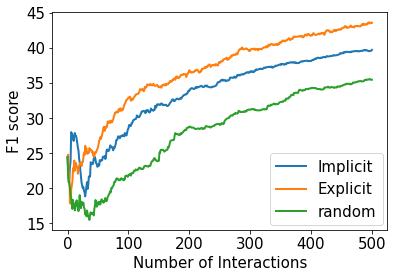

In [347]:
plt.rcParams.update({'font.size': 15})
d1["f1"].plot(linewidth=2, label="Implicit")
d2["f1"].plot(linewidth=2, label="Explicit")
d3["f1"].plot(linewidth=2, label="random")
#pd.Series([21.42]*(number_of_queries+1)).plot(linewidth=2, label="baseline")
plt.ylabel("F1 score")
plt.xlabel("Number of Interactions")
plt.legend(loc=(0.65,0.02))
plt.savefig('f1_score4.png', bbox_inches='tight',pad_inches = 0.1, dpi = 600)

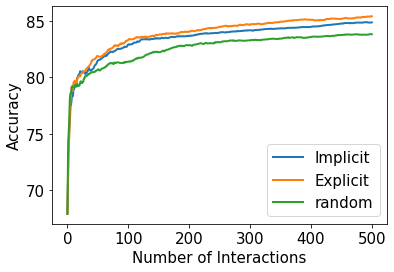

In [348]:
d1["accuracy"].plot(linewidth=2, label="Implicit")
d2["accuracy"].plot(linewidth=2, label="Explicit")
d3["accuracy"].plot(linewidth=2, label="random")
plt.ylabel("Accuracy")
plt.xlabel("Number of Interactions")
plt.legend()
plt.savefig('accuracy4.png', bbox_inches='tight',pad_inches = 0.1, dpi = 600)

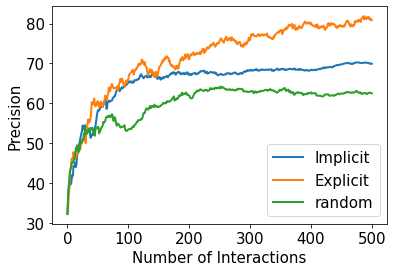

In [349]:
d1["precision"].plot(linewidth=2, label="Implicit")
d2["precision"].plot(linewidth=2, label="Explicit")
d3["precision"].plot(linewidth=2, label="random")
plt.ylabel("Precision")
plt.xlabel("Number of Interactions")
plt.legend()
plt.savefig('precision4.png', bbox_inches='tight',pad_inches = 0.1, dpi = 600)

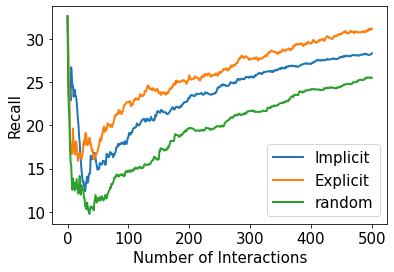

In [351]:
d1["recall"].plot(linewidth=2, label="Implicit")
d2["recall"].plot(linewidth=2, label="Explicit")
d3["recall"].plot(linewidth=2, label="random")
plt.ylabel("Recall")
plt.xlabel("Number of Interactions")
plt.legend()
plt.savefig('recall4.png', bbox_inches='tight',pad_inches = 0.1, dpi = 600)

In [352]:
res = {0.1:[], 0.3:[], 0.5:[], 0.7:[]} 

number_of_queries = 500
rounds = 10
#thresh_imp = 0.1

for r in range(rounds):
    print("\n\nRound ", r)
    imp_saturation = 0
    for thresh_imp in [0.1,0.3,0.5,0.7]:  
        X_lab, y_lab, X_unlab, X_test, y_test = initial_split(r)
        model = clf_fit(X_lab, y_lab)
        res[thresh_imp].append(evaluate(model, X_test, y_test))
        print("******    "+str(thresh_imp)+"    ********")

        for i in range(number_of_queries):
                q = []
                # finding the next word which is highlighted in the interface
                # print("Len X_unlab:  ",len(X_unlab))
                for j, w in enumerate(X_unlab):
                    if imp_saturation == 1:
                        break
                    
                    w = w.upper()
                    #if w in lookup:
                    #    print(i,w, round(model.predict_proba([lookup[w]])[0][1], 2))
                    if w in lookup and model.predict_proba([lookup[w]])[0][1]>thresh_imp:
                        #pred = model.predict([lookup[w]])[0]
                        #prob = model.predict_proba([lookup[w]])[0][1]
                        #print(w, prob, pred, oracle(w.lower(), r))
                        q.append(w.lower())
                        # if the word is really hard, add its alternative
                        if oracle(w.lower(), r) == 1:
                            alter = get_alternative(w, r)
                            #print("Alternative: ", alter)
                            if len(alter)>0:
                                q.append(alter)
                        break
                        
                    # if no word was found
                    if j==len(X_unlab)-1:
                        print(" ********   SATURATION ********")
                        imp_saturation = 1
                    
          
                X_lab.extend(q)
                # for each word in q, append its label
                for t in q:  
                    y_lab.append(oracle(t, r))
                
                #X_unlab = list(set(X_unlab)-set(q))
                X_unlab = [z for z in X_unlab if z not in q]
                model = clf_fit(X_lab, y_lab)
                #print("Query: ", i+1, " word: ", q[0], "  label: ",oracle(q[0], r), "len X_lab: ", len(X_lab))
                print("Round: ", r, " query: ", i+1, " word ", q)
                res[thresh_imp].append(evaluate(model, X_test, y_test))    



Round  0
******    0.1    ********
Round:  0  query:  1  word  ['good']
Round:  0  query:  2  word  ['morning']
Round:  0  query:  3  word  ['how']
Round:  0  query:  4  word  ['are']
Round:  0  query:  5  word  ['been']
Round:  0  query:  6  word  ['great', 'good']
Round:  0  query:  7  word  ['it']
Round:  0  query:  8  word  ['blown']
Round:  0  query:  9  word  ['by']
Round:  0  query:  10  word  ['which']
Round:  0  query:  11  word  ['relevant']
Round:  0  query:  12  word  ['to']
Round:  0  query:  13  word  ['extraordinary']
Round:  0  query:  14  word  ['creativity', 'inventiveness']
Round:  0  query:  15  word  ['here']
Round:  0  query:  16  word  ['idea']
Round:  0  query:  17  word  ['find']
Round:  0  query:  18  word  ['asked']
Round:  0  query:  19  word  ['curiously']
Round:  0  query:  20  word  ['but']
Round:  0  query:  21  word  ['can']
Round:  0  query:  22  word  ['face']
Round:  0  query:  23  word  ['deep']
Round:  0  query:  24  word  ['grasp', 'comprehend']

Round:  0  query:  185  word  ['frankincense', 'myrrh']
Round:  0  query:  186  word  ['confusing']
Round:  0  query:  187  word  ['fourth']
Round:  0  query:  188  word  ['frankly', 'honestly']
Round:  0  query:  189  word  ['dance']
Round:  0  query:  190  word  ['shared']
Round:  0  query:  191  word  ['inflation']
Round:  0  query:  192  word  ['airport']
Round:  0  query:  193  word  ['continuing']
Round:  0  query:  194  word  ['fresh', 'new']
Round:  0  query:  195  word  ['flourish']
Round:  0  query:  196  word  ['during']
Round:  0  query:  197  word  ['bunch']
Round:  0  query:  198  word  ['printed', 'paper']
Round:  0  query:  199  word  ['monterey']
Round:  0  query:  200  word  ['handwritten']
Round:  0  query:  201  word  ['friend', 'acquaintance']
Round:  0  query:  202  word  ['partner']
Round:  0  query:  203  word  ['congratulations']
Round:  0  query:  204  word  ['plan']
Round:  0  query:  205  word  ['crisis', 'turmoil']
Round:  0  query:  206  word  ['celebrate'

Round:  0  query:  361  word  ['striving']
Round:  0  query:  362  word  ['destroy']
Round:  0  query:  363  word  ['incredibly']
Round:  0  query:  364  word  ['graduate', 'alumnus']
Round:  0  query:  365  word  ['largest']
Round:  0  query:  366  word  ['traveled', 'cosmopolitan']
Round:  0  query:  367  word  ['places']
Round:  0  query:  368  word  ['imprisoned']
Round:  0  query:  369  word  ['brother', 'sister']
Round:  0  query:  370  word  ['crack', 'snap']
Round:  0  query:  371  word  ['porter']
Round:  0  query:  372  word  ['generic']
Round:  0  query:  373  word  ['dream', 'daydream']
Round:  0  query:  374  word  ['torch']
Round:  0  query:  375  word  ['prostitutes', 'whore']
Round:  0  query:  376  word  ['friends', 'acquaintance']
Round:  0  query:  377  word  ['landlords']
Round:  0  query:  378  word  ['degradation']
Round:  0  query:  379  word  ['construction']
Round:  0  query:  380  word  ['profits', 'earnings']
Round:  0  query:  381  word  ['greenway', 'parkwa

Round:  0  query:  32  word  ['squander']
Round:  0  query:  33  word  ['travel', 'journey']
Round:  0  query:  34  word  ['find']
Round:  0  query:  35  word  ['bearing']
Round:  0  query:  36  word  ['drama', 'play']
Round:  0  query:  37  word  ['children']
Round:  0  query:  38  word  ['now']
Round:  0  query:  39  word  ['transport', 'conveyance']
Round:  0  query:  40  word  ['part']
Round:  0  query:  41  word  ['transition', 'changeover']
Round:  0  query:  42  word  ['presentations', 'demonstration']
Round:  0  query:  43  word  ['education']
Round:  0  query:  44  word  ['problem', 'job']
Round:  0  query:  45  word  ['progressively', 'increasingly']
Round:  0  query:  46  word  ['professors', 'faculty']
Round:  0  query:  47  word  ['seven']
Round:  0  query:  48  word  ['probably', 'likely']
Round:  0  query:  49  word  ['profoundly', 'deeply']
Round:  0  query:  50  word  ['marvel']
Round:  0  query:  51  word  ['protracted', 'lengthy']
Round:  0  query:  52  word  ['parti

Round:  0  query:  204  word  ['pressing', 'urgent']
Round:  0  query:  205  word  ['trees', 'shrubs']
Round:  0  query:  206  word  ['greatest', 'biggest']
Round:  0  query:  207  word  ['created', 'formed']
Round:  0  query:  208  word  ['brisk', 'lively']
Round:  0  query:  209  word  ['primary', 'main']
Round:  0  query:  210  word  ['produces', 'develop']
Round:  0  query:  211  word  ['proportional', 'relative']
Round:  0  query:  212  word  ['construct']
Round:  0  query:  213  word  ['striving']
Round:  0  query:  214  word  ['destroy']
Round:  0  query:  215  word  ['graduate', 'alumnus']
Round:  0  query:  216  word  ['quiet']
Round:  0  query:  217  word  ['traveled', 'cosmopolitan']
Round:  0  query:  218  word  ['places']
Round:  0  query:  219  word  ['imprisoned']
Round:  0  query:  220  word  ['brother', 'sister']
Round:  0  query:  221  word  ['crack', 'snap']
Round:  0  query:  222  word  ['dream', 'daydream']
Round:  0  query:  223  word  ['torch']
Round:  0  query: 

Round:  0  query:  368  word  ['transform', 'reshape']
Round:  0  query:  369  word  ['kindergarten']
Round:  0  query:  370  word  ['previously', 'originally']
Round:  0  query:  371  word  ['traverse', 'span']
Round:  0  query:  372  word  ['processions', 'parades']
Round:  0  query:  373  word  ['trapped', 'cornered']
Round:  0  query:  374  word  ['procession', 'parade']
Round:  0  query:  375  word  ['greek', 'hellenic']
Round:  0  query:  376  word  ['providing', 'supplying']
Round:  0  query:  377  word  ['pro', 'favoring']
Round:  0  query:  378  word  ['credible', 'plausible']
Round:  0  query:  379  word  ['broke', 'bust']
Round:  0  query:  380  word  ['transfer', 'reassign']
Round:  0  query:  381  word  ['gradually', 'slowly']
Round:  0  query:  382  word  ['brilliantly', 'superbly']
Round:  0  query:  383  word  ['curator']
Round:  0  query:  384  word  ['traced', 'copied']
Round:  0  query:  385  word  ['proposal', 'plan']
Round:  0  query:  386  word  ['proposals', 'ame

Round:  0  query:  33  word  ['drive', 'push']
Round:  0  query:  34  word  ['beauty']
Round:  0  query:  35  word  ['drawer', 'desk']
Round:  0  query:  36  word  ['hardware']
Round:  0  query:  37  word  ['grant', 'allot']
Round:  0  query:  38  word  ['brought', 'came']
Round:  0  query:  39  word  ['bronx', 'philly']
Round:  0  query:  40  word  ['brilliant', 'superb']
Round:  0  query:  41  word  ['blank']
Round:  0  query:  42  word  ['greatest', 'biggest']
Round:  0  query:  43  word  ['brisk', 'lively']
Round:  0  query:  44  word  ['dream', 'daydream']
Round:  0  query:  45  word  ['greenway', 'parkway']
Round:  0  query:  46  word  ['breathe', 'emit']
Round:  0  query:  47  word  ['bringing', 'delivery']
Round:  0  query:  48  word  ['during']
Round:  0  query:  49  word  ['greater', 'larger']
Round:  0  query:  50  word  ['drug', 'dose']
Round:  0  query:  51  word  ['dropped', 'born']
Round:  0  query:  52  word  ['breakfast', 'dinner']
Round:  0  query:  53  word  ['groups

Round:  0  query:  198  word  ['nonprofit']
Round:  0  query:  199  word  ['produced', 'delivered']
Round:  0  query:  200  word  ['entrepreneurs']
Round:  0  query:  201  word  ['crazy', 'mad']
Round:  0  query:  202  word  ['described']
Round:  0  query:  203  word  ['prayer', 'communion']
Round:  0  query:  204  word  ['christmas']
Round:  0  query:  205  word  ['crossing', 'intersection']
Round:  0  query:  206  word  ['presidents', 'chairman']
Round:  0  query:  207  word  ['presented', 'given']
Round:  0  query:  208  word  ['prostitutes', 'whore']
Round:  0  query:  209  word  ['parties']
Round:  0  query:  210  word  ['presents', 'introduce']
Round:  0  query:  211  word  ['credit', 'recognition']
Round:  0  query:  212  word  ['protect', 'safeguard']
Round:  0  query:  213  word  ['proportional', 'relative']
Round:  0  query:  214  word  ['criteria', 'requirements']
Round:  0  query:  215  word  ['clear']
Round:  0  query:  216  word  ['playground']
Round:  0  query:  217  wor

Round:  0  query:  357  word  ['projecting', 'sticking']
Round:  0  query:  358  word  ['brainstorms', 'insight']
Round:  0  query:  359  word  ['traveling', 'touring']
Round:  0  query:  360  word  ['prediction', 'forecasting']
Round:  0  query:  361  word  ['brin', 'bern']
Round:  0  query:  362  word  ['declared']
Round:  0  query:  363  word  ['predilection', 'penchant']
Round:  0  query:  364  word  ['pregnant', 'expectant']
Round:  0  query:  365  word  ['trains', 'caravan']
Round:  0  query:  366  word  ['prevalent', 'rife']
Round:  0  query:  367  word  ['draw', 'attract']
Round:  0  query:  368  word  ['programme', 'plan']
Round:  0  query:  369  word  ['spread']
Round:  0  query:  370  word  ['prevent', 'forestall']
Round:  0  query:  371  word  ['preventing', 'deterring']
Round:  0  query:  372  word  ['progress', 'advancement']
Round:  0  query:  373  word  ['transmission', 'infection']
Round:  0  query:  374  word  ['grandchildren', 'nephews']
Round:  0  query:  375  word 

Round:  0  query:  14  word  ['grew', 'rose']
Round:  0  query:  15  word  ['brunette', 'tanned']
Round:  0  query:  16  word  ['break', 'burst']
Round:  0  query:  17  word  ['grant', 'allot']
Round:  0  query:  18  word  ['brought', 'came']
Round:  0  query:  19  word  ['broadway', 'theater']
Round:  0  query:  20  word  ['broader', 'wider']
Round:  0  query:  21  word  ['bronx', 'philly']
Round:  0  query:  22  word  ['blank']
Round:  0  query:  23  word  ['drawer', 'desk']
Round:  0  query:  24  word  ['drawing', 'lottery']
Round:  0  query:  25  word  ['boards']
Round:  0  query:  26  word  ['greatest', 'biggest']
Round:  0  query:  27  word  ['brisk', 'lively']
Round:  0  query:  28  word  ['greenway', 'parkway']
Round:  0  query:  29  word  ['breathe', 'emit']
Round:  0  query:  30  word  ['bringing', 'delivery']
Round:  0  query:  31  word  ['greater', 'larger']
Round:  0  query:  32  word  ['breakfast', 'dinner']
Round:  0  query:  33  word  ['groups', 'radical']
Round:  0  qu

Round:  0  query:  179  word  ['traced', 'copied']
Round:  0  query:  180  word  ['destroy']
Round:  0  query:  181  word  ['preserving', 'conserving']
Round:  0  query:  182  word  ['crick', 'rick']
Round:  0  query:  183  word  ['crack', 'snap']
Round:  0  query:  184  word  ['part']
Round:  0  query:  185  word  ['trillion', 'billion']
Round:  0  query:  186  word  ['treating', 'dealing']
Round:  0  query:  187  word  ['contrary']
Round:  0  query:  188  word  ['practice', 'exercise']
Round:  0  query:  189  word  ['pretend', 'feign']
Round:  0  query:  190  word  ['crying', 'weeping']
Round:  0  query:  191  word  ['priest', 'clergyman']
Round:  0  query:  192  word  ['troops', 'soldiers']
Round:  0  query:  193  word  ['criticized', 'lambasted']
Round:  0  query:  194  word  ['christine']
Round:  0  query:  195  word  ['traveling', 'touring']
Round:  0  query:  196  word  ['playground']
Round:  0  query:  197  word  ['declared']
Round:  0  query:  198  word  ['pregnant', 'expectan

Round:  0  query:  337  word  ['prescription', 'medication']
Round:  0  query:  338  word  ['crystals', 'quartz']
Round:  0  query:  339  word  ['christians']
Round:  0  query:  340  word  ['grabs', 'snatch']
Round:  0  query:  341  word  ['draft', 'blueprint']
Round:  0  query:  342  word  ['breast', 'boob']
Round:  0  query:  343  word  ['progression', 'advancement']
Round:  0  query:  344  word  ['tracking', 'monitoring']
Round:  0  query:  345  word  ['tracing', 'identifying']
Round:  0  query:  346  word  ['prove', 'demonstrate']
Round:  0  query:  347  word  ['prevailed', 'reigned']
Round:  0  query:  348  word  ['british', 'england']
Round:  0  query:  349  word  ['pressure', 'force']
Round:  0  query:  350  word  ['trance', 'enchantment']
Round:  0  query:  351  word  ['promising', 'likely']
Round:  0  query:  352  word  ['tries', 'attempts']
Round:  0  query:  353  word  ['crash', 'collision']
Round:  0  query:  354  word  ['crashed', 'collided']
Round:  0  query:  355  word  

Round:  0  query:  489  word  ['primitive', 'archaic']
Round:  0  query:  490  word  ['crystalline', 'lucid']
Round:  0  query:  491  word  ['productive', 'successful']
Round:  0  query:  492  word  ['contributors']
Round:  0  query:  493  word  ['preventative', 'deterrent']
Round:  0  query:  494  word  ['deprived']
Round:  0  query:  495  word  ['drilling', 'boring']
Round:  0  query:  496  word  ['transistor', 'semiconductor']
Round:  0  query:  497  word  ['transfer', 'reassign']
Round:  0  query:  498  word  ['drexler', 'gooden']
Round:  0  query:  499  word  ['practical', 'useful']
Round:  0  query:  500  word  ['critical', 'vital']


Round  1
******    0.1    ********
Round:  1  query:  1  word  ['good']
Round:  1  query:  2  word  ['morning']
Round:  1  query:  3  word  ['how']
Round:  1  query:  4  word  ['are']
Round:  1  query:  5  word  ['been']
Round:  1  query:  6  word  ['great']
Round:  1  query:  7  word  ['thing']
Round:  1  query:  8  word  ['fact']
Round:  1  query:

Round:  1  query:  176  word  ['costs']
Round:  1  query:  177  word  ['striving', 'pains']
Round:  1  query:  178  word  ['triggered']
Round:  1  query:  179  word  ['understand']
Round:  1  query:  180  word  ['fading']
Round:  1  query:  181  word  ['stable', 'balanced']
Round:  1  query:  182  word  ['trips']
Round:  1  query:  183  word  ['louder']
Round:  1  query:  184  word  ['slave']
Round:  1  query:  185  word  ['notwithstanding']
Round:  1  query:  186  word  ['construction']
Round:  1  query:  187  word  ['state', 'commonwealth']
Round:  1  query:  188  word  ['spearheaded']
Round:  1  query:  189  word  ['landscape']
Round:  1  query:  190  word  ['constructed']
Round:  1  query:  191  word  ['stewardship', 'leadership']
Round:  1  query:  192  word  ['skills']
Round:  1  query:  193  word  ['stake', 'interest']
Round:  1  query:  194  word  ['stakeholders', 'representatives']
Round:  1  query:  195  word  ['habitats']
Round:  1  query:  196  word  ['taxpayers']
Round:  1

Round:  1  query:  352  word  ['steven', 'carlos']
Round:  1  query:  353  word  ['studied', 'designed']
Round:  1  query:  354  word  ['strongest', 'sharpest']
Round:  1  query:  355  word  ['scars']
Round:  1  query:  356  word  ['spike']
Round:  1  query:  357  word  ['flu', 'influenza']
Round:  1  query:  358  word  ['flown', 'airlifted']
Round:  1  query:  359  word  ['slowly']
Round:  1  query:  360  word  ['spills']
Round:  1  query:  361  word  ['stretch', 'extend']
Round:  1  query:  362  word  ['shorts']
Round:  1  query:  363  word  ['reports']
Round:  1  query:  364  word  ['stretching', 'wide']
Round:  1  query:  365  word  ['slaughtering']
Round:  1  query:  366  word  ['tasted']
Round:  1  query:  367  word  ['stroke', 'shot']
Round:  1  query:  368  word  ['sets']
Round:  1  query:  369  word  ['stepped', 'came']
Round:  1  query:  370  word  ['strategic', 'important']
Round:  1  query:  371  word  ['seeding']
Round:  1  query:  372  word  ['steadily', 'rapidly']
Round:

Round:  1  query:  33  word  []
Round:  1  query:  34  word  []
Round:  1  query:  35  word  []
Round:  1  query:  36  word  []
Round:  1  query:  37  word  []
Round:  1  query:  38  word  []
Round:  1  query:  39  word  []
Round:  1  query:  40  word  []
Round:  1  query:  41  word  []
Round:  1  query:  42  word  []
Round:  1  query:  43  word  []
Round:  1  query:  44  word  []
Round:  1  query:  45  word  []
Round:  1  query:  46  word  []
Round:  1  query:  47  word  []
Round:  1  query:  48  word  []
Round:  1  query:  49  word  []
Round:  1  query:  50  word  []
Round:  1  query:  51  word  []
Round:  1  query:  52  word  []
Round:  1  query:  53  word  []
Round:  1  query:  54  word  []
Round:  1  query:  55  word  []
Round:  1  query:  56  word  []
Round:  1  query:  57  word  []
Round:  1  query:  58  word  []
Round:  1  query:  59  word  []
Round:  1  query:  60  word  []
Round:  1  query:  61  word  []
Round:  1  query:  62  word  []
Round:  1  query:  63  word  []
Round:  

Round:  1  query:  284  word  []
Round:  1  query:  285  word  []
Round:  1  query:  286  word  []
Round:  1  query:  287  word  []
Round:  1  query:  288  word  []
Round:  1  query:  289  word  []
Round:  1  query:  290  word  []
Round:  1  query:  291  word  []
Round:  1  query:  292  word  []
Round:  1  query:  293  word  []
Round:  1  query:  294  word  []
Round:  1  query:  295  word  []
Round:  1  query:  296  word  []
Round:  1  query:  297  word  []
Round:  1  query:  298  word  []
Round:  1  query:  299  word  []
Round:  1  query:  300  word  []
Round:  1  query:  301  word  []
Round:  1  query:  302  word  []
Round:  1  query:  303  word  []
Round:  1  query:  304  word  []
Round:  1  query:  305  word  []
Round:  1  query:  306  word  []
Round:  1  query:  307  word  []
Round:  1  query:  308  word  []
Round:  1  query:  309  word  []
Round:  1  query:  310  word  []
Round:  1  query:  311  word  []
Round:  1  query:  312  word  []
Round:  1  query:  313  word  []
Round:  1 

Round:  1  query:  33  word  []
Round:  1  query:  34  word  []
Round:  1  query:  35  word  []
Round:  1  query:  36  word  []
Round:  1  query:  37  word  []
Round:  1  query:  38  word  []
Round:  1  query:  39  word  []
Round:  1  query:  40  word  []
Round:  1  query:  41  word  []
Round:  1  query:  42  word  []
Round:  1  query:  43  word  []
Round:  1  query:  44  word  []
Round:  1  query:  45  word  []
Round:  1  query:  46  word  []
Round:  1  query:  47  word  []
Round:  1  query:  48  word  []
Round:  1  query:  49  word  []
Round:  1  query:  50  word  []
Round:  1  query:  51  word  []
Round:  1  query:  52  word  []
Round:  1  query:  53  word  []
Round:  1  query:  54  word  []
Round:  1  query:  55  word  []
Round:  1  query:  56  word  []
Round:  1  query:  57  word  []
Round:  1  query:  58  word  []
Round:  1  query:  59  word  []
Round:  1  query:  60  word  []
Round:  1  query:  61  word  []
Round:  1  query:  62  word  []
Round:  1  query:  63  word  []
Round:  

Round:  1  query:  284  word  []
Round:  1  query:  285  word  []
Round:  1  query:  286  word  []
Round:  1  query:  287  word  []
Round:  1  query:  288  word  []
Round:  1  query:  289  word  []
Round:  1  query:  290  word  []
Round:  1  query:  291  word  []
Round:  1  query:  292  word  []
Round:  1  query:  293  word  []
Round:  1  query:  294  word  []
Round:  1  query:  295  word  []
Round:  1  query:  296  word  []
Round:  1  query:  297  word  []
Round:  1  query:  298  word  []
Round:  1  query:  299  word  []
Round:  1  query:  300  word  []
Round:  1  query:  301  word  []
Round:  1  query:  302  word  []
Round:  1  query:  303  word  []
Round:  1  query:  304  word  []
Round:  1  query:  305  word  []
Round:  1  query:  306  word  []
Round:  1  query:  307  word  []
Round:  1  query:  308  word  []
Round:  1  query:  309  word  []
Round:  1  query:  310  word  []
Round:  1  query:  311  word  []
Round:  1  query:  312  word  []
Round:  1  query:  313  word  []
Round:  1 

Round:  1  query:  33  word  []
Round:  1  query:  34  word  []
Round:  1  query:  35  word  []
Round:  1  query:  36  word  []
Round:  1  query:  37  word  []
Round:  1  query:  38  word  []
Round:  1  query:  39  word  []
Round:  1  query:  40  word  []
Round:  1  query:  41  word  []
Round:  1  query:  42  word  []
Round:  1  query:  43  word  []
Round:  1  query:  44  word  []
Round:  1  query:  45  word  []
Round:  1  query:  46  word  []
Round:  1  query:  47  word  []
Round:  1  query:  48  word  []
Round:  1  query:  49  word  []
Round:  1  query:  50  word  []
Round:  1  query:  51  word  []
Round:  1  query:  52  word  []
Round:  1  query:  53  word  []
Round:  1  query:  54  word  []
Round:  1  query:  55  word  []
Round:  1  query:  56  word  []
Round:  1  query:  57  word  []
Round:  1  query:  58  word  []
Round:  1  query:  59  word  []
Round:  1  query:  60  word  []
Round:  1  query:  61  word  []
Round:  1  query:  62  word  []
Round:  1  query:  63  word  []
Round:  

Round:  1  query:  284  word  []
Round:  1  query:  285  word  []
Round:  1  query:  286  word  []
Round:  1  query:  287  word  []
Round:  1  query:  288  word  []
Round:  1  query:  289  word  []
Round:  1  query:  290  word  []
Round:  1  query:  291  word  []
Round:  1  query:  292  word  []
Round:  1  query:  293  word  []
Round:  1  query:  294  word  []
Round:  1  query:  295  word  []
Round:  1  query:  296  word  []
Round:  1  query:  297  word  []
Round:  1  query:  298  word  []
Round:  1  query:  299  word  []
Round:  1  query:  300  word  []
Round:  1  query:  301  word  []
Round:  1  query:  302  word  []
Round:  1  query:  303  word  []
Round:  1  query:  304  word  []
Round:  1  query:  305  word  []
Round:  1  query:  306  word  []
Round:  1  query:  307  word  []
Round:  1  query:  308  word  []
Round:  1  query:  309  word  []
Round:  1  query:  310  word  []
Round:  1  query:  311  word  []
Round:  1  query:  312  word  []
Round:  1  query:  313  word  []
Round:  1 

Round:  2  query:  27  word  ['to']
Round:  2  query:  28  word  ['evidence']
Round:  2  query:  29  word  ['all', 'every']
Round:  2  query:  30  word  ['presentations', 'demonstration']
Round:  2  query:  31  word  ['and']
Round:  2  query:  32  word  ['here']
Round:  2  query:  33  word  ['the']
Round:  2  query:  34  word  ['second']
Round:  2  query:  35  word  ['us']
Round:  2  query:  36  word  ['variety']
Round:  2  query:  37  word  ['place', 'spot']
Round:  2  query:  38  word  ['want']
Round:  2  query:  39  word  ['no']
Round:  2  query:  40  word  ['idea']
Round:  2  query:  41  word  ['terms']
Round:  2  query:  42  word  ['this']
Round:  2  query:  43  word  ['play', 'run']
Round:  2  query:  44  word  ['put']
Round:  2  query:  45  word  ['an']
Round:  2  query:  46  word  ['interest']
Round:  2  query:  47  word  ['education']
Round:  2  query:  48  word  ['actually']
Round:  2  query:  49  word  ['interesting']
Round:  2  query:  50  word  ['party']
Round:  2  query: 

Round:  2  query:  214  word  ['was']
Round:  2  query:  215  word  ['brain', 'psyche']
Round:  2  query:  216  word  ['compartments']
Round:  2  query:  217  word  ['corpus']
Round:  2  query:  218  word  ['disciplinary']
Round:  2  query:  219  word  ['following']
Round:  2  query:  220  word  ['heart']
Round:  2  query:  221  word  ['door']
Round:  2  query:  222  word  ['please', 'delight']
Round:  2  query:  223  word  ['trying', 'hard']
Round:  2  query:  224  word  ['fry', 'tike']
Round:  2  query:  225  word  ['old', 'aged']
Round:  2  query:  226  word  ['tree', 'conifer']
Round:  2  query:  227  word  ['prompted', 'spurred']
Round:  2  query:  228  word  ['annoying']
Round:  2  query:  229  word  ['carry']
Round:  2  query:  230  word  ['conversation']
Round:  2  query:  231  word  ['choreographer']
Round:  2  query:  232  word  ['board']
Round:  2  query:  233  word  ['disorder']
Round:  2  query:  234  word  ['concentrate']
Round:  2  query:  235  word  ['problems', 'job']


Round:  2  query:  393  word  ['solve']
Round:  2  query:  394  word  ['persuasion']
Round:  2  query:  395  word  ['spring']
Round:  2  query:  396  word  ['presently', 'currently']
Round:  2  query:  397  word  ['includes']
Round:  2  query:  398  word  ['brand', 'marque']
Round:  2  query:  399  word  ['partisan']
Round:  2  query:  400  word  ['influence']
Round:  2  query:  401  word  ['democrats']
Round:  2  query:  402  word  ['appreciate']
Round:  2  query:  403  word  ['silence']
Round:  2  query:  404  word  ['ignored']
Round:  2  query:  405  word  ['grew', 'rose']
Round:  2  query:  406  word  ['mold']
Round:  2  query:  407  word  ['crashed', 'collided']
Round:  2  query:  408  word  ['dreams', 'daydream']
Round:  2  query:  409  word  ['fantasize']
Round:  2  query:  410  word  ['crashes', 'collision']
Round:  2  query:  411  word  ['extremely']
Round:  2  query:  412  word  ['low']
Round:  2  query:  413  word  ['pray', 'implore']
Round:  2  query:  414  word  ['trained'

Round:  2  query:  73  word  ['parts']
Round:  2  query:  74  word  ['struck']
Round:  2  query:  75  word  ['drama', 'melodrama']
Round:  2  query:  76  word  ['t']
Round:  2  query:  77  word  ['come']
Round:  2  query:  78  word  ['planet', 'satellite']
Round:  2  query:  79  word  ['progressively', 'increasingly']
Round:  2  query:  80  word  ['public']
Round:  2  query:  81  word  ['conclude']
Round:  2  query:  82  word  ['brownie', 'imp']
Round:  2  query:  83  word  ['produce', 'develop']
Round:  2  query:  84  word  ['professors', 'faculty']
Round:  2  query:  85  word  ['travel', 'journey']
Round:  2  query:  86  word  ['mark']
Round:  2  query:  87  word  ['transport', 'conveyance']
Round:  2  query:  88  word  ['last']
Round:  2  query:  89  word  ['grown', 'mature']
Round:  2  query:  90  word  ['probably', 'likely']
Round:  2  query:  91  word  ['grounds', 'reason']
Round:  2  query:  92  word  ['profoundly', 'deeply']
Round:  2  query:  93  word  ['found']
Round:  2  que

Round:  2  query:  244  word  ['club', 'lodge']
Round:  2  query:  245  word  ['processor', 'mainframe']
Round:  2  query:  246  word  ['create', 'make']
Round:  2  query:  247  word  ['principle', 'rationale']
Round:  2  query:  248  word  ['break', 'burst']
Round:  2  query:  249  word  ['cross', 'mark']
Round:  2  query:  250  word  ['trash', 'rubbish']
Round:  2  query:  251  word  ['countries']
Round:  2  query:  252  word  ['scroll']
Round:  2  query:  253  word  ['clicking', 'selecting']
Round:  2  query:  254  word  ['quick']
Round:  2  query:  255  word  ['killer']
Round:  2  query:  256  word  ['printer', 'copier']
Round:  2  query:  257  word  ['print', 'publish']
Round:  2  query:  258  word  ['flying', 'winged']
Round:  2  query:  259  word  ['blank', 'empty']
Round:  2  query:  260  word  ['press', 'push']
Round:  2  query:  261  word  ['praise', 'kudos']
Round:  2  query:  262  word  ['dying']
Round:  2  query:  263  word  ['beautifully']
Round:  2  query:  264  word  ['

Round:  2  query:  409  word  ['treatment', 'discussion']
Round:  2  query:  410  word  ['barriers']
Round:  2  query:  411  word  ['brazil', 'colombia']
Round:  2  query:  412  word  ['trails', 'chase']
Round:  2  query:  413  word  ['oil']
Round:  2  query:  414  word  ['prices', 'cost']
Round:  2  query:  415  word  ['quintile']
Round:  2  query:  416  word  ['publicly']
Round:  2  query:  417  word  ['nonprofit']
Round:  2  query:  418  word  ['appropriate']
Round:  2  query:  419  word  ['produced', 'delivered']
Round:  2  query:  420  word  ['free', 'complimentary']
Round:  2  query:  421  word  ['entrepreneurs']
Round:  2  query:  422  word  ['flowers', 'peak']
Round:  2  query:  423  word  ['slower', 'weaker']
Round:  2  query:  424  word  ['our']
Round:  2  query:  425  word  ['slow', 'decelerate']
Round:  2  query:  426  word  ['throw']
Round:  2  query:  427  word  ['lower']
Round:  2  query:  428  word  ['crucial', 'pivotal']
Round:  2  query:  429  word  ['clever', 'ingeni

Round:  2  query:  75  word  ['farm']
Round:  2  query:  76  word  ['projection', 'jutting']
Round:  2  query:  77  word  ['explosion']
Round:  2  query:  78  word  ['carbon']
Round:  2  query:  79  word  ['green', 'colored']
Round:  2  query:  80  word  ['grateful', 'thankful']
Round:  2  query:  81  word  ['crisis', 'turmoil']
Round:  2  query:  82  word  ['careful']
Round:  2  query:  83  word  ['temperature']
Round:  2  query:  84  word  ['branding', 'labeling']
Round:  2  query:  85  word  ['arcane', 'esoteric']
Round:  2  query:  86  word  ['calculate']
Round:  2  query:  87  word  ['click', 'tick']
Round:  2  query:  88  word  ['closed', 'shut']
Round:  2  query:  89  word  ['presently', 'currently']
Round:  2  query:  90  word  ['brand', 'marque']
Round:  2  query:  91  word  ['grew', 'rose']
Round:  2  query:  92  word  ['crashed', 'collided']
Round:  2  query:  93  word  ['crashes', 'collision']
Round:  2  query:  94  word  ['precisely', 'exactly']
Round:  2  query:  95  word

Round:  2  query:  238  word  ['trees', 'shrubs']
Round:  2  query:  239  word  ['true', 'genuine']
Round:  2  query:  240  word  ['treat', 'handle']
Round:  2  query:  241  word  ['trucks', 'vehicles']
Round:  2  query:  242  word  ['countries']
Round:  2  query:  243  word  ['truth', 'verity']
Round:  2  query:  244  word  ['dream', 'daydream']
Round:  2  query:  245  word  ['dreams', 'daydream']
Round:  2  query:  246  word  ['trying', 'hard']
Round:  2  query:  247  word  ['drawing', 'lottery']
Round:  2  query:  248  word  ['train', 'caravan']
Round:  2  query:  249  word  ['trained', 'skilled']
Round:  2  query:  250  word  ['strain']
Round:  2  query:  251  word  ['drawer', 'desk']
Round:  2  query:  252  word  ['truck', 'van']
Round:  2  query:  253  word  ['struck']
Round:  2  query:  254  word  ['principle', 'rationale']
Round:  2  query:  255  word  ['principles', 'rationale']
Round:  2  query:  256  word  ['cult']
Round:  2  query:  257  word  ['contribute']
Round:  2  quer

Round:  2  query:  397  word  ['flat', 'thin']
Round:  2  query:  398  word  ['paintbrush']
Round:  2  query:  399  word  ['christianity']
Round:  2  query:  400  word  ['christians']
Round:  2  query:  401  word  ['practitioner', 'physician']
Round:  2  query:  402  word  ['translations', 'version']
Round:  2  query:  403  word  ['fresh', 'new']
Round:  2  query:  404  word  ['brief', 'abbreviated']
Round:  2  query:  405  word  ['groening', 'animator']
Round:  2  query:  406  word  ['flood', 'deluge']
Round:  2  query:  407  word  ['girlfriends']
Round:  2  query:  408  word  ['ground', 'soil']
Round:  2  query:  409  word  ['trillion', 'billion']
Round:  2  query:  410  word  ['treating', 'dealing']
Round:  2  query:  411  word  ['benchmark']
Round:  2  query:  412  word  ['practice', 'exercise']
Round:  2  query:  413  word  ['breakdown', 'dislocation']
Round:  2  query:  414  word  ['pretend', 'feign']
Round:  2  query:  415  word  ['crying', 'weeping']
Round:  2  query:  416  wor

Round:  2  query:  87  word  []
Round:  2  query:  88  word  []
Round:  2  query:  89  word  []
Round:  2  query:  90  word  []
Round:  2  query:  91  word  []
Round:  2  query:  92  word  []
Round:  2  query:  93  word  []
Round:  2  query:  94  word  []
Round:  2  query:  95  word  []
Round:  2  query:  96  word  []
Round:  2  query:  97  word  []
Round:  2  query:  98  word  []
Round:  2  query:  99  word  []
Round:  2  query:  100  word  []
Round:  2  query:  101  word  []
Round:  2  query:  102  word  []
Round:  2  query:  103  word  []
Round:  2  query:  104  word  []
Round:  2  query:  105  word  []
Round:  2  query:  106  word  []
Round:  2  query:  107  word  []
Round:  2  query:  108  word  []
Round:  2  query:  109  word  []
Round:  2  query:  110  word  []
Round:  2  query:  111  word  []
Round:  2  query:  112  word  []
Round:  2  query:  113  word  []
Round:  2  query:  114  word  []
Round:  2  query:  115  word  []
Round:  2  query:  116  word  []
Round:  2  query:  117 

Round:  2  query:  336  word  []
Round:  2  query:  337  word  []
Round:  2  query:  338  word  []
Round:  2  query:  339  word  []
Round:  2  query:  340  word  []
Round:  2  query:  341  word  []
Round:  2  query:  342  word  []
Round:  2  query:  343  word  []
Round:  2  query:  344  word  []
Round:  2  query:  345  word  []
Round:  2  query:  346  word  []
Round:  2  query:  347  word  []
Round:  2  query:  348  word  []
Round:  2  query:  349  word  []
Round:  2  query:  350  word  []
Round:  2  query:  351  word  []
Round:  2  query:  352  word  []
Round:  2  query:  353  word  []
Round:  2  query:  354  word  []
Round:  2  query:  355  word  []
Round:  2  query:  356  word  []
Round:  2  query:  357  word  []
Round:  2  query:  358  word  []
Round:  2  query:  359  word  []
Round:  2  query:  360  word  []
Round:  2  query:  361  word  []
Round:  2  query:  362  word  []
Round:  2  query:  363  word  []
Round:  2  query:  364  word  []
Round:  2  query:  365  word  []
Round:  2 

Round:  3  query:  73  word  []
Round:  3  query:  74  word  []
Round:  3  query:  75  word  []
Round:  3  query:  76  word  []
Round:  3  query:  77  word  []
Round:  3  query:  78  word  []
Round:  3  query:  79  word  []
Round:  3  query:  80  word  []
Round:  3  query:  81  word  []
Round:  3  query:  82  word  []
Round:  3  query:  83  word  []
Round:  3  query:  84  word  []
Round:  3  query:  85  word  []
Round:  3  query:  86  word  []
Round:  3  query:  87  word  []
Round:  3  query:  88  word  []
Round:  3  query:  89  word  []
Round:  3  query:  90  word  []
Round:  3  query:  91  word  []
Round:  3  query:  92  word  []
Round:  3  query:  93  word  []
Round:  3  query:  94  word  []
Round:  3  query:  95  word  []
Round:  3  query:  96  word  []
Round:  3  query:  97  word  []
Round:  3  query:  98  word  []
Round:  3  query:  99  word  []
Round:  3  query:  100  word  []
Round:  3  query:  101  word  []
Round:  3  query:  102  word  []
Round:  3  query:  103  word  []
Roun

Round:  3  query:  323  word  []
Round:  3  query:  324  word  []
Round:  3  query:  325  word  []
Round:  3  query:  326  word  []
Round:  3  query:  327  word  []
Round:  3  query:  328  word  []
Round:  3  query:  329  word  []
Round:  3  query:  330  word  []
Round:  3  query:  331  word  []
Round:  3  query:  332  word  []
Round:  3  query:  333  word  []
Round:  3  query:  334  word  []
Round:  3  query:  335  word  []
Round:  3  query:  336  word  []
Round:  3  query:  337  word  []
Round:  3  query:  338  word  []
Round:  3  query:  339  word  []
Round:  3  query:  340  word  []
Round:  3  query:  341  word  []
Round:  3  query:  342  word  []
Round:  3  query:  343  word  []
Round:  3  query:  344  word  []
Round:  3  query:  345  word  []
Round:  3  query:  346  word  []
Round:  3  query:  347  word  []
Round:  3  query:  348  word  []
Round:  3  query:  349  word  []
Round:  3  query:  350  word  []
Round:  3  query:  351  word  []
Round:  3  query:  352  word  []
Round:  3 

Round:  3  query:  73  word  []
Round:  3  query:  74  word  []
Round:  3  query:  75  word  []
Round:  3  query:  76  word  []
Round:  3  query:  77  word  []
Round:  3  query:  78  word  []
Round:  3  query:  79  word  []
Round:  3  query:  80  word  []
Round:  3  query:  81  word  []
Round:  3  query:  82  word  []
Round:  3  query:  83  word  []
Round:  3  query:  84  word  []
Round:  3  query:  85  word  []
Round:  3  query:  86  word  []
Round:  3  query:  87  word  []
Round:  3  query:  88  word  []
Round:  3  query:  89  word  []
Round:  3  query:  90  word  []
Round:  3  query:  91  word  []
Round:  3  query:  92  word  []
Round:  3  query:  93  word  []
Round:  3  query:  94  word  []
Round:  3  query:  95  word  []
Round:  3  query:  96  word  []
Round:  3  query:  97  word  []
Round:  3  query:  98  word  []
Round:  3  query:  99  word  []
Round:  3  query:  100  word  []
Round:  3  query:  101  word  []
Round:  3  query:  102  word  []
Round:  3  query:  103  word  []
Roun

Round:  3  query:  323  word  []
Round:  3  query:  324  word  []
Round:  3  query:  325  word  []
Round:  3  query:  326  word  []
Round:  3  query:  327  word  []
Round:  3  query:  328  word  []
Round:  3  query:  329  word  []
Round:  3  query:  330  word  []
Round:  3  query:  331  word  []
Round:  3  query:  332  word  []
Round:  3  query:  333  word  []
Round:  3  query:  334  word  []
Round:  3  query:  335  word  []
Round:  3  query:  336  word  []
Round:  3  query:  337  word  []
Round:  3  query:  338  word  []
Round:  3  query:  339  word  []
Round:  3  query:  340  word  []
Round:  3  query:  341  word  []
Round:  3  query:  342  word  []
Round:  3  query:  343  word  []
Round:  3  query:  344  word  []
Round:  3  query:  345  word  []
Round:  3  query:  346  word  []
Round:  3  query:  347  word  []
Round:  3  query:  348  word  []
Round:  3  query:  349  word  []
Round:  3  query:  350  word  []
Round:  3  query:  351  word  []
Round:  3  query:  352  word  []
Round:  3 

Round:  3  query:  73  word  []
Round:  3  query:  74  word  []
Round:  3  query:  75  word  []
Round:  3  query:  76  word  []
Round:  3  query:  77  word  []
Round:  3  query:  78  word  []
Round:  3  query:  79  word  []
Round:  3  query:  80  word  []
Round:  3  query:  81  word  []
Round:  3  query:  82  word  []
Round:  3  query:  83  word  []
Round:  3  query:  84  word  []
Round:  3  query:  85  word  []
Round:  3  query:  86  word  []
Round:  3  query:  87  word  []
Round:  3  query:  88  word  []
Round:  3  query:  89  word  []
Round:  3  query:  90  word  []
Round:  3  query:  91  word  []
Round:  3  query:  92  word  []
Round:  3  query:  93  word  []
Round:  3  query:  94  word  []
Round:  3  query:  95  word  []
Round:  3  query:  96  word  []
Round:  3  query:  97  word  []
Round:  3  query:  98  word  []
Round:  3  query:  99  word  []
Round:  3  query:  100  word  []
Round:  3  query:  101  word  []
Round:  3  query:  102  word  []
Round:  3  query:  103  word  []
Roun

Round:  3  query:  323  word  []
Round:  3  query:  324  word  []
Round:  3  query:  325  word  []
Round:  3  query:  326  word  []
Round:  3  query:  327  word  []
Round:  3  query:  328  word  []
Round:  3  query:  329  word  []
Round:  3  query:  330  word  []
Round:  3  query:  331  word  []
Round:  3  query:  332  word  []
Round:  3  query:  333  word  []
Round:  3  query:  334  word  []
Round:  3  query:  335  word  []
Round:  3  query:  336  word  []
Round:  3  query:  337  word  []
Round:  3  query:  338  word  []
Round:  3  query:  339  word  []
Round:  3  query:  340  word  []
Round:  3  query:  341  word  []
Round:  3  query:  342  word  []
Round:  3  query:  343  word  []
Round:  3  query:  344  word  []
Round:  3  query:  345  word  []
Round:  3  query:  346  word  []
Round:  3  query:  347  word  []
Round:  3  query:  348  word  []
Round:  3  query:  349  word  []
Round:  3  query:  350  word  []
Round:  3  query:  351  word  []
Round:  3  query:  352  word  []
Round:  3 

Round:  3  query:  73  word  []
Round:  3  query:  74  word  []
Round:  3  query:  75  word  []
Round:  3  query:  76  word  []
Round:  3  query:  77  word  []
Round:  3  query:  78  word  []
Round:  3  query:  79  word  []
Round:  3  query:  80  word  []
Round:  3  query:  81  word  []
Round:  3  query:  82  word  []
Round:  3  query:  83  word  []
Round:  3  query:  84  word  []
Round:  3  query:  85  word  []
Round:  3  query:  86  word  []
Round:  3  query:  87  word  []
Round:  3  query:  88  word  []
Round:  3  query:  89  word  []
Round:  3  query:  90  word  []
Round:  3  query:  91  word  []
Round:  3  query:  92  word  []
Round:  3  query:  93  word  []
Round:  3  query:  94  word  []
Round:  3  query:  95  word  []
Round:  3  query:  96  word  []
Round:  3  query:  97  word  []
Round:  3  query:  98  word  []
Round:  3  query:  99  word  []
Round:  3  query:  100  word  []
Round:  3  query:  101  word  []
Round:  3  query:  102  word  []
Round:  3  query:  103  word  []
Roun

Round:  3  query:  323  word  []
Round:  3  query:  324  word  []
Round:  3  query:  325  word  []
Round:  3  query:  326  word  []
Round:  3  query:  327  word  []
Round:  3  query:  328  word  []
Round:  3  query:  329  word  []
Round:  3  query:  330  word  []
Round:  3  query:  331  word  []
Round:  3  query:  332  word  []
Round:  3  query:  333  word  []
Round:  3  query:  334  word  []
Round:  3  query:  335  word  []
Round:  3  query:  336  word  []
Round:  3  query:  337  word  []
Round:  3  query:  338  word  []
Round:  3  query:  339  word  []
Round:  3  query:  340  word  []
Round:  3  query:  341  word  []
Round:  3  query:  342  word  []
Round:  3  query:  343  word  []
Round:  3  query:  344  word  []
Round:  3  query:  345  word  []
Round:  3  query:  346  word  []
Round:  3  query:  347  word  []
Round:  3  query:  348  word  []
Round:  3  query:  349  word  []
Round:  3  query:  350  word  []
Round:  3  query:  351  word  []
Round:  3  query:  352  word  []
Round:  3 

Round:  4  query:  57  word  ['party', 'company']
Round:  4  query:  58  word  ['not', 'anything']
Round:  4  query:  59  word  ['often']
Round:  4  query:  60  word  ['parties', 'sides']
Round:  4  query:  61  word  ['never', 'rarely']
Round:  4  query:  62  word  ['back', 'second']
Round:  4  query:  63  word  ['strange']
Round:  4  query:  64  word  ['everybody']
Round:  4  query:  65  word  ['me', 'too']
Round:  4  query:  66  word  ['but', 'just']
Round:  4  query:  67  word  ['know']
Round:  4  query:  68  word  ['very']
Round:  4  query:  69  word  ['out']
Round:  4  query:  70  word  ['they']
Round:  4  query:  71  word  ['blood', 'gore']
Round:  4  query:  72  word  ['face', 'confront']
Round:  4  query:  73  word  ['like']
Round:  4  query:  74  word  ['my', 'rady']
Round:  4  query:  75  word  ['god']
Round:  4  query:  76  word  ['night', 'evening']
Round:  4  query:  77  word  ['pin', 'stick']
Round:  4  query:  78  word  ['because', 'therefore']
Round:  4  query:  79  wor

Round:  4  query:  239  word  ['around']
Round:  4  query:  240  word  ['matter', 'issue']
Round:  4  query:  241  word  ['mathematics', 'students']
Round:  4  query:  242  word  ['humanities']
Round:  4  query:  243  word  ['bottom', 'underside']
Round:  4  query:  244  word  ['somebody']
Round:  4  query:  245  word  ['much', 'often']
Round:  4  query:  246  word  ['music', 'euphony']
Round:  4  query:  247  word  ['normally', 'usually']
Round:  4  query:  248  word  ['status']
Round:  4  query:  249  word  ['than']
Round:  4  query:  250  word  ['drama', 'comedy']
Round:  4  query:  251  word  ['daughter', 'girl']
Round:  4  query:  252  word  ['do', 'come']
Round:  4  query:  253  word  ['dance', 'tango']
Round:  4  query:  254  word  ['robinson']
Round:  4  query:  255  word  ['long']
Round:  4  query:  256  word  ['planet', 'satellite']
Round:  4  query:  257  word  ['teach']
Round:  4  query:  258  word  ['math', 'algebra']
Round:  4  query:  259  word  ['bodies', 'corpses']
Rou

Round:  4  query:  408  word  ['moving', 'shifting']
Round:  4  query:  409  word  ['jazz']
Round:  4  query:  410  word  ['modern', 'contemporary']
Round:  4  query:  411  word  ['auditioned']
Round:  4  query:  412  word  ['became', 'was']
Round:  4  query:  413  word  ['career']
Round:  4  query:  414  word  ['graduated']
Round:  4  query:  415  word  ['founded', 'supported']
Round:  4  query:  416  word  ['met', 'visited']
Round:  4  query:  417  word  ['musical', 'singing']
Round:  4  query:  418  word  ['theater']
Round:  4  query:  419  word  ['productions', 'theatre']
Round:  4  query:  420  word  ['pleasure', 'joy']
Round:  4  query:  421  word  ['millions', 'trillions']
Round:  4  query:  422  word  ['structure']
Round:  4  query:  423  word  ['millionaire', 'have']
Round:  4  query:  424  word  ['might', 'could']
Round:  4  query:  425  word  ['medication', 'therapy']
Round:  4  query:  426  word  ['spoke']
Round:  4  query:  427  word  ['mined', 'excavated']
Round:  4  quer

Round:  4  query:  87  word  ['picture', 'image']
Round:  4  query:  88  word  ['capacities']
Round:  4  query:  89  word  ['little']
Round:  4  query:  90  word  ['knows']
Round:  4  query:  91  word  ['nativity', 'christmas']
Round:  4  query:  92  word  ['mel', 'lem']
Round:  4  query:  93  word  ['gibson']
Round:  4  query:  94  word  ['got']
Round:  4  query:  95  word  ['parts', 'component']
Round:  4  query:  96  word  ['full', 'complete']
Round:  4  query:  97  word  ['so']
Round:  4  query:  98  word  ['for', 'give']
Round:  4  query:  99  word  ['four', 'quartet']
Round:  4  query:  100  word  ['laughter']
Round:  4  query:  101  word  ['bit', 'turn']
Round:  4  query:  102  word  ['bearing', 'heading']
Round:  4  query:  103  word  ['myrrh', 'hyssop']
Round:  4  query:  104  word  ['boy', 'son']
Round:  4  query:  105  word  ['boys', 'son']
Round:  4  query:  106  word  ['james']
Round:  4  query:  107  word  ['down', 'out']
Round:  4  query:  108  word  ['bring', 'add']
Rou

Round:  4  query:  256  word  ['maybe', 'yeah']
Round:  4  query:  257  word  ['board', 'room']
Round:  4  query:  258  word  ['ballet', 'classical']
Round:  4  query:  259  word  ['day', 'week']
Round:  4  query:  260  word  ['dancer', 'stripper']
Round:  4  query:  261  word  ['parents', 'raise']
Round:  4  query:  262  word  ['forest', 'woodland']
Round:  4  query:  263  word  ['paneled', 'adorned']
Round:  4  query:  264  word  ['mother', 'overprotect']
Round:  4  query:  265  word  ['problems', 'trouble']
Round:  4  query:  266  word  ['privately', 'informally']
Round:  4  query:  267  word  ['minute', 'hour']
Round:  4  query:  268  word  ['moving', 'shifting']
Round:  4  query:  269  word  ['modern', 'contemporary']
Round:  4  query:  270  word  ['became', 'was']
Round:  4  query:  271  word  ['graduated']
Round:  4  query:  272  word  ['founded', 'supported']
Round:  4  query:  273  word  ['met', 'visited']
Round:  4  query:  274  word  ['musical', 'singing']
Round:  4  query: 

Round:  4  query:  418  word  ['bipartisan', 'independent']
Round:  4  query:  419  word  ['politically', 'ideologically']
Round:  4  query:  420  word  ['republican']
Round:  4  query:  421  word  ['democracy', 'republic']
Round:  4  query:  422  word  ['residential']
Round:  4  query:  423  word  ['hopeless']
Round:  4  query:  424  word  ['trading']
Round:  4  query:  425  word  ['becomes', 'get']
Round:  4  query:  426  word  ['participation', 'involvement']
Round:  4  query:  427  word  ['maximum', 'highest']
Round:  4  query:  428  word  ['market', 'commercialize']
Round:  4  query:  429  word  ['mass', 'volume']
Round:  4  query:  430  word  ['presently', 'currently']
Round:  4  query:  431  word  ['politicians', 'statesmen']
Round:  4  query:  432  word  ['permission', 'license']
Round:  4  query:  433  word  ['persuasion', 'suasion']
Round:  4  query:  434  word  ['mediating', 'arbitrating']
Round:  4  query:  435  word  ['button', 'clitoris']
Round:  4  query:  436  word  ['b

Round:  4  query:  122  word  []
Round:  4  query:  123  word  []
Round:  4  query:  124  word  []
Round:  4  query:  125  word  []
Round:  4  query:  126  word  []
Round:  4  query:  127  word  []
Round:  4  query:  128  word  []
Round:  4  query:  129  word  []
Round:  4  query:  130  word  []
Round:  4  query:  131  word  []
Round:  4  query:  132  word  []
Round:  4  query:  133  word  []
Round:  4  query:  134  word  []
Round:  4  query:  135  word  []
Round:  4  query:  136  word  []
Round:  4  query:  137  word  []
Round:  4  query:  138  word  []
Round:  4  query:  139  word  []
Round:  4  query:  140  word  []
Round:  4  query:  141  word  []
Round:  4  query:  142  word  []
Round:  4  query:  143  word  []
Round:  4  query:  144  word  []
Round:  4  query:  145  word  []
Round:  4  query:  146  word  []
Round:  4  query:  147  word  []
Round:  4  query:  148  word  []
Round:  4  query:  149  word  []
Round:  4  query:  150  word  []
Round:  4  query:  151  word  []
Round:  4 

Round:  4  query:  371  word  []
Round:  4  query:  372  word  []
Round:  4  query:  373  word  []
Round:  4  query:  374  word  []
Round:  4  query:  375  word  []
Round:  4  query:  376  word  []
Round:  4  query:  377  word  []
Round:  4  query:  378  word  []
Round:  4  query:  379  word  []
Round:  4  query:  380  word  []
Round:  4  query:  381  word  []
Round:  4  query:  382  word  []
Round:  4  query:  383  word  []
Round:  4  query:  384  word  []
Round:  4  query:  385  word  []
Round:  4  query:  386  word  []
Round:  4  query:  387  word  []
Round:  4  query:  388  word  []
Round:  4  query:  389  word  []
Round:  4  query:  390  word  []
Round:  4  query:  391  word  []
Round:  4  query:  392  word  []
Round:  4  query:  393  word  []
Round:  4  query:  394  word  []
Round:  4  query:  395  word  []
Round:  4  query:  396  word  []
Round:  4  query:  397  word  []
Round:  4  query:  398  word  []
Round:  4  query:  399  word  []
Round:  4  query:  400  word  []
Round:  4 

Round:  4  query:  122  word  []
Round:  4  query:  123  word  []
Round:  4  query:  124  word  []
Round:  4  query:  125  word  []
Round:  4  query:  126  word  []
Round:  4  query:  127  word  []
Round:  4  query:  128  word  []
Round:  4  query:  129  word  []
Round:  4  query:  130  word  []
Round:  4  query:  131  word  []
Round:  4  query:  132  word  []
Round:  4  query:  133  word  []
Round:  4  query:  134  word  []
Round:  4  query:  135  word  []
Round:  4  query:  136  word  []
Round:  4  query:  137  word  []
Round:  4  query:  138  word  []
Round:  4  query:  139  word  []
Round:  4  query:  140  word  []
Round:  4  query:  141  word  []
Round:  4  query:  142  word  []
Round:  4  query:  143  word  []
Round:  4  query:  144  word  []
Round:  4  query:  145  word  []
Round:  4  query:  146  word  []
Round:  4  query:  147  word  []
Round:  4  query:  148  word  []
Round:  4  query:  149  word  []
Round:  4  query:  150  word  []
Round:  4  query:  151  word  []
Round:  4 

Round:  4  query:  371  word  []
Round:  4  query:  372  word  []
Round:  4  query:  373  word  []
Round:  4  query:  374  word  []
Round:  4  query:  375  word  []
Round:  4  query:  376  word  []
Round:  4  query:  377  word  []
Round:  4  query:  378  word  []
Round:  4  query:  379  word  []
Round:  4  query:  380  word  []
Round:  4  query:  381  word  []
Round:  4  query:  382  word  []
Round:  4  query:  383  word  []
Round:  4  query:  384  word  []
Round:  4  query:  385  word  []
Round:  4  query:  386  word  []
Round:  4  query:  387  word  []
Round:  4  query:  388  word  []
Round:  4  query:  389  word  []
Round:  4  query:  390  word  []
Round:  4  query:  391  word  []
Round:  4  query:  392  word  []
Round:  4  query:  393  word  []
Round:  4  query:  394  word  []
Round:  4  query:  395  word  []
Round:  4  query:  396  word  []
Round:  4  query:  397  word  []
Round:  4  query:  398  word  []
Round:  4  query:  399  word  []
Round:  4  query:  400  word  []
Round:  4 

Round:  5  query:  93  word  ['big', 'huge']
Round:  5  query:  94  word  ['vested']
Round:  5  query:  95  word  ['partly', 'largely']
Round:  5  query:  96  word  ['meant', 'intended']
Round:  5  query:  97  word  ['take']
Round:  5  query:  98  word  ['ca']
Round:  5  query:  99  word  ['grasp', 'comprehend']
Round:  5  query:  100  word  ['children']
Round:  5  query:  101  word  ['starting']
Round:  5  query:  102  word  ['be', 'wanna']
Round:  5  query:  103  word  ['clue']
Round:  5  query:  104  word  ['despite', 'spite']
Round:  5  query:  105  word  ['retiring']
Round:  5  query:  106  word  ['nobody', 'cypher']
Round:  5  query:  107  word  ['school']
Round:  5  query:  108  word  ['parade', 'exhibit']
Round:  5  query:  109  word  ['expertise']
Round:  5  query:  110  word  ['think']
Round:  5  query:  111  word  ['for', 'give']
Round:  5  query:  112  word  ['on']
Round:  5  query:  113  word  ['past', 'recent']
Round:  5  query:  114  word  ['four', 'quartet']
Round:  5  

Round:  5  query:  272  word  ['planet', 'satellite']
Round:  5  query:  273  word  ['teaches']
Round:  5  query:  274  word  ['teach']
Round:  5  query:  275  word  ['math', 'algebra']
Round:  5  query:  276  word  ['bodies', 'corpses']
Round:  5  query:  277  word  ['miss', 'lose']
Round:  5  query:  278  word  ['progressively', 'increasingly']
Round:  5  query:  279  word  ['focus', 'concentrate']
Round:  5  query:  280  word  ['visit']
Round:  5  query:  281  word  ['public', 'community']
Round:  5  query:  282  word  ['conclude']
Round:  5  query:  283  word  ['brownie', 'imp']
Round:  5  query:  284  word  ['points', 'level']
Round:  5  query:  285  word  ['purpose', 'aim']
Round:  5  query:  286  word  ['earth']
Round:  5  query:  287  word  ['was']
Round:  5  query:  288  word  ['produce', 'get']
Round:  5  query:  289  word  ['professors', 'lecturers']
Round:  5  query:  290  word  ['used']
Round:  5  query:  291  word  ['mark', 'commemorate']
Round:  5  query:  292  word  ['f

Round:  5  query:  439  word  ['productions', 'theatre']
Round:  5  query:  440  word  ['pleasure', 'joy']
Round:  5  query:  441  word  ['millions', 'zillions']
Round:  5  query:  442  word  ['millionaire', 'have']
Round:  5  query:  443  word  ['might', 'could']
Round:  5  query:  444  word  ['medication', 'therapy']
Round:  5  query:  445  word  ['mined', 'excavated']
Round:  5  query:  446  word  ['minds', 'idea']
Round:  5  query:  447  word  ['mine', 'ore']
Round:  5  query:  448  word  ['particular', 'specific']
Round:  5  query:  449  word  ['commodity']
Round:  5  query:  450  word  ['serve']
Round:  5  query:  451  word  ['fundamental', 'underlying']
Round:  5  query:  452  word  ['principles', 'rationale']
Round:  5  query:  453  word  ['jonas']
Round:  5  query:  454  word  ['disappear', 'vanish']
Round:  5  query:  455  word  ['beings', 'existence']
Round:  5  query:  456  word  ['strip']
Round:  5  query:  457  word  ['disappeared', 'vanished']
Round:  5  query:  458  wor

Round:  5  query:  118  word  ['full', 'complete']
Round:  5  query:  119  word  ['joseph']
Round:  5  query:  120  word  ['face', 'confront']
Round:  5  query:  121  word  ['shirts']
Round:  5  query:  122  word  ['laughter']
Round:  5  query:  123  word  ['bit', 'turn']
Round:  5  query:  124  word  ['bearing', 'heading']
Round:  5  query:  125  word  ['myrrh', 'hyssop']
Round:  5  query:  126  word  ['boy', 'son']
Round:  5  query:  127  word  ['boys', 'son']
Round:  5  query:  128  word  ['james']
Round:  5  query:  129  word  ['came']
Round:  5  query:  130  word  ['boxes', 'corner']
Round:  5  query:  131  word  ['got']
Round:  5  query:  132  word  ['down', 'out']
Round:  5  query:  133  word  ['bring', 'add']
Round:  5  query:  134  word  ['creative', 'imaginative']
Round:  5  query:  135  word  ['knows']
Round:  5  query:  136  word  ['prepared', 'ready']
Round:  5  query:  137  word  ['get']
Round:  5  query:  138  word  ['most', 'almost']
Round:  5  query:  139  word  ['beco

Round:  5  query:  285  word  ['based', 'supported']
Round:  5  query:  286  word  ['discovered', 'revealed']
Round:  5  query:  287  word  ['nerves', 'jitters']
Round:  5  query:  288  word  ['prompted', 'spurred']
Round:  5  query:  289  word  ['conversation']
Round:  5  query:  290  word  ['maybe', 'yeah']
Round:  5  query:  291  word  ['gillian']
Round:  5  query:  292  word  ['phantom', 'apparition']
Round:  5  query:  293  word  ['going']
Round:  5  query:  294  word  ['board', 'room']
Round:  5  query:  295  word  ['ballet', 'classical']
Round:  5  query:  296  word  ['day', 'week']
Round:  5  query:  297  word  ['dancer', 'stripper']
Round:  5  query:  298  word  ['parents', 'raise']
Round:  5  query:  299  word  ['disorder', 'upset']
Round:  5  query:  300  word  ['paneled', 'adorned']
Round:  5  query:  301  word  ['mother', 'overprotect']
Round:  5  query:  302  word  ['problems', 'job']
Round:  5  query:  303  word  ['privately', 'informally']
Round:  5  query:  304  word  

Round:  5  query:  447  word  ['masse', 'en']
Round:  5  query:  448  word  ['country']
Round:  5  query:  449  word  ['keep']
Round:  5  query:  450  word  ['posted', 'recorded']
Round:  5  query:  451  word  ['politics', 'government']
Round:  5  query:  452  word  ['democrat', 'christian']
Round:  5  query:  453  word  ['bipartisan', 'independent']
Round:  5  query:  454  word  ['politically', 'ideologically']
Round:  5  query:  455  word  ['republican']
Round:  5  query:  456  word  ['democracy', 'republic']
Round:  5  query:  457  word  ['trading', 'exchanges']
Round:  5  query:  458  word  ['becomes', 'get']
Round:  5  query:  459  word  ['participation', 'involvement']
Round:  5  query:  460  word  ['maximum', 'highest']
Round:  5  query:  461  word  ['market', 'commercialize']
Round:  5  query:  462  word  ['mass', 'volume']
Round:  5  query:  463  word  ['persuasion', 'suasion']
Round:  5  query:  464  word  ['presently', 'currently']
Round:  5  query:  465  word  ['politicians

Round:  5  query:  167  word  []
Round:  5  query:  168  word  []
Round:  5  query:  169  word  []
Round:  5  query:  170  word  []
Round:  5  query:  171  word  []
Round:  5  query:  172  word  []
Round:  5  query:  173  word  []
Round:  5  query:  174  word  []
Round:  5  query:  175  word  []
Round:  5  query:  176  word  []
Round:  5  query:  177  word  []
Round:  5  query:  178  word  []
Round:  5  query:  179  word  []
Round:  5  query:  180  word  []
Round:  5  query:  181  word  []
Round:  5  query:  182  word  []
Round:  5  query:  183  word  []
Round:  5  query:  184  word  []
Round:  5  query:  185  word  []
Round:  5  query:  186  word  []
Round:  5  query:  187  word  []
Round:  5  query:  188  word  []
Round:  5  query:  189  word  []
Round:  5  query:  190  word  []
Round:  5  query:  191  word  []
Round:  5  query:  192  word  []
Round:  5  query:  193  word  []
Round:  5  query:  194  word  []
Round:  5  query:  195  word  []
Round:  5  query:  196  word  []
Round:  5 

Round:  5  query:  416  word  []
Round:  5  query:  417  word  []
Round:  5  query:  418  word  []
Round:  5  query:  419  word  []
Round:  5  query:  420  word  []
Round:  5  query:  421  word  []
Round:  5  query:  422  word  []
Round:  5  query:  423  word  []
Round:  5  query:  424  word  []
Round:  5  query:  425  word  []
Round:  5  query:  426  word  []
Round:  5  query:  427  word  []
Round:  5  query:  428  word  []
Round:  5  query:  429  word  []
Round:  5  query:  430  word  []
Round:  5  query:  431  word  []
Round:  5  query:  432  word  []
Round:  5  query:  433  word  []
Round:  5  query:  434  word  []
Round:  5  query:  435  word  []
Round:  5  query:  436  word  []
Round:  5  query:  437  word  []
Round:  5  query:  438  word  []
Round:  5  query:  439  word  []
Round:  5  query:  440  word  []
Round:  5  query:  441  word  []
Round:  5  query:  442  word  []
Round:  5  query:  443  word  []
Round:  5  query:  444  word  []
Round:  5  query:  445  word  []
Round:  5 

Round:  5  query:  167  word  []
Round:  5  query:  168  word  []
Round:  5  query:  169  word  []
Round:  5  query:  170  word  []
Round:  5  query:  171  word  []
Round:  5  query:  172  word  []
Round:  5  query:  173  word  []
Round:  5  query:  174  word  []
Round:  5  query:  175  word  []
Round:  5  query:  176  word  []
Round:  5  query:  177  word  []
Round:  5  query:  178  word  []
Round:  5  query:  179  word  []
Round:  5  query:  180  word  []
Round:  5  query:  181  word  []
Round:  5  query:  182  word  []
Round:  5  query:  183  word  []
Round:  5  query:  184  word  []
Round:  5  query:  185  word  []
Round:  5  query:  186  word  []
Round:  5  query:  187  word  []
Round:  5  query:  188  word  []
Round:  5  query:  189  word  []
Round:  5  query:  190  word  []
Round:  5  query:  191  word  []
Round:  5  query:  192  word  []
Round:  5  query:  193  word  []
Round:  5  query:  194  word  []
Round:  5  query:  195  word  []
Round:  5  query:  196  word  []
Round:  5 

Round:  5  query:  416  word  []
Round:  5  query:  417  word  []
Round:  5  query:  418  word  []
Round:  5  query:  419  word  []
Round:  5  query:  420  word  []
Round:  5  query:  421  word  []
Round:  5  query:  422  word  []
Round:  5  query:  423  word  []
Round:  5  query:  424  word  []
Round:  5  query:  425  word  []
Round:  5  query:  426  word  []
Round:  5  query:  427  word  []
Round:  5  query:  428  word  []
Round:  5  query:  429  word  []
Round:  5  query:  430  word  []
Round:  5  query:  431  word  []
Round:  5  query:  432  word  []
Round:  5  query:  433  word  []
Round:  5  query:  434  word  []
Round:  5  query:  435  word  []
Round:  5  query:  436  word  []
Round:  5  query:  437  word  []
Round:  5  query:  438  word  []
Round:  5  query:  439  word  []
Round:  5  query:  440  word  []
Round:  5  query:  441  word  []
Round:  5  query:  442  word  []
Round:  5  query:  443  word  []
Round:  5  query:  444  word  []
Round:  5  query:  445  word  []
Round:  5 

Round:  6  query:  153  word  []
Round:  6  query:  154  word  []
Round:  6  query:  155  word  []
Round:  6  query:  156  word  []
Round:  6  query:  157  word  []
Round:  6  query:  158  word  []
Round:  6  query:  159  word  []
Round:  6  query:  160  word  []
Round:  6  query:  161  word  []
Round:  6  query:  162  word  []
Round:  6  query:  163  word  []
Round:  6  query:  164  word  []
Round:  6  query:  165  word  []
Round:  6  query:  166  word  []
Round:  6  query:  167  word  []
Round:  6  query:  168  word  []
Round:  6  query:  169  word  []
Round:  6  query:  170  word  []
Round:  6  query:  171  word  []
Round:  6  query:  172  word  []
Round:  6  query:  173  word  []
Round:  6  query:  174  word  []
Round:  6  query:  175  word  []
Round:  6  query:  176  word  []
Round:  6  query:  177  word  []
Round:  6  query:  178  word  []
Round:  6  query:  179  word  []
Round:  6  query:  180  word  []
Round:  6  query:  181  word  []
Round:  6  query:  182  word  []
Round:  6 

Round:  6  query:  402  word  []
Round:  6  query:  403  word  []
Round:  6  query:  404  word  []
Round:  6  query:  405  word  []
Round:  6  query:  406  word  []
Round:  6  query:  407  word  []
Round:  6  query:  408  word  []
Round:  6  query:  409  word  []
Round:  6  query:  410  word  []
Round:  6  query:  411  word  []
Round:  6  query:  412  word  []
Round:  6  query:  413  word  []
Round:  6  query:  414  word  []
Round:  6  query:  415  word  []
Round:  6  query:  416  word  []
Round:  6  query:  417  word  []
Round:  6  query:  418  word  []
Round:  6  query:  419  word  []
Round:  6  query:  420  word  []
Round:  6  query:  421  word  []
Round:  6  query:  422  word  []
Round:  6  query:  423  word  []
Round:  6  query:  424  word  []
Round:  6  query:  425  word  []
Round:  6  query:  426  word  []
Round:  6  query:  427  word  []
Round:  6  query:  428  word  []
Round:  6  query:  429  word  []
Round:  6  query:  430  word  []
Round:  6  query:  431  word  []
Round:  6 

Round:  6  query:  153  word  []
Round:  6  query:  154  word  []
Round:  6  query:  155  word  []
Round:  6  query:  156  word  []
Round:  6  query:  157  word  []
Round:  6  query:  158  word  []
Round:  6  query:  159  word  []
Round:  6  query:  160  word  []
Round:  6  query:  161  word  []
Round:  6  query:  162  word  []
Round:  6  query:  163  word  []
Round:  6  query:  164  word  []
Round:  6  query:  165  word  []
Round:  6  query:  166  word  []
Round:  6  query:  167  word  []
Round:  6  query:  168  word  []
Round:  6  query:  169  word  []
Round:  6  query:  170  word  []
Round:  6  query:  171  word  []
Round:  6  query:  172  word  []
Round:  6  query:  173  word  []
Round:  6  query:  174  word  []
Round:  6  query:  175  word  []
Round:  6  query:  176  word  []
Round:  6  query:  177  word  []
Round:  6  query:  178  word  []
Round:  6  query:  179  word  []
Round:  6  query:  180  word  []
Round:  6  query:  181  word  []
Round:  6  query:  182  word  []
Round:  6 

Round:  6  query:  402  word  []
Round:  6  query:  403  word  []
Round:  6  query:  404  word  []
Round:  6  query:  405  word  []
Round:  6  query:  406  word  []
Round:  6  query:  407  word  []
Round:  6  query:  408  word  []
Round:  6  query:  409  word  []
Round:  6  query:  410  word  []
Round:  6  query:  411  word  []
Round:  6  query:  412  word  []
Round:  6  query:  413  word  []
Round:  6  query:  414  word  []
Round:  6  query:  415  word  []
Round:  6  query:  416  word  []
Round:  6  query:  417  word  []
Round:  6  query:  418  word  []
Round:  6  query:  419  word  []
Round:  6  query:  420  word  []
Round:  6  query:  421  word  []
Round:  6  query:  422  word  []
Round:  6  query:  423  word  []
Round:  6  query:  424  word  []
Round:  6  query:  425  word  []
Round:  6  query:  426  word  []
Round:  6  query:  427  word  []
Round:  6  query:  428  word  []
Round:  6  query:  429  word  []
Round:  6  query:  430  word  []
Round:  6  query:  431  word  []
Round:  6 

Round:  6  query:  153  word  []
Round:  6  query:  154  word  []
Round:  6  query:  155  word  []
Round:  6  query:  156  word  []
Round:  6  query:  157  word  []
Round:  6  query:  158  word  []
Round:  6  query:  159  word  []
Round:  6  query:  160  word  []
Round:  6  query:  161  word  []
Round:  6  query:  162  word  []
Round:  6  query:  163  word  []
Round:  6  query:  164  word  []
Round:  6  query:  165  word  []
Round:  6  query:  166  word  []
Round:  6  query:  167  word  []
Round:  6  query:  168  word  []
Round:  6  query:  169  word  []
Round:  6  query:  170  word  []
Round:  6  query:  171  word  []
Round:  6  query:  172  word  []
Round:  6  query:  173  word  []
Round:  6  query:  174  word  []
Round:  6  query:  175  word  []
Round:  6  query:  176  word  []
Round:  6  query:  177  word  []
Round:  6  query:  178  word  []
Round:  6  query:  179  word  []
Round:  6  query:  180  word  []
Round:  6  query:  181  word  []
Round:  6  query:  182  word  []
Round:  6 

Round:  6  query:  402  word  []
Round:  6  query:  403  word  []
Round:  6  query:  404  word  []
Round:  6  query:  405  word  []
Round:  6  query:  406  word  []
Round:  6  query:  407  word  []
Round:  6  query:  408  word  []
Round:  6  query:  409  word  []
Round:  6  query:  410  word  []
Round:  6  query:  411  word  []
Round:  6  query:  412  word  []
Round:  6  query:  413  word  []
Round:  6  query:  414  word  []
Round:  6  query:  415  word  []
Round:  6  query:  416  word  []
Round:  6  query:  417  word  []
Round:  6  query:  418  word  []
Round:  6  query:  419  word  []
Round:  6  query:  420  word  []
Round:  6  query:  421  word  []
Round:  6  query:  422  word  []
Round:  6  query:  423  word  []
Round:  6  query:  424  word  []
Round:  6  query:  425  word  []
Round:  6  query:  426  word  []
Round:  6  query:  427  word  []
Round:  6  query:  428  word  []
Round:  6  query:  429  word  []
Round:  6  query:  430  word  []
Round:  6  query:  431  word  []
Round:  6 

Round:  6  query:  153  word  []
Round:  6  query:  154  word  []
Round:  6  query:  155  word  []
Round:  6  query:  156  word  []
Round:  6  query:  157  word  []
Round:  6  query:  158  word  []
Round:  6  query:  159  word  []
Round:  6  query:  160  word  []
Round:  6  query:  161  word  []
Round:  6  query:  162  word  []
Round:  6  query:  163  word  []
Round:  6  query:  164  word  []
Round:  6  query:  165  word  []
Round:  6  query:  166  word  []
Round:  6  query:  167  word  []
Round:  6  query:  168  word  []
Round:  6  query:  169  word  []
Round:  6  query:  170  word  []
Round:  6  query:  171  word  []
Round:  6  query:  172  word  []
Round:  6  query:  173  word  []
Round:  6  query:  174  word  []
Round:  6  query:  175  word  []
Round:  6  query:  176  word  []
Round:  6  query:  177  word  []
Round:  6  query:  178  word  []
Round:  6  query:  179  word  []
Round:  6  query:  180  word  []
Round:  6  query:  181  word  []
Round:  6  query:  182  word  []
Round:  6 

Round:  6  query:  402  word  []
Round:  6  query:  403  word  []
Round:  6  query:  404  word  []
Round:  6  query:  405  word  []
Round:  6  query:  406  word  []
Round:  6  query:  407  word  []
Round:  6  query:  408  word  []
Round:  6  query:  409  word  []
Round:  6  query:  410  word  []
Round:  6  query:  411  word  []
Round:  6  query:  412  word  []
Round:  6  query:  413  word  []
Round:  6  query:  414  word  []
Round:  6  query:  415  word  []
Round:  6  query:  416  word  []
Round:  6  query:  417  word  []
Round:  6  query:  418  word  []
Round:  6  query:  419  word  []
Round:  6  query:  420  word  []
Round:  6  query:  421  word  []
Round:  6  query:  422  word  []
Round:  6  query:  423  word  []
Round:  6  query:  424  word  []
Round:  6  query:  425  word  []
Round:  6  query:  426  word  []
Round:  6  query:  427  word  []
Round:  6  query:  428  word  []
Round:  6  query:  429  word  []
Round:  6  query:  430  word  []
Round:  6  query:  431  word  []
Round:  6 

Round:  7  query:  117  word  ['on']
Round:  7  query:  118  word  ['parade', 'exhibit']
Round:  7  query:  119  word  ['for', 'give']
Round:  7  query:  120  word  ['work']
Round:  7  query:  121  word  ['past', 'recent']
Round:  7  query:  122  word  ['four', 'quartet']
Round:  7  query:  123  word  ['days', 'years']
Round:  7  query:  124  word  ['world']
Round:  7  query:  125  word  ['five', 'quintuplet']
Round:  7  query:  126  word  ['they']
Round:  7  query:  127  word  ['time']
Round:  7  query:  128  word  ['yet']
Round:  7  query:  129  word  ['them']
Round:  7  query:  130  word  ['unpredictability']
Round:  7  query:  131  word  ['look']
Round:  7  query:  132  word  ['third']
Round:  7  query:  133  word  ['part', 'component']
Round:  7  query:  134  word  ['agreed']
Round:  7  query:  135  word  ['nonetheless', 'however']
Round:  7  query:  136  word  ['capacities']
Round:  7  query:  137  word  ['innovation']
Round:  7  query:  138  word  ['mean', 'imply']
Round:  7  qu

Round:  7  query:  296  word  ['than']
Round:  7  query:  297  word  ['drama', 'comedy']
Round:  7  query:  298  word  ['dance', 'tango']
Round:  7  query:  299  word  ['planet', 'satellite']
Round:  7  query:  300  word  ['teaches']
Round:  7  query:  301  word  ['teach']
Round:  7  query:  302  word  ['math', 'calculus']
Round:  7  query:  303  word  ['bodies', 'corpses']
Round:  7  query:  304  word  ['robinson']
Round:  7  query:  305  word  ['miss', 'lose']
Round:  7  query:  306  word  ['start']
Round:  7  query:  307  word  ['progressively', 'increasingly']
Round:  7  query:  308  word  ['focus', 'concentrate']
Round:  7  query:  309  word  ['visit']
Round:  7  query:  310  word  ['public', 'community']
Round:  7  query:  311  word  ['conclude']
Round:  7  query:  312  word  ['gets']
Round:  7  query:  313  word  ['brownie', 'imp']
Round:  7  query:  314  word  ['points', 'level']
Round:  7  query:  315  word  ['purpose', 'aim']
Round:  7  query:  316  word  ['throughout']
Round

Round:  7  query:  465  word  ['auditioned']
Round:  7  query:  466  word  ['became', 'was']
Round:  7  query:  467  word  ['career']
Round:  7  query:  468  word  ['graduated', 'regressive']
Round:  7  query:  469  word  ['founded', 'supported']
Round:  7  query:  470  word  ['met', 'visited']
Round:  7  query:  471  word  ['musical', 'singing']
Round:  7  query:  472  word  ['theater']
Round:  7  query:  473  word  ['productions', 'theatre']
Round:  7  query:  474  word  ['pleasure', 'joy']
Round:  7  query:  475  word  ['millions', 'zillions']
Round:  7  query:  476  word  ['millionaire', 'have']
Round:  7  query:  477  word  ['might', 'could']
Round:  7  query:  478  word  ['medication', 'therapy']
Round:  7  query:  479  word  ['mined', 'excavated']
Round:  7  query:  480  word  ['minds', 'idea']
Round:  7  query:  481  word  ['strip']
Round:  7  query:  482  word  ['mine', 'quarry']
Round:  7  query:  483  word  ['particular', 'specific']
Round:  7  query:  484  word  ['commodity

Round:  7  query:  143  word  ['national', 'general']
Round:  7  query:  144  word  ['passionately', 'vehemently']
Round:  7  query:  145  word  ['moved', 'touched']
Round:  7  query:  146  word  ['shakespeare']
Round:  7  query:  147  word  ['father', 'sire']
Round:  7  query:  148  word  ['over']
Round:  7  query:  149  word  ['new', 'revolutionary']
Round:  7  query:  150  word  ['point', 'level']
Round:  7  query:  151  word  ['class', 'category']
Round:  7  query:  152  word  ['bed', 'hump']
Round:  7  query:  153  word  ['pencil', 'ink']
Round:  7  query:  154  word  ['life']
Round:  7  query:  155  word  ['known']
Round:  7  query:  156  word  ['fourth', 'quarter']
Round:  7  query:  157  word  ['thought']
Round:  7  query:  158  word  ['plane', 'airplane']
Round:  7  query:  159  word  ['pleased', 'happy']
Round:  7  query:  160  word  ['gold']
Round:  7  query:  161  word  ['main', 'important']
Round:  7  query:  162  word  ['move', 'go']
Round:  7  query:  163  word  ['travel

Round:  7  query:  309  word  ['conversation']
Round:  7  query:  310  word  ['paneled', 'adorned']
Round:  7  query:  311  word  ['mother', 'overprotect']
Round:  7  query:  312  word  ['problems', 'job']
Round:  7  query:  313  word  ['privately', 'informally']
Round:  7  query:  314  word  ['minute', 'hour']
Round:  7  query:  315  word  ['moving', 'shifting']
Round:  7  query:  316  word  ['jazz']
Round:  7  query:  317  word  ['modern', 'contemporary']
Round:  7  query:  318  word  ['became', 'was']
Round:  7  query:  319  word  ['games']
Round:  7  query:  320  word  ['career']
Round:  7  query:  321  word  ['graduated', 'regressive']
Round:  7  query:  322  word  ['founded', 'supported']
Round:  7  query:  323  word  ['met', 'visited']
Round:  7  query:  324  word  ['musical', 'singing']
Round:  7  query:  325  word  ['theater']
Round:  7  query:  326  word  ['productions', 'theatre']
Round:  7  query:  327  word  ['pleasure', 'joy']
Round:  7  query:  328  word  ['millions', 'z

Round:  7  query:  473  word  ['train', 'caravan']
Round:  7  query:  474  word  ['generic']
Round:  7  query:  475  word  ['group', 'radical']
Round:  7  query:  476  word  ['nominated', 'appointed']
Round:  7  query:  477  word  ['folks', 'hillbilly']
Round:  7  query:  478  word  ['masse', 'en']
Round:  7  query:  479  word  ['country']
Round:  7  query:  480  word  ['keep']
Round:  7  query:  481  word  ['posted', 'recorded']
Round:  7  query:  482  word  ['arm', 'weapon']
Round:  7  query:  483  word  ['politics', 'government']
Round:  7  query:  484  word  ['democrat', 'christian']
Round:  7  query:  485  word  ['bipartisan', 'independent']
Round:  7  query:  486  word  ['politically', 'ideologically']
Round:  7  query:  487  word  ['democracy', 'republic']
Round:  7  query:  488  word  ['trading', 'exchanges']
Round:  7  query:  489  word  ['becomes', 'get']
Round:  7  query:  490  word  ['participation', 'involvement']
Round:  7  query:  491  word  ['strain']
Round:  7  query: 

Round:  7  query:  205  word  []
Round:  7  query:  206  word  []
Round:  7  query:  207  word  []
Round:  7  query:  208  word  []
Round:  7  query:  209  word  []
Round:  7  query:  210  word  []
Round:  7  query:  211  word  []
Round:  7  query:  212  word  []
Round:  7  query:  213  word  []
Round:  7  query:  214  word  []
Round:  7  query:  215  word  []
Round:  7  query:  216  word  []
Round:  7  query:  217  word  []
Round:  7  query:  218  word  []
Round:  7  query:  219  word  []
Round:  7  query:  220  word  []
Round:  7  query:  221  word  []
Round:  7  query:  222  word  []
Round:  7  query:  223  word  []
Round:  7  query:  224  word  []
Round:  7  query:  225  word  []
Round:  7  query:  226  word  []
Round:  7  query:  227  word  []
Round:  7  query:  228  word  []
Round:  7  query:  229  word  []
Round:  7  query:  230  word  []
Round:  7  query:  231  word  []
Round:  7  query:  232  word  []
Round:  7  query:  233  word  []
Round:  7  query:  234  word  []
Round:  7 

Round:  7  query:  454  word  []
Round:  7  query:  455  word  []
Round:  7  query:  456  word  []
Round:  7  query:  457  word  []
Round:  7  query:  458  word  []
Round:  7  query:  459  word  []
Round:  7  query:  460  word  []
Round:  7  query:  461  word  []
Round:  7  query:  462  word  []
Round:  7  query:  463  word  []
Round:  7  query:  464  word  []
Round:  7  query:  465  word  []
Round:  7  query:  466  word  []
Round:  7  query:  467  word  []
Round:  7  query:  468  word  []
Round:  7  query:  469  word  []
Round:  7  query:  470  word  []
Round:  7  query:  471  word  []
Round:  7  query:  472  word  []
Round:  7  query:  473  word  []
Round:  7  query:  474  word  []
Round:  7  query:  475  word  []
Round:  7  query:  476  word  []
Round:  7  query:  477  word  []
Round:  7  query:  478  word  []
Round:  7  query:  479  word  []
Round:  7  query:  480  word  []
Round:  7  query:  481  word  []
Round:  7  query:  482  word  []
Round:  7  query:  483  word  []
Round:  7 

Round:  7  query:  205  word  []
Round:  7  query:  206  word  []
Round:  7  query:  207  word  []
Round:  7  query:  208  word  []
Round:  7  query:  209  word  []
Round:  7  query:  210  word  []
Round:  7  query:  211  word  []
Round:  7  query:  212  word  []
Round:  7  query:  213  word  []
Round:  7  query:  214  word  []
Round:  7  query:  215  word  []
Round:  7  query:  216  word  []
Round:  7  query:  217  word  []
Round:  7  query:  218  word  []
Round:  7  query:  219  word  []
Round:  7  query:  220  word  []
Round:  7  query:  221  word  []
Round:  7  query:  222  word  []
Round:  7  query:  223  word  []
Round:  7  query:  224  word  []
Round:  7  query:  225  word  []
Round:  7  query:  226  word  []
Round:  7  query:  227  word  []
Round:  7  query:  228  word  []
Round:  7  query:  229  word  []
Round:  7  query:  230  word  []
Round:  7  query:  231  word  []
Round:  7  query:  232  word  []
Round:  7  query:  233  word  []
Round:  7  query:  234  word  []
Round:  7 

Round:  7  query:  454  word  []
Round:  7  query:  455  word  []
Round:  7  query:  456  word  []
Round:  7  query:  457  word  []
Round:  7  query:  458  word  []
Round:  7  query:  459  word  []
Round:  7  query:  460  word  []
Round:  7  query:  461  word  []
Round:  7  query:  462  word  []
Round:  7  query:  463  word  []
Round:  7  query:  464  word  []
Round:  7  query:  465  word  []
Round:  7  query:  466  word  []
Round:  7  query:  467  word  []
Round:  7  query:  468  word  []
Round:  7  query:  469  word  []
Round:  7  query:  470  word  []
Round:  7  query:  471  word  []
Round:  7  query:  472  word  []
Round:  7  query:  473  word  []
Round:  7  query:  474  word  []
Round:  7  query:  475  word  []
Round:  7  query:  476  word  []
Round:  7  query:  477  word  []
Round:  7  query:  478  word  []
Round:  7  query:  479  word  []
Round:  7  query:  480  word  []
Round:  7  query:  481  word  []
Round:  7  query:  482  word  []
Round:  7  query:  483  word  []
Round:  7 

Round:  8  query:  155  word  ['found', 'recovered']
Round:  8  query:  156  word  ['talent']
Round:  8  query:  157  word  ['contention']
Round:  8  query:  158  word  ['tremendous', 'enormous']
Round:  8  query:  159  word  ['talents']
Round:  8  query:  160  word  ['squander']
Round:  8  query:  161  word  ['pretty', 'jolly']
Round:  8  query:  162  word  ['now', 'today']
Round:  8  query:  163  word  ['literacy']
Round:  8  query:  164  word  ['should']
Round:  8  query:  165  word  ['treat', 'handle']
Round:  8  query:  166  word  ['same']
Round:  8  query:  167  word  ['minutes', 'seconds']
Round:  8  query:  168  word  ['born', 'innate']
Round:  8  query:  169  word  ['love']
Round:  8  query:  170  word  ['little']
Round:  8  query:  171  word  ['thank']
Round:  8  query:  172  word  ['girl']
Round:  8  query:  173  word  ['drawing', 'lottery']
Round:  8  query:  174  word  ['lesson']
Round:  8  query:  175  word  ['six']
Round:  8  query:  176  word  ['teacher', 'instructor']


Round:  8  query:  334  word  ['typically']
Round:  8  query:  335  word  ['water']
Round:  8  query:  336  word  ['disembodied', 'immaterial']
Round:  8  query:  337  word  ['kind']
Round:  8  query:  338  word  ['body', 'torso']
Round:  8  query:  339  word  ['transport', 'conveyance']
Round:  8  query:  340  word  ['yourself']
Round:  8  query:  341  word  ['senior']
Round:  8  query:  342  word  ['pop', 'soda']
Round:  8  query:  343  word  ['discotheque', 'club']
Round:  8  query:  344  word  ['getting']
Round:  8  query:  345  word  ['final', 'last']
Round:  8  query:  346  word  ['live']
Round:  8  query:  347  word  ['grown', 'adult']
Round:  8  query:  348  word  ['men', 'workforce']
Round:  8  query:  349  word  ['off']
Round:  8  query:  350  word  ['home']
Round:  8  query:  351  word  ['write', 'compose']
Round:  8  query:  352  word  ['paper', 'report']
Round:  8  query:  353  word  ['predicated', 'relied']
Round:  8  query:  354  word  ['educated']
Round:  8  query:  355

Round:  8  query:  500  word  ['principles', 'rationale']
******    0.3    ********
Round:  8  query:  1  word  ['good']
Round:  8  query:  2  word  ['morning', 'sunrise']
Round:  8  query:  3  word  ['how']
Round:  8  query:  4  word  ['are']
Round:  8  query:  5  word  ['been', 'already']
Round:  8  query:  6  word  ['great', 'good']
Round:  8  query:  7  word  ['has']
Round:  8  query:  8  word  ['it']
Round:  8  query:  9  word  ['i']
Round:  8  query:  10  word  ['blown', 'winded']
Round:  8  query:  11  word  ['away']
Round:  8  query:  12  word  ['by']
Round:  8  query:  13  word  ['the']
Round:  8  query:  14  word  ['whole']
Round:  8  query:  15  word  ['thing']
Round:  8  query:  16  word  ['fact', 'actuality']
Round:  8  query:  17  word  ['themes']
Round:  8  query:  18  word  ['human']
Round:  8  query:  19  word  ['creativity', 'inventiveness']
Round:  8  query:  20  word  ['in']
Round:  8  query:  21  word  ['through']
Round:  8  query:  22  word  ['to']
Round:  8  quer

Round:  8  query:  179  word  ['bodies', 'corpses']
Round:  8  query:  180  word  ['got']
Round:  8  query:  181  word  ['miss', 'lose']
Round:  8  query:  182  word  ['progressively', 'increasingly']
Round:  8  query:  183  word  ['focus', 'concentrate']
Round:  8  query:  184  word  ['visit']
Round:  8  query:  185  word  ['public', 'community']
Round:  8  query:  186  word  ['brownie', 'imp']
Round:  8  query:  187  word  ['points', 'level']
Round:  8  query:  188  word  ['purpose', 'aim']
Round:  8  query:  189  word  ['produce', 'get']
Round:  8  query:  190  word  ['professors', 'lecturers']
Round:  8  query:  191  word  ['mark', 'commemorate']
Round:  8  query:  192  word  ['form', 'shape']
Round:  8  query:  193  word  ['curious']
Round:  8  query:  194  word  ['typically']
Round:  8  query:  195  word  ['disembodied', 'immaterial']
Round:  8  query:  196  word  ['body', 'torso']
Round:  8  query:  197  word  ['nobody', 'cypher']
Round:  8  query:  198  word  ['everybody']
Roun

Round:  8  query:  342  word  ['use']
Round:  8  query:  343  word  ['chris', 'shannon']
Round:  8  query:  344  word  ['grateful', 'thankful']
Round:  8  query:  345  word  ['nice', 'good']
Round:  8  query:  346  word  ['comments']
Round:  8  query:  347  word  ['mock', 'imitative']
Round:  8  query:  348  word  ['force', 'coerce']
Round:  8  query:  349  word  ['shoes']
Round:  8  query:  350  word  ['boots', 'kicking']
Round:  8  query:  351  word  ['tipper']
Round:  8  query:  352  word  ['driving', 'impulsive']
Round:  8  query:  353  word  ['farm', 'rural']
Round:  8  query:  354  word  ['miles', 'knot']
Round:  8  query:  355  word  ['mirror', 'lens']
Round:  8  query:  356  word  ['motorcade', 'convoy']
Round:  8  query:  357  word  ['ford', 'owens']
Round:  8  query:  358  word  ['dinnertime', 'supper']
Round:  8  query:  359  word  ['shoney']
Round:  8  query:  360  word  ['booth', 'kiosk']
Round:  8  query:  361  word  ['made', 'successful']
Round:  8  query:  362  word  ['

Round:  8  query:  4  word  ['thing']
Round:  8  query:  5  word  ['one']
Round:  8  query:  6  word  ['what']
Round:  8  query:  7  word  ['education']
Round:  8  query:  8  word  ['presentations', 'intro']
Round:  8  query:  9  word  ['second']
Round:  8  query:  10  word  ['run']
 ********   SATURATION ********
Round:  8  query:  11  word  []
Round:  8  query:  12  word  []
Round:  8  query:  13  word  []
Round:  8  query:  14  word  []
Round:  8  query:  15  word  []
Round:  8  query:  16  word  []
Round:  8  query:  17  word  []
Round:  8  query:  18  word  []
Round:  8  query:  19  word  []
Round:  8  query:  20  word  []
Round:  8  query:  21  word  []
Round:  8  query:  22  word  []
Round:  8  query:  23  word  []
Round:  8  query:  24  word  []
Round:  8  query:  25  word  []
Round:  8  query:  26  word  []
Round:  8  query:  27  word  []
Round:  8  query:  28  word  []
Round:  8  query:  29  word  []
Round:  8  query:  30  word  []
Round:  8  query:  31  word  []
Round:  8  q

Round:  8  query:  253  word  []
Round:  8  query:  254  word  []
Round:  8  query:  255  word  []
Round:  8  query:  256  word  []
Round:  8  query:  257  word  []
Round:  8  query:  258  word  []
Round:  8  query:  259  word  []
Round:  8  query:  260  word  []
Round:  8  query:  261  word  []
Round:  8  query:  262  word  []
Round:  8  query:  263  word  []
Round:  8  query:  264  word  []
Round:  8  query:  265  word  []
Round:  8  query:  266  word  []
Round:  8  query:  267  word  []
Round:  8  query:  268  word  []
Round:  8  query:  269  word  []
Round:  8  query:  270  word  []
Round:  8  query:  271  word  []
Round:  8  query:  272  word  []
Round:  8  query:  273  word  []
Round:  8  query:  274  word  []
Round:  8  query:  275  word  []
Round:  8  query:  276  word  []
Round:  8  query:  277  word  []
Round:  8  query:  278  word  []
Round:  8  query:  279  word  []
Round:  8  query:  280  word  []
Round:  8  query:  281  word  []
Round:  8  query:  282  word  []
Round:  8 

Round:  8  query:  2  word  []
Round:  8  query:  3  word  []
Round:  8  query:  4  word  []
Round:  8  query:  5  word  []
Round:  8  query:  6  word  []
Round:  8  query:  7  word  []
Round:  8  query:  8  word  []
Round:  8  query:  9  word  []
Round:  8  query:  10  word  []
Round:  8  query:  11  word  []
Round:  8  query:  12  word  []
Round:  8  query:  13  word  []
Round:  8  query:  14  word  []
Round:  8  query:  15  word  []
Round:  8  query:  16  word  []
Round:  8  query:  17  word  []
Round:  8  query:  18  word  []
Round:  8  query:  19  word  []
Round:  8  query:  20  word  []
Round:  8  query:  21  word  []
Round:  8  query:  22  word  []
Round:  8  query:  23  word  []
Round:  8  query:  24  word  []
Round:  8  query:  25  word  []
Round:  8  query:  26  word  []
Round:  8  query:  27  word  []
Round:  8  query:  28  word  []
Round:  8  query:  29  word  []
Round:  8  query:  30  word  []
Round:  8  query:  31  word  []
Round:  8  query:  32  word  []
Round:  8  query

Round:  8  query:  254  word  []
Round:  8  query:  255  word  []
Round:  8  query:  256  word  []
Round:  8  query:  257  word  []
Round:  8  query:  258  word  []
Round:  8  query:  259  word  []
Round:  8  query:  260  word  []
Round:  8  query:  261  word  []
Round:  8  query:  262  word  []
Round:  8  query:  263  word  []
Round:  8  query:  264  word  []
Round:  8  query:  265  word  []
Round:  8  query:  266  word  []
Round:  8  query:  267  word  []
Round:  8  query:  268  word  []
Round:  8  query:  269  word  []
Round:  8  query:  270  word  []
Round:  8  query:  271  word  []
Round:  8  query:  272  word  []
Round:  8  query:  273  word  []
Round:  8  query:  274  word  []
Round:  8  query:  275  word  []
Round:  8  query:  276  word  []
Round:  8  query:  277  word  []
Round:  8  query:  278  word  []
Round:  8  query:  279  word  []
Round:  8  query:  280  word  []
Round:  8  query:  281  word  []
Round:  8  query:  282  word  []
Round:  8  query:  283  word  []
Round:  8 

Round:  9  query:  2  word  ['morning']
Round:  9  query:  3  word  ['how']
Round:  9  query:  4  word  ['are', 'mars']
Round:  9  query:  5  word  ['been']
Round:  9  query:  6  word  ['great', 'good']
Round:  9  query:  7  word  ['has']
Round:  9  query:  8  word  ['it']
Round:  9  query:  9  word  ['i']
Round:  9  query:  10  word  ['blown', 'moving']
Round:  9  query:  11  word  ['away']
Round:  9  query:  12  word  ['by']
Round:  9  query:  13  word  ['the']
Round:  9  query:  14  word  ['whole']
Round:  9  query:  15  word  ['thing']
Round:  9  query:  16  word  ['in']
Round:  9  query:  17  word  ['fact']
Round:  9  query:  18  word  ['have']
Round:  9  query:  19  word  ['three']
Round:  9  query:  20  word  ['themes']
Round:  9  query:  21  word  ['running']
Round:  9  query:  22  word  ['through']
Round:  9  query:  23  word  ['conference']
Round:  9  query:  24  word  ['which', 'borrowed']
Round:  9  query:  25  word  ['relevant']
Round:  9  query:  26  word  ['to']
Round:  

Round:  9  query:  199  word  ['mistakes']
Round:  9  query:  200  word  ['systems']
Round:  9  query:  201  word  ['artists', 'musicians']
Round:  9  query:  202  word  ['adults']
Round:  9  query:  203  word  ['problem', 'job']
Round:  9  query:  204  word  ['as']
Round:  9  query:  205  word  ['artist', 'painter']
Round:  9  query:  206  word  ['agents']
Round:  9  query:  207  word  ['grow', 'mature']
Round:  9  query:  208  word  ['gibson']
Round:  9  query:  209  word  ['passionately']
Round:  9  query:  210  word  ['or', 'sor']
Round:  9  query:  211  word  ['stratford', 'bowe']
Round:  9  query:  212  word  ['transition', 'conversion']
Round:  9  query:  213  word  ['called']
Round:  9  query:  214  word  ['outside']
Round:  9  query:  215  word  ['until']
Round:  9  query:  216  word  ['shakespeare']
Round:  9  query:  217  word  ['struck', 'affected']
Round:  9  query:  218  word  ['child', 'baby']
Round:  9  query:  219  word  ['some']
Round:  9  query:  220  word  ['class',

Round:  9  query:  377  word  ['celebrates']
Round:  9  query:  378  word  ['careful']
Round:  9  query:  379  word  ['task']
Round:  9  query:  380  word  ['help']
Round:  9  query:  381  word  ['required']
Round:  9  query:  382  word  ['chris', 'shannon']
Round:  9  query:  383  word  ['truly', 'genuinely']
Round:  9  query:  384  word  ['stage', 'phase']
Round:  9  query:  385  word  ['ted']
Round:  9  query:  386  word  ['twice']
Round:  9  query:  387  word  ['extremely']
Round:  9  query:  388  word  ['grateful', 'thankful']
Round:  9  query:  389  word  ['flew', 'went']
Round:  9  query:  390  word  ['air']
Round:  9  query:  391  word  ['boots']
Round:  9  query:  392  word  ['quick']
Round:  9  query:  393  word  ['illustrate', 'exemplify']
Round:  9  query:  394  word  ['specialist']
Round:  9  query:  395  word  ['driving', 'motoring']
Round:  9  query:  396  word  ['farm']
Round:  9  query:  397  word  ['sounds']
Round:  9  query:  398  word  ['sudden']
Round:  9  query:  

Round:  9  query:  61  word  ['same']
Round:  9  query:  62  word  ['six']
Round:  9  query:  63  word  ['hardly']
Round:  9  query:  64  word  ['looks']
Round:  9  query:  65  word  ['son']
Round:  9  query:  66  word  ['thrilled']
Round:  9  query:  67  word  ['parts']
Round:  9  query:  68  word  ['crammed', 'packed']
Round:  9  query:  69  word  ['gold']
Round:  9  query:  70  word  ['olds', 'aged']
Round:  9  query:  71  word  ['switched', 'shifted']
Round:  9  query:  72  word  ['bring', 'add']
Round:  9  query:  73  word  ['drawing', 'lottery']
Round:  9  query:  74  word  ['full']
Round:  9  query:  75  word  ['prepared', 'ready']
Round:  9  query:  76  word  ['frank', 'candid']
Round:  9  query:  77  word  ['world']
Round:  9  query:  78  word  ['seeing']
Round:  9  query:  79  word  ['pretty', 'beautiful']
Round:  9  query:  80  word  ['to']
Round:  9  query:  81  word  ['frightened', 'terrified']
Round:  9  query:  82  word  ['right']
Round:  9  query:  83  word  ['frankince

Round:  9  query:  233  word  ['temperature']
Round:  9  query:  234  word  ['slides', 'skid']
Round:  9  query:  235  word  ['projected', 'jutting']
Round:  9  query:  236  word  ['contribution']
Round:  9  query:  237  word  ['global', 'worldwide']
Round:  9  query:  238  word  ['fruit', 'yield']
Round:  9  query:  239  word  ['profit', 'earnings']
Round:  9  query:  240  word  ['trucks', 'vehicles']
Round:  9  query:  241  word  ['target']
Round:  9  query:  242  word  ['transportation', 'conveyance']
Round:  9  query:  243  word  ['projection', 'jutting']
Round:  9  query:  244  word  ['carbon']
Round:  9  query:  245  word  ['sequestration']
Round:  9  query:  246  word  ['stands', 'sits']
Round:  9  query:  247  word  ['standards', 'acceptable']
Round:  9  query:  248  word  ['triggered', 'sparked']
Round:  9  query:  249  word  ['considered']
Round:  9  query:  250  word  ['profitable', 'lucrative']
Round:  9  query:  251  word  ['puzzle']
Round:  9  query:  252  word  ['fourth'

Round:  9  query:  403  word  ['dragging', 'pulling']
Round:  9  query:  404  word  ['street', 'sidewalk']
Round:  9  query:  405  word  ['brought', 'came']
Round:  9  query:  406  word  ['proud', 'respected']
Round:  9  query:  407  word  ['bronx', 'philly']
Round:  9  query:  408  word  ['pressing', 'imperative']
Round:  9  query:  409  word  ['trees', 'shrubs']
Round:  9  query:  410  word  ['greatest', 'biggest']
Round:  9  query:  411  word  ['created', 'formed']
Round:  9  query:  412  word  ['brisk', 'lively']
Round:  9  query:  413  word  ['primary', 'main']
Round:  9  query:  414  word  ['produces', 'develop']
Round:  9  query:  415  word  ['industries']
Round:  9  query:  416  word  ['proportional', 'relative']
Round:  9  query:  417  word  ['park']
Round:  9  query:  418  word  ['striving', 'pains']
Round:  9  query:  419  word  ['destroy']
Round:  9  query:  420  word  ['incredibly']
Round:  9  query:  421  word  ['graduate', 'high']
Round:  9  query:  422  word  ['traveled

Round:  9  query:  100  word  []
Round:  9  query:  101  word  []
Round:  9  query:  102  word  []
Round:  9  query:  103  word  []
Round:  9  query:  104  word  []
Round:  9  query:  105  word  []
Round:  9  query:  106  word  []
Round:  9  query:  107  word  []
Round:  9  query:  108  word  []
Round:  9  query:  109  word  []
Round:  9  query:  110  word  []
Round:  9  query:  111  word  []
Round:  9  query:  112  word  []
Round:  9  query:  113  word  []
Round:  9  query:  114  word  []
Round:  9  query:  115  word  []
Round:  9  query:  116  word  []
Round:  9  query:  117  word  []
Round:  9  query:  118  word  []
Round:  9  query:  119  word  []
Round:  9  query:  120  word  []
Round:  9  query:  121  word  []
Round:  9  query:  122  word  []
Round:  9  query:  123  word  []
Round:  9  query:  124  word  []
Round:  9  query:  125  word  []
Round:  9  query:  126  word  []
Round:  9  query:  127  word  []
Round:  9  query:  128  word  []
Round:  9  query:  129  word  []
Round:  9 

Round:  9  query:  349  word  []
Round:  9  query:  350  word  []
Round:  9  query:  351  word  []
Round:  9  query:  352  word  []
Round:  9  query:  353  word  []
Round:  9  query:  354  word  []
Round:  9  query:  355  word  []
Round:  9  query:  356  word  []
Round:  9  query:  357  word  []
Round:  9  query:  358  word  []
Round:  9  query:  359  word  []
Round:  9  query:  360  word  []
Round:  9  query:  361  word  []
Round:  9  query:  362  word  []
Round:  9  query:  363  word  []
Round:  9  query:  364  word  []
Round:  9  query:  365  word  []
Round:  9  query:  366  word  []
Round:  9  query:  367  word  []
Round:  9  query:  368  word  []
Round:  9  query:  369  word  []
Round:  9  query:  370  word  []
Round:  9  query:  371  word  []
Round:  9  query:  372  word  []
Round:  9  query:  373  word  []
Round:  9  query:  374  word  []
Round:  9  query:  375  word  []
Round:  9  query:  376  word  []
Round:  9  query:  377  word  []
Round:  9  query:  378  word  []
Round:  9 

Round:  9  query:  100  word  []
Round:  9  query:  101  word  []
Round:  9  query:  102  word  []
Round:  9  query:  103  word  []
Round:  9  query:  104  word  []
Round:  9  query:  105  word  []
Round:  9  query:  106  word  []
Round:  9  query:  107  word  []
Round:  9  query:  108  word  []
Round:  9  query:  109  word  []
Round:  9  query:  110  word  []
Round:  9  query:  111  word  []
Round:  9  query:  112  word  []
Round:  9  query:  113  word  []
Round:  9  query:  114  word  []
Round:  9  query:  115  word  []
Round:  9  query:  116  word  []
Round:  9  query:  117  word  []
Round:  9  query:  118  word  []
Round:  9  query:  119  word  []
Round:  9  query:  120  word  []
Round:  9  query:  121  word  []
Round:  9  query:  122  word  []
Round:  9  query:  123  word  []
Round:  9  query:  124  word  []
Round:  9  query:  125  word  []
Round:  9  query:  126  word  []
Round:  9  query:  127  word  []
Round:  9  query:  128  word  []
Round:  9  query:  129  word  []
Round:  9 

Round:  9  query:  349  word  []
Round:  9  query:  350  word  []
Round:  9  query:  351  word  []
Round:  9  query:  352  word  []
Round:  9  query:  353  word  []
Round:  9  query:  354  word  []
Round:  9  query:  355  word  []
Round:  9  query:  356  word  []
Round:  9  query:  357  word  []
Round:  9  query:  358  word  []
Round:  9  query:  359  word  []
Round:  9  query:  360  word  []
Round:  9  query:  361  word  []
Round:  9  query:  362  word  []
Round:  9  query:  363  word  []
Round:  9  query:  364  word  []
Round:  9  query:  365  word  []
Round:  9  query:  366  word  []
Round:  9  query:  367  word  []
Round:  9  query:  368  word  []
Round:  9  query:  369  word  []
Round:  9  query:  370  word  []
Round:  9  query:  371  word  []
Round:  9  query:  372  word  []
Round:  9  query:  373  word  []
Round:  9  query:  374  word  []
Round:  9  query:  375  word  []
Round:  9  query:  376  word  []
Round:  9  query:  377  word  []
Round:  9  query:  378  word  []
Round:  9 

In [360]:
d1 = pd.DataFrame(res[0.1])
split_df = np.mean(np.vsplit(d1, rounds), axis=0)
d1 = pd.DataFrame.from_records(split_df, columns=["precision", "accuracy", "f1", "recall"])

d2 = pd.DataFrame(res[0.3])
split_df = np.mean(np.vsplit(d2, rounds), axis=0)
d2 = pd.DataFrame.from_records(split_df, columns=["precision", "accuracy", "f1", "recall"])

d3 = pd.DataFrame(res[0.5])
split_df = np.mean(np.vsplit(d3, rounds), axis=0)
d3 = pd.DataFrame.from_records(split_df, columns=["precision", "accuracy", "f1", "recall"])

d4 = pd.DataFrame(res[0.7])
split_df = np.mean(np.vsplit(d4, rounds), axis=0)
d4 = pd.DataFrame.from_records(split_df, columns=["precision", "accuracy", "f1", "recall"])

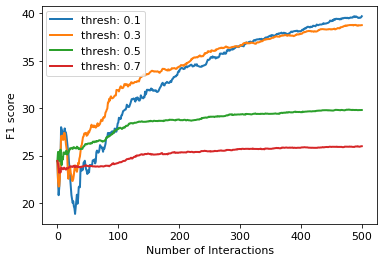

In [361]:
plt.rcParams.update({'font.size': 11})
d1["f1"].plot(linewidth=2, label="thresh: 0.1")
d2["f1"].plot(linewidth=2, label="thresh: 0.3")
d3["f1"].plot(linewidth=2, label="thresh: 0.5")
d4["f1"].plot(linewidth=2, label="thresh: 0.7")
#pd.Series([21.42]*(number_of_queries+1)).plot(linewidth=2, label="baseline")
plt.ylabel("F1 score")
plt.xlabel("Number of Interactions")
plt.legend(loc=(0.01,0.68))
plt.savefig('implicit_threshold4.png', bbox_inches='tight',pad_inches = 0.1, dpi = 600)